# Dataset for MSR 2019 (data showcase paper)

## Prerequisites

In [28]:
# This points to the dataset CSV file (leave out the '_release.csv' suffix!)
VULAS_DB_NAME='../dataset/vulas_db_msr2019'

GIT_REPO_FOLDER = '/tmp/git-cache-3'
SKIP_CLONE_EXISTING=True

# This controls how many negatives you want per each positive
RATIO_POS_NEG = 1
DATASET_NAME='dataset_msr2019'

In [29]:
%reload_ext autoreload
%autoreload 2

import os
import sys; sys.path.append(os.path.join(sys.path[0],'acacia'))
import pandas as pd
from tqdm import tqdm
import pickle
import matplotlib
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import numpy as np

import requests
import requests_cache
requests_cache.install_cache('requests_cache', expire_after=7 * 24*60*60)

# acacia stuff
from utils import *
from acacia.git import clone_repo, clone_repo_multiple, extract_commit_msg, extract_commit_diff, get_random_commits
from acacia.git_temporal import extract_timing_data

POS_CLS='pos'
NEG_CLS='neg'

In [30]:
le = LatexExporter()

## Load dataset from CSV file

In [31]:
with open(VULAS_DB_NAME + '_release.csv','r') as f:
    data = f.readlines()

vulas_db_content=[]
for d in data:
    line = d.strip().split(',')
    vulas_db_content.append(tuple(line))

# len(vulas_db_content)
print('Dataset contains {} commits'.format(len(vulas_db_content)))

Dataset contains 1282 commits


### Cloning

This clones locally all (external git) repositories that appear in the Vulas DB.

In [32]:
repos_set = set([ r for _,r,_,_ in vulas_db_content ])
clone_repo_multiple(repos_set,
       output_folder=GIT_REPO_FOLDER,
       proxy='',
       skip_existing=SKIP_CLONE_EXISTING,
       concurrent=8)

## Storing commit data in a dataframe (positive instances)

In [33]:
def extract_commit(db_content, verbose=False):
    ''' return a dataframe with commit data '''
    data = []
    for vuln_id, repo, commit, cls in tqdm(db_content):
        try:
            commit_msg = extract_commit_msg(commit, repo, GIT_REPO_FOLDER) 
            commit_diff = extract_commit_diff(commit, repo, GIT_REPO_FOLDER)
            fix_tag, fix_tag_timestamp, commit_timestamp, commit_tag_delay = extract_timing_data(commit, repo, verbose, GIT_REPO_FOLDER)
            data.append({
                'msg' : commit_msg.decode("latin-1"),
                'diff': commit_diff.decode("latin-1"),
                'cls': cls,
                'commit_id': commit,
                'repo_url': repo,
                'vuln_id': vuln_id,
                'in_nvd': False,
                'fix_tag': fix_tag,
                'fix_tag_timestamp': int(fix_tag_timestamp),
                'commit_timestamp' : int(commit_timestamp),
                'commit_tag_delay': int(commit_tag_delay)
            })
        except Exception as e:
            pass
            print('Skipping %s' % repo)
            print(e)

    return pd.DataFrame(data)

df_pos = extract_commit(vulas_db_content, verbose=False)
df_pos.to_pickle(DATASET_NAME + '_pos.pd')


  0%|          | 1/1282 [00:01<30:50,  1.44s/it]

('v2.4.5.RELEASE', '1496240700', '1496240700', 0)



  0%|          | 2/1282 [00:02<30:56,  1.45s/it]

('4.0.5', '1521443138', '1520616563', 826575)



  0%|          | 3/1282 [00:05<37:14,  1.75s/it]

('camel-2.16.5', '1481903857', '1481744113', 159744)



  0%|          | 4/1282 [00:08<42:55,  2.02s/it]

('jenkins-2.84', '1507571749', '1505309456', 2262293)



  0%|          | 5/1282 [00:10<42:58,  2.02s/it]

('TOMCAT_9_0_9', '1529499958', '1529350518', 149440)



  0%|          | 6/1282 [00:11<42:15,  1.99s/it]

('TOMCAT_8_5_10', '1483656695', '1481713005', 1943690)



  1%|          | 7/1282 [00:13<40:37,  1.91s/it]

('TOMCAT_5_5_29', '1269869757', '1264878855', 4990902)



  1%|          | 8/1282 [00:15<41:20,  1.95s/it]

('v2.1.2', '1506970635', '1496353498', 10617137)



  1%|          | 9/1282 [00:17<40:46,  1.92s/it]

('TOMCAT_8_0_0_RC2', '1379434016', '1378907061', 526955)



  1%|          | 10/1282 [00:19<40:25,  1.91s/it]

('TOMCAT_9_0_0_M1', '1447365794', '1398424255', 48941539)



  1%|          | 11/1282 [00:20<40:21,  1.91s/it]

('rel/release-2.3.4', '1541020751', '1540451552', 569199)



  1%|          | 12/1282 [00:22<39:54,  1.89s/it]

('3.6.9', '1492740314', '1492722956', 17358)



  1%|          | 13/1282 [00:25<40:42,  1.93s/it]

('v4.3.17.RELEASE', '1525765700', '1523938812', 1826888)



  1%|          | 14/1282 [00:27<40:49,  1.93s/it]

('TOMCAT_8_0_39', '1478591933', '1478089115', 502818)



  1%|          | 15/1282 [00:28<40:07,  1.90s/it]

('r1rv57', '1494568533', '1476490865', 18077668)



  1%|          | 16/1282 [00:30<40:29,  1.92s/it]

('camel-2.13.0', '1395064468', '1389345479', 5718989)



  1%|▏         | 17/1282 [00:32<39:57,  1.89s/it]

('jackson-databind-2.9.0', '1501388466', '1498840213', 2548253)



  1%|▏         | 18/1282 [00:33<39:28,  1.87s/it]

('1.0.0-rc0', '1507682601', '1504197728', 3484873)



  1%|▏         | 19/1282 [00:35<39:02,  1.85s/it]

('STRUTS_2_3_14_3', '1370251048', '1370249236', 1812)



  2%|▏         | 20/1282 [00:36<38:38,  1.84s/it]

('2.7.4.14', '1492544092', '1492541356', 2736)



  2%|▏         | 21/1282 [00:38<38:35,  1.84s/it]

('TOMCAT_7_0_23', '1321552355', '1320654402', 897953)



  2%|▏         | 22/1282 [00:40<38:36,  1.84s/it]

('TOMCAT_9_0_0_M10', '1472655568', '1472597729', 57839)



  2%|▏         | 23/1282 [00:42<38:46,  1.85s/it]

('cxf-3.0.13', '1491421812', '1483115370', 8306442)



  2%|▏         | 24/1282 [00:44<38:54,  1.86s/it]

('5.2.5.Final', '1489589716', '1406098929', 83490787)



  2%|▏         | 25/1282 [00:47<39:34,  1.89s/it]

('camel-2.17.5', '1484689776', '1481278509', 3411267)



  2%|▏         | 26/1282 [00:49<39:35,  1.89s/it]

('REL_3_11_BETA1', '1406832992', '1392854086', 13978906)



  2%|▏         | 27/1282 [00:50<39:23,  1.88s/it]

('esapi-2.1.0', '1378171007', '1377737381', 433626)



  2%|▏         | 28/1282 [00:52<39:17,  1.88s/it]

('rel/release-2.3.3', '1522280789', '1520033796', 2246993)



  2%|▏         | 29/1282 [00:54<39:08,  1.87s/it]

('wicket-jquery-ui-6.28.1', '1514413771', '1514389926', 23845)



  2%|▏         | 30/1282 [00:56<38:59,  1.87s/it]

('5.2.5.Final', '1489589716', '1406103198', 83486518)



  2%|▏         | 31/1282 [00:57<38:54,  1.87s/it]

('v2.7.1', '1498849106', '1454384221', 44464885)



  2%|▏         | 32/1282 [00:59<38:53,  1.87s/it]

('REL_3_17_BETA1', '1498296431', '1493767933', 4528498)



  3%|▎         | 33/1282 [01:01<38:45,  1.86s/it]

('activemq-5.11.3', '1446127007', '1446039209', 87798)



  3%|▎         | 34/1282 [01:02<38:31,  1.85s/it]

('shiro-root-1.3.2', '1473457952', '1473452817', 5135)



  3%|▎         | 35/1282 [01:06<39:14,  1.89s/it]

('', '0', '1527063620', -1527063620)



  3%|▎         | 36/1282 [01:08<39:47,  1.92s/it]

('jenkins-2.89', '1509992125', '1508429691', 1562434)



  3%|▎         | 37/1282 [01:11<39:55,  1.92s/it]

('TOMCAT_7_0_23', '1321552355', '1319904978', 1647377)



  3%|▎         | 38/1282 [01:13<39:50,  1.92s/it]

('3.20.0', '1496950449', '1496948452', 1997)



  3%|▎         | 39/1282 [01:15<40:08,  1.94s/it]

('1.565.1-rc1', '1401243057', '1392146256', 9096801)



  3%|▎         | 40/1282 [01:17<39:59,  1.93s/it]

('1.18-RC1', '1534144445', '1533839963', 304482)



  3%|▎         | 41/1282 [01:18<39:38,  1.92s/it]

('', '0', '1237993876', -1237993876)



  3%|▎         | 42/1282 [01:20<39:34,  1.92s/it]

('TOMCAT_7_0_42', '1372751619', '1299673258', 73078361)



  3%|▎         | 43/1282 [01:21<39:14,  1.90s/it]

('', '0', '1432206700', -1432206700)



  3%|▎         | 44/1282 [01:23<39:20,  1.91s/it]

('TOMCAT_9_0_0_M19', '1490613205', '1490388680', 224525)



  4%|▎         | 45/1282 [01:25<39:18,  1.91s/it]

('gerrit-trigger-2.27.5', '1519212287', '1519209107', 3180)



  4%|▎         | 46/1282 [01:27<39:12,  1.90s/it]

('XSTREAM_1_4_9', '1458083383', '1444153038', 13930345)



  4%|▎         | 47/1282 [01:29<39:04,  1.90s/it]

('3.1.6.RELEASE', '1394486792', '1394480639', 6153)



  4%|▎         | 48/1282 [01:31<39:14,  1.91s/it]

('camel-2.18.3', '1488999888', '1488179099', 820789)



  4%|▍         | 49/1282 [01:33<39:08,  1.90s/it]

('3.3.0.3', '1469040744', '1462308206', 6732538)



  4%|▍         | 50/1282 [01:35<39:02,  1.90s/it]

('STRUTS_2_3_16', '1385807266', '1373875343', 11931923)



  4%|▍         | 51/1282 [01:37<39:18,  1.92s/it]

('', '0', '1364568129', -1364568129)



  4%|▍         | 52/1282 [01:40<39:30,  1.93s/it]

('camel-2.17.6', '1488709476', '1488179471', 530005)



  4%|▍         | 53/1282 [01:41<39:21,  1.92s/it]

('STRUTS_2_3_14_3', '1370251048', '1370249180', 1868)



  4%|▍         | 54/1282 [01:43<39:10,  1.91s/it]

('1.3.0', '1442614234', '1440632109', 1982125)



  4%|▍         | 55/1282 [01:45<39:13,  1.92s/it]

('TOMCAT_7_0_53', '1395716435', '1395059699', 656736)



  4%|▍         | 56/1282 [01:47<39:18,  1.92s/it]

('6.0.0.Alpha3', '1530696485', '1529917573', 778912)



  4%|▍         | 57/1282 [01:48<39:01,  1.91s/it]

('', '0', '1395694514', -1395694514)



  5%|▍         | 58/1282 [01:50<38:50,  1.90s/it]

('email-ext-2.57.1', '1490023083', '1485208614', 4814469)



  5%|▍         | 59/1282 [01:51<38:34,  1.89s/it]

('', '0', '1437641386', -1437641386)



  5%|▍         | 60/1282 [01:53<38:32,  1.89s/it]

('jetty-9.0.x', '1384441027', '1374714083', 9726944)



  5%|▍         | 61/1282 [01:54<38:18,  1.88s/it]

('', '0', '1504896952', -1504896952)



  5%|▍         | 62/1282 [01:56<38:13,  1.88s/it]

('2.7.0.3', '1444426147', '1438790062', 5636085)



  5%|▍         | 63/1282 [01:58<38:03,  1.87s/it]

('2.0.15.RELEASE', '1525785335', '1525728907', 56428)



  5%|▍         | 64/1282 [01:59<37:54,  1.87s/it]

('r1rv57', '1494568533', '1478214261', 16354272)



  5%|▌         | 65/1282 [02:00<37:40,  1.86s/it]

('', '0', '1520443585', -1520443585)



  5%|▌         | 66/1282 [02:02<37:32,  1.85s/it]

('STRUTS_2_3_14_1', '1366308347', '1366278581', 29766)



  5%|▌         | 67/1282 [02:03<37:25,  1.85s/it]

('commons-collections-4.2-RC1', '1531009098', '1447445325', 83563773)



  5%|▌         | 68/1282 [02:05<37:22,  1.85s/it]

('TOMCAT_7_0_42', '1372751619', '1299251842', 73499777)



  5%|▌         | 69/1282 [02:07<37:29,  1.85s/it]

('7.5', '1545127000', '1526322048', 18804952)



  5%|▌         | 70/1282 [02:09<37:27,  1.85s/it]

('jetty-9.3.24.v20180605', '1528218663', '1527788597', 430066)



  6%|▌         | 71/1282 [02:11<37:20,  1.85s/it]

('3.3.0.3', '1469040744', '1462233857', 6806887)



  6%|▌         | 72/1282 [02:13<37:16,  1.85s/it]

('v1.7.10.RELEASE', '1536585422', '1535486548', 1098874)



  6%|▌         | 73/1282 [02:15<37:30,  1.86s/it]

('release-3.1.1-RC0', '1533163867', '1527063499', 6100368)



  6%|▌         | 74/1282 [02:17<37:19,  1.85s/it]

('', '0', '1462484595', -1462484595)



  6%|▌         | 75/1282 [02:18<37:14,  1.85s/it]

('r1v60', '1530483250', '1520046394', 10436856)



  6%|▌         | 76/1282 [02:20<37:16,  1.85s/it]

('TOMCAT_8_0_29', '1447962925', '1447950032', 12893)



  6%|▌         | 77/1282 [02:22<37:11,  1.85s/it]

('commons-fileupload-1.4-RC1', '1545621150', '1463040839', 82580311)



  6%|▌         | 78/1282 [02:24<37:10,  1.85s/it]

('TOMCAT_7_0_23', '1321552355', '1320152996', 1399359)



  6%|▌         | 79/1282 [02:26<37:13,  1.86s/it]

('geronimo-2.1.5', '1270561228', '1237992027', 32569201)



  6%|▌         | 80/1282 [02:29<37:19,  1.86s/it]

('v5.0.5.RELEASE', '1522786276', '1520895539', 1890737)



  6%|▋         | 81/1282 [02:30<37:17,  1.86s/it]

('r1v60', '1530483250', '1524127201', 6356049)



  6%|▋         | 82/1282 [02:32<37:12,  1.86s/it]

('STRUTS_2_5', '1462454486', '1457690654', 4763832)



  6%|▋         | 83/1282 [02:34<37:16,  1.87s/it]

('nifi-1.5.0-RC1', '1515479972', '1515433496', 46476)



  7%|▋         | 84/1282 [02:37<37:21,  1.87s/it]

('TOMCAT_7_0_48', '1386615649', '1386582418', 33231)



  7%|▋         | 85/1282 [02:38<37:17,  1.87s/it]

('7.0.1', '1517579083', '1516190805', 1388278)



  7%|▋         | 86/1282 [02:40<37:12,  1.87s/it]

('v_1.2.0', '1486592317', '1486505571', 86746)



  7%|▋         | 87/1282 [02:42<37:16,  1.87s/it]

('jenkins-2.138.4', '1543863759', '1542804444', 1059315)



  7%|▋         | 88/1282 [02:44<37:11,  1.87s/it]

('2.4m1', '1509217629', '1507227662', 1989967)



  7%|▋         | 89/1282 [02:46<37:05,  1.87s/it]

('STRUTS_2_3_1_1', '1324765930', '1324412269', 353661)



  7%|▋         | 90/1282 [02:48<37:08,  1.87s/it]

('camel-2.19.4', '1509556666', '1508488690', 1067976)



  7%|▋         | 91/1282 [02:49<37:02,  1.87s/it]

('1.20', '1545095084', '1541702880', 3392204)



  7%|▋         | 92/1282 [02:51<37:01,  1.87s/it]

('TOMCAT_7_0_68', '1454961706', '1453380973', 1580733)



  7%|▋         | 93/1282 [02:53<36:57,  1.86s/it]

('1.3.1', '1525714289', '1525275078', 439211)



  7%|▋         | 94/1282 [02:55<36:56,  1.87s/it]

('cxf-3.2.0', '1504714725', '1491386481', 13328244)



  7%|▋         | 95/1282 [02:57<36:52,  1.86s/it]

('2.7.4.8', '1474065912', '1474061448', 4464)



  7%|▋         | 96/1282 [02:59<36:52,  1.87s/it]

('v2018.06.25.01', '1529964263', '1522264487', 7699776)



  8%|▊         | 97/1282 [03:01<36:54,  1.87s/it]

('camel-2.11.2', '1379570407', '1379250802', 319605)



  8%|▊         | 98/1282 [03:03<36:51,  1.87s/it]

('4.5.7', '1531428596', '1531347096', 81500)



  8%|▊         | 99/1282 [03:04<36:49,  1.87s/it]

('jackson-dataformat-xml-2.7.8', '1474945952', '1474945878', 74)



  8%|▊         | 100/1282 [03:06<36:40,  1.86s/it]

('', '0', '1383319517', -1383319517)



  8%|▊         | 101/1282 [03:07<36:36,  1.86s/it]

('STRUTS_2_5_13', '1503486307', '1501659071', 1827236)



  8%|▊         | 102/1282 [03:09<36:31,  1.86s/it]

('Release_1.3', '1534015475', '1517397098', 16618377)



  8%|▊         | 103/1282 [03:11<36:28,  1.86s/it]

('v3.2.14.RELEASE', '1435685767', '1435665540', 20227)



  8%|▊         | 104/1282 [03:13<36:27,  1.86s/it]

('', '0', '1502275613', -1502275613)



  8%|▊         | 105/1282 [03:14<36:24,  1.86s/it]

('TOMCAT_9_0_0_M18', '1488986204', '1488838445', 147759)



  8%|▊         | 106/1282 [03:16<36:23,  1.86s/it]

('TOMCAT_7_0_30', '1346535387', '1346096586', 438801)



  8%|▊         | 107/1282 [03:18<36:24,  1.86s/it]

('camel-2.15.0', '1425697430', '1425280545', 416885)



  8%|▊         | 108/1282 [03:20<36:17,  1.85s/it]

('4.4.2', '1547820235', '1536812558', 11007677)



  9%|▊         | 109/1282 [03:22<36:15,  1.85s/it]

('TOMCAT_8_0_0_RC1', '1375387909', '1314647093', 60740816)



  9%|▊         | 110/1282 [03:23<36:12,  1.85s/it]

('TOMCAT_8_0_0_RC1', '1375387909', '1362255448', 13132461)



  9%|▊         | 111/1282 [03:25<36:10,  1.85s/it]

('TOMCAT_8_5_13', '1490624555', '1490623000', 1555)



  9%|▊         | 112/1282 [03:27<36:05,  1.85s/it]

('TOMCAT_5_5_34', '1316371697', '1313686179', 2685518)



  9%|▉         | 113/1282 [03:29<36:03,  1.85s/it]

('TOMCAT_7_0_23', '1321552355', '1319738547', 1813808)



  9%|▉         | 114/1282 [03:30<36:01,  1.85s/it]

('TOMCAT_7_0_42', '1372751619', '1301657814', 71093805)



  9%|▉         | 115/1282 [03:32<35:58,  1.85s/it]

('STRUTS_2_5', '1462454486', '1457255295', 5199191)



  9%|▉         | 116/1282 [03:34<35:59,  1.85s/it]

('v5.0.7.RELEASE', '1528816181', '1528737404', 78777)



  9%|▉         | 117/1282 [03:36<35:58,  1.85s/it]

('TOMCAT_7_0_42', '1372751619', '1171242123', 201509496)



  9%|▉         | 118/1282 [03:38<35:55,  1.85s/it]

('3.6.0.CR1', '1541772228', '1538057100', 3715128)



  9%|▉         | 119/1282 [03:39<35:49,  1.85s/it]

('FOREVER_20160608', '1465353510', '1465353510', 0)



  9%|▉         | 120/1282 [03:41<35:44,  1.85s/it]

('', '0', '1447871185', -1447871185)



  9%|▉         | 121/1282 [03:43<35:41,  1.84s/it]

('TOMCAT_8_5_23', '1506594008', '1506382879', 211129)



 10%|▉         | 122/1282 [03:45<35:42,  1.85s/it]

('history/branches/lucene-solr/LUCENE-5622', '1398849853', '1348740642', 50109211)



 10%|▉         | 123/1282 [03:46<35:38,  1.84s/it]

('STRUTS_2_3_32', '1488798186', '1488797799', 387)



 10%|▉         | 124/1282 [03:48<35:36,  1.84s/it]

('TOMCAT_7_0_42', '1372751619', '1309166826', 63584793)



 10%|▉         | 125/1282 [03:51<35:40,  1.85s/it]

('YARN-5355-branch-2-2017-04-25', '1493201612', '1492021193', 1180419)



 10%|▉         | 126/1282 [03:52<35:36,  1.85s/it]

('jackson-databind-2.8.10', '1503548804', '1503007967', 540837)



 10%|▉         | 127/1282 [03:54<35:34,  1.85s/it]

('TOMCAT_9_0_0_M1', '1447365794', '1402082047', 45283747)



 10%|▉         | 128/1282 [03:56<35:31,  1.85s/it]

('jackson-databind-2.7.9.4', '1528436297', '1528436142', 155)



 10%|█         | 129/1282 [03:57<35:26,  1.84s/it]

('1.3.0', '1442614234', '1441736374', 877860)



 10%|█         | 130/1282 [03:59<35:24,  1.84s/it]

('TOMCAT_8_5_13', '1490624555', '1490389257', 235298)



 10%|█         | 131/1282 [04:01<35:19,  1.84s/it]

('fediz-1.4.0', '1493119959', '1482153630', 10966329)



 10%|█         | 132/1282 [04:02<35:15,  1.84s/it]

('STRUTS_2_3_14_1', '1366308347', '1366278581', 29766)



 10%|█         | 133/1282 [04:05<35:24,  1.85s/it]

('v1.6.0', '1433856908', '1432853955', 1002953)



 10%|█         | 134/1282 [04:07<35:20,  1.85s/it]

('android-lint-2.6', '1517349681', '1517346177', 3504)



 11%|█         | 135/1282 [04:09<35:15,  1.84s/it]

('TOMCAT_5_5_30', '1277996992', '1277930616', 66376)



 11%|█         | 136/1282 [04:10<35:11,  1.84s/it]

('depgraph-view-0.13', '1508186988', '1508186239', 749)



 11%|█         | 137/1282 [04:12<35:12,  1.84s/it]

('camel-2.19.0', '1493498694', '1487943274', 5555420)



 11%|█         | 138/1282 [04:14<35:08,  1.84s/it]

('1.18-rc2', '1523926398', '1523924094', 2304)



 11%|█         | 139/1282 [04:16<35:09,  1.85s/it]

('1.502-rc1', '1360777758', '1357428761', 3348997)



 11%|█         | 140/1282 [04:18<35:05,  1.84s/it]

('v2.1.0.M3', '1536671908', '1535487578', 1184330)



 11%|█         | 141/1282 [04:19<35:02,  1.84s/it]

('STRUTS_2_3_4_1', '1344002055', '1344001288', 767)



 11%|█         | 142/1282 [04:21<35:02,  1.84s/it]

('1.14.0-rc1', '1534202143', '1530006409', 4195734)



 11%|█         | 143/1282 [04:24<35:03,  1.85s/it]

('jenkins-2.138.2', '1539023207', '1538040666', 982541)



 11%|█         | 144/1282 [04:25<34:57,  1.84s/it]

('', '0', '1527259247', -1527259247)



 11%|█▏        | 145/1282 [04:27<34:59,  1.85s/it]

('1.565.1-rc1', '1401243057', '1392145687', 9097370)



 11%|█▏        | 146/1282 [04:29<34:58,  1.85s/it]

('TOMCAT_7_0_77', '1490715923', '1490646927', 68996)



 11%|█▏        | 147/1282 [04:31<34:56,  1.85s/it]

('v2.2.0', '1468794314', '1467210603', 1583711)



 12%|█▏        | 148/1282 [04:33<34:55,  1.85s/it]

('STRUTS_2_3_34', '1504636634', '1503750380', 886254)



 12%|█▏        | 149/1282 [04:35<34:52,  1.85s/it]

('4.2.0.M1', '1474659573', '1467838043', 6821530)



 12%|█▏        | 150/1282 [04:37<34:54,  1.85s/it]

('camel-2.12.1', '1379532823', '1379250789', 282034)



 12%|█▏        | 151/1282 [04:39<34:50,  1.85s/it]

('commons-collections-4.2-RC1', '1531009098', '1447507464', 83501634)



 12%|█▏        | 152/1282 [04:40<34:46,  1.85s/it]

('fediz-1.2.1', '1438797024', '1435854115', 2942909)



 12%|█▏        | 153/1282 [04:42<34:43,  1.85s/it]

('javamelody-core-1.57.1', '1445612777', '1380232975', 65379802)



 12%|█▏        | 154/1282 [04:43<34:37,  1.84s/it]

('', '0', '1437641369', -1437641369)



 12%|█▏        | 155/1282 [04:45<34:35,  1.84s/it]

('activemq-5.11.3', '1446127007', '1446039761', 87246)



 12%|█▏        | 156/1282 [04:46<34:29,  1.84s/it]

('', '0', '1472647171', -1472647171)



 12%|█▏        | 157/1282 [04:48<34:25,  1.84s/it]

('parent-3.1.1', '1454901019', '1454862082', 38937)



 12%|█▏        | 158/1282 [04:49<34:22,  1.84s/it]

('4.10.1', '1528931940', '1488218381', 40713559)



 12%|█▏        | 159/1282 [04:51<34:19,  1.83s/it]

('pluto-3.0.1', '1529095254', '1518078749', 11016505)



 12%|█▏        | 160/1282 [04:53<34:17,  1.83s/it]

('TOMCAT_9_0_5', '1517953233', '1517917089', 36144)



 13%|█▎        | 161/1282 [04:55<34:15,  1.83s/it]

('activemq-5.11.0', '1422621968', '1409057226', 13564742)



 13%|█▎        | 162/1282 [04:56<34:12,  1.83s/it]

('3.6.11', '1495064565', '1495061442', 3123)



 13%|█▎        | 163/1282 [04:58<34:09,  1.83s/it]

('3.6.10', '1494621471', '1494617330', 4141)



 13%|█▎        | 164/1282 [04:59<34:03,  1.83s/it]

('', '0', '1268064660', -1268064660)



 13%|█▎        | 165/1282 [05:02<34:04,  1.83s/it]

('camel-2.15.5', '1448264071', '1447350277', 913794)



 13%|█▎        | 166/1282 [05:03<34:01,  1.83s/it]

('STRUTS_2_5_16', '1519991993', '1519105765', 886228)



 13%|█▎        | 167/1282 [05:05<33:58,  1.83s/it]

('esapi-2.1.0.1', '1454651763', '1454223419', 428344)



 13%|█▎        | 168/1282 [05:07<33:56,  1.83s/it]

('4.4.2', '1547820235', '1536849207', 10971028)



 13%|█▎        | 169/1282 [05:08<33:50,  1.82s/it]

('', '0', '1268064654', -1268064654)



 13%|█▎        | 170/1282 [05:10<33:48,  1.82s/it]

('wicket-jquery-ui-8.0.0-M8.1', '1514413125', '1514412873', 252)



 13%|█▎        | 171/1282 [05:11<33:44,  1.82s/it]

('', '0', '1491223204', -1491223204)



 13%|█▎        | 172/1282 [05:12<33:38,  1.82s/it]

('', '0', '1474545006', -1474545006)



 13%|█▎        | 173/1282 [05:14<33:38,  1.82s/it]

('TOMCAT_7_0_22', '1317155230', '1317154741', 489)



 14%|█▎        | 174/1282 [05:16<33:36,  1.82s/it]

('rel/v1.5.0.RC1', '1521480664', '1515610962', 5869702)



 14%|█▎        | 175/1282 [05:18<33:37,  1.82s/it]

('1.565.1-rc1', '1401243057', '1392146566', 9096491)



 14%|█▎        | 176/1282 [05:20<33:34,  1.82s/it]

('STRUTS_2_3_14_3', '1370251048', '1370249519', 1529)



 14%|█▍        | 177/1282 [05:22<33:35,  1.82s/it]

('camel-2.21.2', '1531748549', '1531124778', 623771)



 14%|█▍        | 178/1282 [05:24<33:32,  1.82s/it]

('TOMCAT_5_5_35', '1325873414', '1324391688', 1481726)



 14%|█▍        | 179/1282 [05:26<33:34,  1.83s/it]

('releases/lucene-solr/6.6.5', '1530332169', '1530273479', 58690)



 14%|█▍        | 180/1282 [05:28<33:34,  1.83s/it]

('karaf-4.0.9', '1491462650', '1489502921', 1959729)



 14%|█▍        | 181/1282 [05:31<33:37,  1.83s/it]

('camel-2.16.1', '1447791185', '1447336411', 454774)



 14%|█▍        | 182/1282 [05:34<33:39,  1.84s/it]

('cxf-3.1.3', '1442430687', '1438275332', 4155355)



 14%|█▍        | 183/1282 [05:36<33:37,  1.84s/it]

('TOMCAT_8_5_6', '1475784678', '1475563232', 221446)



 14%|█▍        | 184/1282 [05:38<33:37,  1.84s/it]

('TOMCAT_8_0_40', '1484306863', '1483628545', 678318)



 14%|█▍        | 185/1282 [05:39<33:35,  1.84s/it]

('REL_3_11_BETA2', '1408275166', '1407184961', 1090205)



 15%|█▍        | 186/1282 [05:41<33:32,  1.84s/it]

('r1rv55', '1471490053', '1452707147', 18782906)



 15%|█▍        | 187/1282 [05:43<33:31,  1.84s/it]

('TOMCAT_8_5_16', '1498064283', '1495465031', 2599252)



 15%|█▍        | 188/1282 [05:45<33:28,  1.84s/it]

('5.2.5.Final', '1489589716', '1406098929', 83490787)



 15%|█▍        | 189/1282 [05:46<33:26,  1.84s/it]

('5.2.0.M1', '1547607721', '1542122418', 5485303)



 15%|█▍        | 190/1282 [05:48<33:23,  1.83s/it]

('2.7.0.3', '1444426147', '1438985160', 5440987)



 15%|█▍        | 191/1282 [05:50<33:20,  1.83s/it]

('r1rv57', '1494568533', '1480388176', 14180357)



 15%|█▍        | 192/1282 [05:51<33:17,  1.83s/it]

('r1rv57', '1494568533', '1472262087', 22306446)



 15%|█▌        | 193/1282 [05:53<33:14,  1.83s/it]

('r1rv57', '1494568533', '1476499455', 18069078)



 15%|█▌        | 194/1282 [05:55<33:13,  1.83s/it]

('log4j-2.8.2-rc1', '1491163500', '1491154880', 8620)



 15%|█▌        | 195/1282 [05:57<33:11,  1.83s/it]

('3.9.13', '1495069185', '1495060644', 8541)



 15%|█▌        | 196/1282 [05:59<33:09,  1.83s/it]

('7.0.1', '1517579083', '1516190812', 1388271)



 15%|█▌        | 197/1282 [06:00<33:07,  1.83s/it]

('1.4.15', '1523815914', '1523462722', 353192)



 15%|█▌        | 198/1282 [06:03<33:07,  1.83s/it]

('TOMCAT_7_0_82', '1506687174', '1506624058', 63116)



 16%|█▌        | 199/1282 [06:04<33:05,  1.83s/it]

('batik-1_9', '1491811128', '1462782857', 29028271)



 16%|█▌        | 200/1282 [06:06<33:01,  1.83s/it]

('', '0', '1472733889', -1472733889)



 16%|█▌        | 201/1282 [06:08<33:02,  1.83s/it]

('camel-2.15.0', '1425697430', '1425280544', 416886)



 16%|█▌        | 202/1282 [06:11<33:04,  1.84s/it]

('YARN-5355-branch-2-2016-11-06', '1478454212', '1464369270', 14084942)



 16%|█▌        | 203/1282 [06:12<33:01,  1.84s/it]

('cas-client-3.3.2', '1407039734', '1404069118', 2970616)



 16%|█▌        | 204/1282 [06:14<33:01,  1.84s/it]

('TOMCAT_8_0_42', '1489002987', '1488838525', 164462)



 16%|█▌        | 205/1282 [06:16<32:58,  1.84s/it]

('2.0.16.RELEASE', '1539618828', '1539618731', 97)



 16%|█▌        | 206/1282 [06:18<32:55,  1.84s/it]

('TOMCAT_5_5_34', '1316371697', '1313499033', 2872664)



 16%|█▌        | 207/1282 [06:20<32:53,  1.84s/it]

('2.7.4.16', '1494627049', '1494623107', 3942)



 16%|█▌        | 208/1282 [06:22<32:53,  1.84s/it]

('v5.0.10.RELEASE', '1539590506', '1539572013', 18493)



 16%|█▋        | 209/1282 [06:23<32:51,  1.84s/it]

('XSTREAM_1_4_10', '1495549623', '1491223536', 4326087)



 16%|█▋        | 210/1282 [06:25<32:48,  1.84s/it]

('', '0', '1390319136', -1390319136)



 16%|█▋        | 211/1282 [06:27<32:44,  1.83s/it]

('', '0', '1268064324', -1268064324)



 17%|█▋        | 212/1282 [06:29<32:44,  1.84s/it]

('cxf-2.7.10', '1391706726', '1343922591', 47784135)



 17%|█▋        | 213/1282 [06:31<32:42,  1.84s/it]

('activemq-5.14.0', '1470142974', '1455309825', 14833149)



 17%|█▋        | 214/1282 [06:32<32:41,  1.84s/it]

('v1.6.0', '1305622450', '1274044622', 31577828)



 17%|█▋        | 215/1282 [06:34<32:38,  1.84s/it]

('', '0', '1501201797', -1501201797)



 17%|█▋        | 216/1282 [06:36<32:37,  1.84s/it]

('TOMCAT_9_0_0_M2', '1453377768', '1448635947', 4741821)



 17%|█▋        | 217/1282 [06:38<32:36,  1.84s/it]

('karaf-4.1.7', '1543246513', '1537452720', 5793793)



 17%|█▋        | 218/1282 [06:40<32:34,  1.84s/it]

('TOMCAT_8_5_23', '1506594008', '1506537459', 56549)



 17%|█▋        | 219/1282 [06:42<32:33,  1.84s/it]

('TOMCAT_8_0_36', '1465480394', '1463169809', 2310585)



 17%|█▋        | 220/1282 [06:44<32:31,  1.84s/it]

('XSTREAM_1_4_9', '1458083383', '1444375446', 13707937)



 17%|█▋        | 221/1282 [06:46<32:31,  1.84s/it]

('cxf-3.1.9', '1481312181', '1476802958', 4509223)



 17%|█▋        | 222/1282 [06:47<32:27,  1.84s/it]

('', '0', '1390319136', -1390319136)



 17%|█▋        | 223/1282 [06:49<32:25,  1.84s/it]

('3.5.4', '1538040572', '1538550175', -509603)



 17%|█▋        | 224/1282 [06:52<32:27,  1.84s/it]

('camel-2.19.0', '1493498694', '1481189358', 12309336)



 18%|█▊        | 225/1282 [06:54<32:26,  1.84s/it]

('v4.3.15.RELEASE', '1522786232', '1521856350', 929882)



 18%|█▊        | 226/1282 [06:56<32:25,  1.84s/it]

('TOMCAT_8_5_5', '1472672940', '1472597005', 75935)



 18%|█▊        | 227/1282 [06:58<32:24,  1.84s/it]

('TOMCAT_7_0_82', '1506687174', '1506605446', 81728)



 18%|█▊        | 228/1282 [07:00<32:22,  1.84s/it]

('STRUTS_2_3_15_2', '1380779047', '1379483413', 1295634)



 18%|█▊        | 229/1282 [07:02<32:21,  1.84s/it]

('jetty-9.4.11.v20180605', '1528222982', '1527787576', 435406)



 18%|█▊        | 230/1282 [07:03<32:19,  1.84s/it]

('coverity-1.11.0', '1519230670', '1515610348', 3620322)



 18%|█▊        | 231/1282 [07:05<32:17,  1.84s/it]

('TOMCAT_8_0_0_RC1', '1375387909', '1366626823', 8761086)



 18%|█▊        | 232/1282 [07:07<32:15,  1.84s/it]

('STRUTS_2_3_14_3', '1370251048', '1370249180', 1868)



 18%|█▊        | 233/1282 [07:09<32:15,  1.84s/it]

('TOMCAT_8_5_16', '1498064283', '1495654572', 2409711)



 18%|█▊        | 234/1282 [07:11<32:13,  1.84s/it]

('3.6.8', '1492490630', '1492487114', 3516)



 18%|█▊        | 235/1282 [07:13<32:11,  1.85s/it]

('v5.0.5.RELEASE', '1522786276', '1521630133', 1156143)



 18%|█▊        | 236/1282 [07:15<32:09,  1.84s/it]

('wicket-jquery-ui-7.9.2', '1514418895', '1514413133', 5762)



 18%|█▊        | 237/1282 [07:17<32:08,  1.84s/it]

('TOMCAT_7_0_42', '1372751619', '1261398314', 111353305)



 19%|█▊        | 238/1282 [07:18<32:05,  1.84s/it]

('TOMCAT_5_5_34', '1316371697', '1314647152', 1724545)



 19%|█▊        | 239/1282 [07:20<32:02,  1.84s/it]

('1.16-RC1', '1517592899', '1513967697', 3625202)



 19%|█▊        | 240/1282 [07:22<32:01,  1.84s/it]

('1.13.11.RELEASE', '1522844488', '1522776621', 67867)



 19%|█▉        | 241/1282 [07:24<31:58,  1.84s/it]

('', '0', '1508428406', -1508428406)



 19%|█▉        | 242/1282 [07:26<31:57,  1.84s/it]

('v4.0.2.RELEASE', '1392771182', '1392320172', 451010)



 19%|█▉        | 243/1282 [07:28<31:59,  1.85s/it]

('camel-2.20.4', '1532162012', '1531124805', 1037207)



 19%|█▉        | 244/1282 [07:31<32:02,  1.85s/it]

('camel-2.19.0', '1493498694', '1481295471', 12203223)



 19%|█▉        | 245/1282 [07:34<32:02,  1.85s/it]

('jackson-databind-2.7.9.1', '1492492253', '1492121290', 370963)



 19%|█▉        | 246/1282 [07:36<32:04,  1.86s/it]

('git-3.8.0', '1519160335', '1518975397', 184938)



 19%|█▉        | 247/1282 [07:38<32:02,  1.86s/it]

('', '0', '1501201634', -1501201634)



 19%|█▉        | 248/1282 [07:41<32:04,  1.86s/it]

('cxf-2.7.10', '1391706726', '1352922646', 38784080)



 19%|█▉        | 249/1282 [07:43<32:02,  1.86s/it]

('', '0', '1364572657', -1364572657)



 20%|█▉        | 250/1282 [07:45<32:02,  1.86s/it]

('STRUTS_2_3_15', '1373031372', '1370496588', 2534784)



 20%|█▉        | 251/1282 [07:47<32:01,  1.86s/it]

('FOREVER_20160608', '1465353510', '1431480433', 33873077)



 20%|█▉        | 252/1282 [07:51<32:05,  1.87s/it]

('1.565.1-rc1', '1401243057', '1392146559', 9096498)



 20%|█▉        | 253/1282 [07:54<32:08,  1.87s/it]

('cxf-3.2.5', '1529348129', '1527090459', 2257670)



 20%|█▉        | 254/1282 [07:56<32:08,  1.88s/it]

('karaf-4.1.1', '1490720972', '1489501520', 1219452)



 20%|█▉        | 255/1282 [07:58<32:07,  1.88s/it]

('geronimo-2.1.5', '1270561228', '1237992027', 32569201)



 20%|█▉        | 256/1282 [08:00<32:06,  1.88s/it]

('deeplearning4j-1.0.0-beta3', '1541471871', '1540340584', 1131287)



 20%|██        | 257/1282 [08:03<32:07,  1.88s/it]

('camel-2.17.6', '1488709476', '1487945992', 763484)



 20%|██        | 258/1282 [08:05<32:07,  1.88s/it]

('v5.1.1.RELEASE', '1539588025', '1539571765', 16260)



 20%|██        | 259/1282 [08:07<32:06,  1.88s/it]

('2.0.0.M1', '1479893747', '1474360085', 5533662)



 20%|██        | 260/1282 [08:09<32:05,  1.88s/it]

('wicket-jquery-ui-8.0.0-M9.2', '1520808968', '1520772331', 36637)



 20%|██        | 261/1282 [08:12<32:05,  1.89s/it]

('TOMCAT_7_0_42', '1372751619', '1277806434', 94945185)



 20%|██        | 262/1282 [08:14<32:05,  1.89s/it]

('5.3.6.Final', '1508428698', '1508420667', 8031)



 21%|██        | 263/1282 [08:17<32:06,  1.89s/it]

('v3.1.1.RELEASE', '1329435207', '1311884718', 17550489)



 21%|██        | 264/1282 [08:20<32:08,  1.89s/it]

('TOMCAT_8_0_0_RC6', '1386609676', '1386582316', 27360)



 21%|██        | 265/1282 [08:22<32:08,  1.90s/it]

('v1.5.0', '1518081627', '1516786553', 1295074)



 21%|██        | 266/1282 [08:25<32:09,  1.90s/it]

('3.6.0.CR1', '1541772234', '1527172616', 14599618)



 21%|██        | 267/1282 [08:27<32:09,  1.90s/it]

('3.0.0.RC3', '1505143485', '1504866044', 277441)



 21%|██        | 268/1282 [08:30<32:10,  1.90s/it]

('activemq-5.8.0', '1360165442', '1350557872', 9607570)



 21%|██        | 269/1282 [08:32<32:09,  1.90s/it]

('TOMCAT_5_5_29', '1269869757', '1264369391', 5500366)



 21%|██        | 270/1282 [08:35<32:10,  1.91s/it]

('14.0.0.Beta2', '1534373762', '1533864509', 509253)



 21%|██        | 271/1282 [08:36<32:07,  1.91s/it]

('', '0', '1364499180', -1364499180)



 21%|██        | 272/1282 [08:38<32:05,  1.91s/it]

('', '0', '1470300196', -1470300196)



 21%|██▏       | 273/1282 [08:41<32:06,  1.91s/it]

('JGroups-3.6.10.Final', '1467022340', '1461654026', 5368314)



 21%|██▏       | 274/1282 [08:43<32:05,  1.91s/it]

('STRUTS_2_3_29', '1465881057', '1464952258', 928799)



 21%|██▏       | 275/1282 [08:45<32:02,  1.91s/it]

('1.18-RC1', '1534144445', '1529084762', 5059683)



 22%|██▏       | 276/1282 [08:47<32:01,  1.91s/it]

('REL_3_11_BETA2', '1408275166', '1407176246', 1098920)



 22%|██▏       | 277/1282 [08:49<32:00,  1.91s/it]

('TOMCAT_7_0_23', '1321552355', '1319813199', 1739156)



 22%|██▏       | 278/1282 [08:51<31:58,  1.91s/it]

('v2.5.0.RC1', '1518470565', '1496245559', 22225006)



 22%|██▏       | 279/1282 [08:54<32:00,  1.91s/it]

('jenkins-2.95', '1513216680', '1513188444', 28236)



 22%|██▏       | 280/1282 [08:56<31:59,  1.92s/it]

('', '0', '1472730150', -1472730150)



 22%|██▏       | 281/1282 [08:59<32:00,  1.92s/it]

('5.0.0.M2', '1497561357', '1496894713', 666644)



 22%|██▏       | 282/1282 [09:02<32:02,  1.92s/it]

('apollo-project-1.7.1', '1422545605', '1409058669', 13486936)



 22%|██▏       | 283/1282 [09:04<32:01,  1.92s/it]

('2.0.6.RELEASE', '1522850002', '1522777484', 72518)



 22%|██▏       | 284/1282 [09:06<32:01,  1.93s/it]

('STRUTS_2_3_14_2', '1370244131', '1369405749', 838382)



 22%|██▏       | 285/1282 [09:10<32:04,  1.93s/it]

('1.502-rc1', '1360777758', '1357406765', 3370993)



 22%|██▏       | 286/1282 [09:13<32:05,  1.93s/it]

('jetty-9.3.13.M0', '1475258480', '1463165843', 12092637)



 22%|██▏       | 287/1282 [09:15<32:07,  1.94s/it]

('TOMCAT_9_0_0_M19', '1490613205', '1490366597', 246608)



 22%|██▏       | 288/1282 [09:19<32:09,  1.94s/it]

('', '0', '1518990066', -1518990066)



 23%|██▎       | 289/1282 [09:21<32:10,  1.94s/it]

('STRUTS_2_3_15_1', '1379400603', '1373811519', 5589084)



 23%|██▎       | 290/1282 [09:23<32:08,  1.94s/it]

('', '0', '1538048433', -1538048433)



 23%|██▎       | 291/1282 [09:26<32:08,  1.95s/it]

('XSTREAM_1_4_9', '1458083383', '1444152955', 13930428)



 23%|██▎       | 292/1282 [09:28<32:08,  1.95s/it]

('r1v60', '1530483250', '1524435264', 6047986)



 23%|██▎       | 293/1282 [09:31<32:09,  1.95s/it]

('TOMCAT_7_0_23', '1321552355', '1320149764', 1402591)



 23%|██▎       | 294/1282 [09:34<32:10,  1.95s/it]

('jetty-9.3.22.v20171030', '1509394589', '1495134556', 14260033)



 23%|██▎       | 295/1282 [09:37<32:10,  1.96s/it]

('jetty-9.3.22.v20171030', '1509394589', '1494924068', 14470521)



 23%|██▎       | 296/1282 [09:39<32:09,  1.96s/it]

('', '0', '1526847032', -1526847032)



 23%|██▎       | 297/1282 [09:42<32:13,  1.96s/it]

('camel-2.17.5', '1484689776', '1481278508', 3411268)



 23%|██▎       | 298/1282 [09:46<32:17,  1.97s/it]

('TOMCAT_9_0_1', '1506521372', '1506381656', 139716)



 23%|██▎       | 299/1282 [09:49<32:17,  1.97s/it]

('3.3.0.3', '1469040744', '1462233868', 6806876)



 23%|██▎       | 300/1282 [09:52<32:19,  1.97s/it]

('', '0', '1540465623', -1540465623)



 23%|██▎       | 301/1282 [09:55<32:22,  1.98s/it]

('5.2.5.Final', '1489589716', '1406098929', 83490787)



 24%|██▎       | 302/1282 [09:58<32:22,  1.98s/it]

('jenkins-multijob-plugin-1.27', '1501832207', '1500739028', 1093179)



 24%|██▎       | 303/1282 [10:02<32:25,  1.99s/it]

('camel-2.17.0', '1458603760', '1447239893', 11363867)



 24%|██▎       | 304/1282 [10:05<32:26,  1.99s/it]

('TOMCAT_8_0_31', '1453494624', '1452161954', 1332670)



 24%|██▍       | 305/1282 [10:08<32:30,  2.00s/it]

('release-2.8.0-RC0', '1484687338', '1464369527', 20317811)



 24%|██▍       | 306/1282 [10:12<32:32,  2.00s/it]

('jetty-9.3.13.M0', '1475258480', '1424728642', 50529838)



 24%|██▍       | 307/1282 [10:14<32:32,  2.00s/it]

('v2.2.0', '1468794314', '1467106529', 1687785)



 24%|██▍       | 308/1282 [10:17<32:32,  2.00s/it]

('syncope-2.0.11', '1541167925', '1540191269', 976656)



 24%|██▍       | 309/1282 [10:19<32:31,  2.01s/it]

('2.3.2.RELEASE', '1507322266', '1507317931', 4335)



 24%|██▍       | 310/1282 [10:22<32:32,  2.01s/it]

('cxf-3.1.16', '1529342812', '1527090541', 2252271)



 24%|██▍       | 311/1282 [10:25<32:32,  2.01s/it]

('TOMCAT_8_0_38', '1475787008', '1475563254', 223754)



 24%|██▍       | 312/1282 [10:28<32:33,  2.01s/it]

('camel-2.17.5', '1484689776', '1481278509', 3411267)



 24%|██▍       | 313/1282 [10:30<32:31,  2.01s/it]

('shiro-root-1.4.0-RC2', '1478817195', '1462566165', 16251030)



 24%|██▍       | 314/1282 [10:32<32:30,  2.02s/it]

('STRUTS_2_3_15', '1373031372', '1369663870', 3367502)



 25%|██▍       | 315/1282 [10:35<32:31,  2.02s/it]

('jenkins-2.121.3', '1534170364', '1533166468', 1003896)



 25%|██▍       | 316/1282 [10:38<32:30,  2.02s/it]

('TOMCAT_9_0_0_M1', '1447365794', '1398366981', 48998813)



 25%|██▍       | 317/1282 [10:40<32:29,  2.02s/it]

('r1rv51', '1406286485', '1406274367', 12118)



 25%|██▍       | 318/1282 [10:42<32:28,  2.02s/it]

('TOMCAT_9_0_0_M22', '1498037475', '1495654500', 2382975)



 25%|██▍       | 319/1282 [10:45<32:29,  2.02s/it]

('TOMCAT_7_0_65', '1444372118', '1441226554', 3145564)



 25%|██▍       | 320/1282 [10:47<32:27,  2.02s/it]

('wicket-jquery-ui-8.0.0-M8.1', '1514413125', '1514402317', 10808)



 25%|██▌       | 321/1282 [10:50<32:26,  2.03s/it]

('TOMCAT_7_0_42', '1372751619', '1301657814', 71093805)



 25%|██▌       | 322/1282 [10:52<32:26,  2.03s/it]

('1.502-rc1', '1360777758', '1357406770', 3370988)



 25%|██▌       | 323/1282 [10:55<32:24,  2.03s/it]

('4.10.1', '1528931940', '1528912521', 19419)



 25%|██▌       | 324/1282 [10:57<32:25,  2.03s/it]

('camel-2.17.0', '1458603760', '1447357291', 11246469)



 25%|██▌       | 325/1282 [10:59<32:23,  2.03s/it]

('4.23.0', '1540853261', '1540418707', 434554)



 25%|██▌       | 326/1282 [11:02<32:21,  2.03s/it]

('PRE-MERGE-20120719-1138', '1342642987', '1326243064', 16399923)



 26%|██▌       | 327/1282 [11:04<32:20,  2.03s/it]

('TOMCAT_7_0_42', '1372751619', '1299151011', 73600608)



 26%|██▌       | 328/1282 [11:06<32:18,  2.03s/it]

('', '0', '1237993876', -1237993876)



 26%|██▌       | 329/1282 [11:08<32:15,  2.03s/it]

('', '0', '1417602882', -1417602882)



 26%|██▌       | 330/1282 [11:10<32:14,  2.03s/it]

('jenkins-2.84', '1507571749', '1506608140', 963609)



 26%|██▌       | 331/1282 [11:13<32:13,  2.03s/it]

('TOMCAT_8_5_5', '1472672940', '1472597763', 75177)



 26%|██▌       | 332/1282 [11:15<32:12,  2.03s/it]

('TOMCAT_8_0_27', '1443044127', '1441226490', 1817637)



 26%|██▌       | 333/1282 [11:18<32:12,  2.04s/it]

('camel-2.19.0', '1493498694', '1481131333', 12367361)



 26%|██▌       | 334/1282 [11:20<32:12,  2.04s/it]

('camel-2.9.8', '1379418159', '1379253993', 164166)



 26%|██▌       | 335/1282 [11:23<32:11,  2.04s/it]

('TOMCAT_9_0_0_M2', '1453377768', '1452117144', 1260624)



 26%|██▌       | 336/1282 [11:25<32:10,  2.04s/it]

('jenkins-multijob-plugin-1.26', '1499519057', '1499508845', 10212)



 26%|██▋       | 337/1282 [11:28<32:09,  2.04s/it]

('5.2.5.Final', '1489589716', '1406125535', 83464181)



 26%|██▋       | 338/1282 [11:30<32:08,  2.04s/it]

('TOMCAT_9_0_0_M3', '1454359884', '1453380439', 979445)



 26%|██▋       | 339/1282 [11:32<32:07,  2.04s/it]

('TOMCAT_5_5_32', '1295814944', '1288108955', 7705989)



 27%|██▋       | 340/1282 [11:36<32:09,  2.05s/it]

('release-2.8.5-RC0', '1536399376', '1527063675', 9335701)



 27%|██▋       | 341/1282 [11:39<32:08,  2.05s/it]

('TOMCAT_7_0_42', '1372751619', '1192707893', 180043726)



 27%|██▋       | 342/1282 [11:41<32:08,  2.05s/it]

('nifi-1.8.0-RC1', '1539818382', '1538159643', 1658739)



 27%|██▋       | 343/1282 [11:43<32:07,  2.05s/it]

('3.0.11.Final', '1426859289', '1405819795', 21039494)



 27%|██▋       | 344/1282 [11:46<32:06,  2.05s/it]

('pipeline-build-step-2.6', '1512572779', '1494368316', 18204463)



 27%|██▋       | 345/1282 [11:48<32:04,  2.05s/it]

('', '0', '1533403783', -1533403783)



 27%|██▋       | 346/1282 [11:51<32:03,  2.06s/it]

('2.0.2.Final', '1521170947', '1521149823', 21124)



 27%|██▋       | 347/1282 [11:53<32:03,  2.06s/it]

('activemq-5.11.2', '1438868216', '1438787755', 80461)



 27%|██▋       | 348/1282 [11:56<32:01,  2.06s/it]

('STRUTS_2_5_13', '1503486307', '1501601633', 1884674)



 27%|██▋       | 349/1282 [11:58<32:00,  2.06s/it]

('build-publisher-1.22', '1508150527', '1502304596', 5845931)



 27%|██▋       | 350/1282 [12:00<31:59,  2.06s/it]

('commons-fileupload-1.3.3-RC1', '1480770742', '1479865353', 905389)



 27%|██▋       | 351/1282 [12:03<31:58,  2.06s/it]

('STRUTS_2_3_29', '1465881057', '1463060404', 2820653)



 27%|██▋       | 352/1282 [12:05<31:55,  2.06s/it]

('', '0', '1245697733', -1245697733)



 28%|██▊       | 353/1282 [12:08<31:55,  2.06s/it]

('TOMCAT_7_0_23', '1321552355', '1320076553', 1475802)



 28%|██▊       | 354/1282 [12:11<31:57,  2.07s/it]

('release-2.7.7-RC0', '1528289980', '1527063706', 1226274)



 28%|██▊       | 355/1282 [12:15<31:59,  2.07s/it]

('YARN-5355-branch-2-2016-11-06', '1478454212', '1464997118', 13457094)



 28%|██▊       | 356/1282 [12:17<31:59,  2.07s/it]

('TOMCAT_7_0_81', '1502446259', '1502399371', 46888)



 28%|██▊       | 357/1282 [12:20<31:58,  2.07s/it]

('activemq-5.13.0', '1448891291', '1445337057', 3554234)



 28%|██▊       | 358/1282 [12:23<31:59,  2.08s/it]

('releases/lucene-solr/6.4.1', '1485945375', '1485724925', 220450)



 28%|██▊       | 359/1282 [12:26<31:59,  2.08s/it]

('TOMCAT_8_0_31', '1453494624', '1453467748', 26876)



 28%|██▊       | 360/1282 [12:29<32:00,  2.08s/it]

('jenkins-2.89.2', '1513212116', '1513187944', 24172)



 28%|██▊       | 361/1282 [12:33<32:01,  2.09s/it]

('release-3.1.1-RC0', '1533163867', '1527624153', 5539714)



 28%|██▊       | 362/1282 [12:42<32:17,  2.11s/it]

('android-5.1.1_r37', '1455930070', '1456526032', -595962)



 28%|██▊       | 363/1282 [12:45<32:16,  2.11s/it]

('TOMCAT_8_0_31', '1453494624', '1453380736', 113888)



 28%|██▊       | 364/1282 [12:47<32:16,  2.11s/it]

('REL42.2.5', '1535384310', '1535382411', 1899)



 28%|██▊       | 365/1282 [12:50<32:15,  2.11s/it]

('camel-2.15.5', '1448264071', '1447357598', 906473)



 29%|██▊       | 366/1282 [12:52<32:13,  2.11s/it]

('4.12.3', '1530051743', '1525985220', 4066523)



 29%|██▊       | 367/1282 [12:55<32:13,  2.11s/it]

('HADOOP-12111-moved-to-yetus', '1442975165', '1434403354', 8571811)



 29%|██▊       | 368/1282 [12:57<32:11,  2.11s/it]

('COMPRESS-1.7-RC1', '1389270760', '1337522486', 51748274)



 29%|██▉       | 369/1282 [12:59<32:09,  2.11s/it]

('v3.3.0', '1545555464', '1545295622', 259842)



 29%|██▉       | 370/1282 [13:02<32:08,  2.12s/it]

('TOMCAT_7_0_74', '1484301167', '1483628839', 672328)



 29%|██▉       | 371/1282 [13:04<32:06,  2.12s/it]

('parent-2.7.4', '1454901670', '1454901477', 193)



 29%|██▉       | 372/1282 [13:06<32:03,  2.11s/it]

('', '0', '1268064664', -1268064664)



 29%|██▉       | 373/1282 [13:08<32:02,  2.11s/it]

('TOMCAT_7_0_42', '1372751619', '1304895212', 67856407)



 29%|██▉       | 374/1282 [13:11<32:01,  2.12s/it]

('1.14.0-rc1', '1534202143', '1529652866', 4549277)



 29%|██▉       | 375/1282 [13:13<31:58,  2.12s/it]

('2.0b6', '1454338100', '1454334252', 3848)



 29%|██▉       | 376/1282 [13:15<31:57,  2.12s/it]

('jackson-databind-2.9.4', '1516766804', '1516597267', 169537)



 29%|██▉       | 377/1282 [13:17<31:54,  2.12s/it]

('', '0', '1393226644', -1393226644)



 29%|██▉       | 378/1282 [13:19<31:52,  2.12s/it]

('jackson-databind-2.8.11.2', '1528436954', '1527829868', 607086)



 30%|██▉       | 379/1282 [13:21<31:50,  2.12s/it]

('batik-1_9', '1491811128', '1462956303', 28854825)



 30%|██▉       | 380/1282 [13:24<31:48,  2.12s/it]

('fediz-1.4.0', '1493119959', '1492532547', 587412)



 30%|██▉       | 381/1282 [13:26<31:47,  2.12s/it]

('STRUTS_2_5_6', '1480364129', '1479277846', 1086283)



 30%|██▉       | 382/1282 [13:28<31:45,  2.12s/it]

('commons-collections-4.2-RC1', '1531009098', '1447532682', 83476416)



 30%|██▉       | 383/1282 [13:31<31:44,  2.12s/it]

('TOMCAT_7_0_23', '1321552355', '1320001421', 1550934)



 30%|██▉       | 384/1282 [13:33<31:41,  2.12s/it]

('', '0', '1432195622', -1432195622)



 30%|███       | 385/1282 [13:35<31:39,  2.12s/it]

('r1rv55', '1471490053', '1452717336', 18772717)



 30%|███       | 386/1282 [13:37<31:37,  2.12s/it]

('3.10-beta1', '1372199956', '1369848340', 2351616)



 30%|███       | 387/1282 [13:39<31:36,  2.12s/it]

('TOMCAT_7_0_42', '1372751619', '1278778482', 93973137)



 30%|███       | 388/1282 [13:42<31:34,  2.12s/it]

('3.4.2', '1469040291', '1468974422', 65869)



 30%|███       | 389/1282 [13:45<31:34,  2.12s/it]

('jenkins-2.89.4', '1518489211', '1517332548', 1156663)



 30%|███       | 390/1282 [13:48<31:35,  2.12s/it]

('release-2.7.7-RC0', '1528289980', '1527623326', 666654)



 30%|███       | 391/1282 [13:50<31:32,  2.12s/it]

('', '0', '1376496332', -1376496332)



 31%|███       | 392/1282 [13:52<31:30,  2.12s/it]

('', '0', '1512567711', -1512567711)



 31%|███       | 393/1282 [13:55<31:29,  2.13s/it]

('TOMCAT_7_0_70', '1466000643', '1463170102', 2830541)



 31%|███       | 394/1282 [13:56<31:26,  2.12s/it]

('', '0', '1364579282', -1364579282)



 31%|███       | 395/1282 [13:59<31:24,  2.13s/it]

('TOMCAT_9_0_12', '1536098715', '1536085172', 13543)



 31%|███       | 396/1282 [14:02<31:23,  2.13s/it]

('v4.0.0.RC2', '1386110738', '1383661400', 2449338)



 31%|███       | 397/1282 [14:04<31:22,  2.13s/it]

('STRUTS_2_5_BETA3', '1453364754', '1452422845', 941909)



 31%|███       | 398/1282 [14:06<31:20,  2.13s/it]

('TOMCAT_7_0_23', '1321552355', '1320149195', 1403160)



 31%|███       | 399/1282 [14:09<31:20,  2.13s/it]

('TOMCAT_7_0_55', '1405686071', '1402308498', 3377573)



 31%|███       | 400/1282 [14:12<31:19,  2.13s/it]

('TOMCAT_7_0_71', '1473242464', '1472598035', 644429)



 31%|███▏      | 401/1282 [14:15<31:18,  2.13s/it]

('2.0.0-alpha-1RC0', '1496863759', '1432754594', 64109165)



 31%|███▏      | 402/1282 [14:17<31:16,  2.13s/it]

('STRUTS_2_5_13', '1503486307', '1502085325', 1400982)



 31%|███▏      | 403/1282 [14:19<31:13,  2.13s/it]

('', '0', '1364509545', -1364509545)



 32%|███▏      | 404/1282 [14:21<31:13,  2.13s/it]

('jetty-9.3.24.v20180605', '1528218663', '1526508053', 1710610)



 32%|███▏      | 405/1282 [14:24<31:11,  2.13s/it]

('wicket-jquery-ui-7.9.2', '1514418895', '1514389417', 29478)



 32%|███▏      | 406/1282 [14:26<31:09,  2.13s/it]

('1.3.344', '1528452082', '1528117684', 334398)



 32%|███▏      | 407/1282 [14:28<31:07,  2.13s/it]

('nifi-1.7.0-RC1', '1529463721', '1528931633', 532088)



 32%|███▏      | 408/1282 [14:31<31:07,  2.14s/it]

('v3.2.5.RELEASE', '1383767496', '1383662953', 104543)



 32%|███▏      | 409/1282 [14:33<31:05,  2.14s/it]

('syncope-2.1.0', '1530803052', '1520605663', 10197389)



 32%|███▏      | 410/1282 [14:36<31:03,  2.14s/it]

('v2.2.0', '1468794314', '1468413895', 380419)



 32%|███▏      | 411/1282 [14:38<31:01,  2.14s/it]

('', '0', '1536238667', -1536238667)



 32%|███▏      | 412/1282 [14:40<31:00,  2.14s/it]

('TOMCAT_7_0_72', '1473854571', '1473668876', 185695)



 32%|███▏      | 413/1282 [14:42<30:57,  2.14s/it]

('', '0', '1372876183', -1372876183)



 32%|███▏      | 414/1282 [14:45<30:55,  2.14s/it]

('2.4.0.CR1', '1479756558', '1477642386', 2114172)



 32%|███▏      | 415/1282 [14:47<30:54,  2.14s/it]

('favorite-2.2.0', '1496621801', '1496621638', 163)



 32%|███▏      | 416/1282 [14:50<30:54,  2.14s/it]

('camel-2.19.4', '1509556666', '1509047824', 508842)



 33%|███▎      | 417/1282 [14:53<30:53,  2.14s/it]

('REL_3_11_BETA2', '1408275166', '1407179900', 1095266)



 33%|███▎      | 418/1282 [14:55<30:51,  2.14s/it]

('wicket-jquery-ui-6.29.1', '1521296680', '1521293636', 3044)



 33%|███▎      | 419/1282 [14:57<30:48,  2.14s/it]

('', '0', '1414333540', -1414333540)



 33%|███▎      | 420/1282 [15:00<30:47,  2.14s/it]

('releases/lucene-solr/7.5.0', '1537210930', '1529234713', 7976217)



 33%|███▎      | 421/1282 [15:02<30:46,  2.14s/it]

('TOMCAT_9_0_0_M10', '1472655568', '1469735112', 2920456)



 33%|███▎      | 422/1282 [15:05<30:46,  2.15s/it]

('history/branches/lucene-solr/LUCENE-5622', '1398849853', '1379775111', 19074742)



 33%|███▎      | 423/1282 [15:08<30:44,  2.15s/it]

('2.1.3', '1377247125', '1376495895', 751230)



 33%|███▎      | 424/1282 [15:10<30:42,  2.15s/it]

('nifi-1.8.0-RC1', '1539818382', '1538868257', 950125)



 33%|███▎      | 425/1282 [15:13<30:41,  2.15s/it]

('STRUTS_2_5_13', '1503486307', '1503314251', 172056)



 33%|███▎      | 426/1282 [15:15<30:39,  2.15s/it]

('1.13.11.RELEASE', '1522844488', '1522220558', 623930)



 33%|███▎      | 427/1282 [15:18<30:39,  2.15s/it]

('ozone-0.2.1-alpha-RC0', '1537388046', '1527621312', 9766734)



 33%|███▎      | 428/1282 [15:20<30:37,  2.15s/it]

('', '0', '1447251697', -1447251697)



 33%|███▎      | 429/1282 [15:23<30:36,  2.15s/it]

('1.502-rc1', '1360777758', '1360798329', -20571)



 34%|███▎      | 430/1282 [15:25<30:34,  2.15s/it]

('', '0', '1420467336', -1420467336)



 34%|███▎      | 431/1282 [15:28<30:33,  2.15s/it]

('r1rv57', '1494568533', '1472268005', 22300528)



 34%|███▎      | 432/1282 [15:31<30:32,  2.16s/it]

('v2.0.0', '1546876940', '1523655117', 23221823)



 34%|███▍      | 433/1282 [15:33<30:31,  2.16s/it]

('r1rv57', '1494568533', '1472262087', 22306446)



 34%|███▍      | 434/1282 [15:36<30:29,  2.16s/it]

('4.10.1', '1528931940', '1492475176', 36456764)



 34%|███▍      | 435/1282 [15:38<30:27,  2.16s/it]

('0.30.0', '1541525069', '1541506629', 18440)



 34%|███▍      | 436/1282 [15:40<30:25,  2.16s/it]

('', '0', '1237988364', -1237988364)



 34%|███▍      | 437/1282 [15:42<30:23,  2.16s/it]

('TOMCAT_5_5_35', '1325873414', '1325858574', 14840)



 34%|███▍      | 438/1282 [15:45<30:21,  2.16s/it]

('TOMCAT_7_0_42', '1372751619', '1301657814', 71093805)



 34%|███▍      | 439/1282 [15:48<30:20,  2.16s/it]

('v4.0.2.RELEASE', '1392771182', '1392767670', 3512)



 34%|███▍      | 440/1282 [15:50<30:19,  2.16s/it]

('5.0.0.M1', '1494396530', '1482332640', 12063890)



 34%|███▍      | 441/1282 [15:53<30:17,  2.16s/it]

('2.7.0.3', '1444426147', '1438870405', 5555742)



 34%|███▍      | 442/1282 [15:56<30:17,  2.16s/it]

('1.565.1-rc1', '1401243057', '1392146379', 9096678)



 35%|███▍      | 443/1282 [15:58<30:16,  2.16s/it]

('rel/release-2.1.0', '1466120857', '1453149979', 12970878)



 35%|███▍      | 444/1282 [16:01<30:14,  2.17s/it]

('STRUTS_2_5_6', '1480364129', '1479278789', 1085340)



 35%|███▍      | 445/1282 [16:03<30:13,  2.17s/it]

('4.10.1', '1528931940', '1492477711', 36454229)



 35%|███▍      | 446/1282 [16:06<30:12,  2.17s/it]

('TOMCAT_9_0_0_M19', '1490613205', '1490612394', 811)



 35%|███▍      | 447/1282 [16:08<30:09,  2.17s/it]

('', '0', '1358156197', -1358156197)



 35%|███▍      | 448/1282 [16:10<30:06,  2.17s/it]

('', '0', '1443737915', -1443737915)



 35%|███▌      | 449/1282 [16:13<30:05,  2.17s/it]

('TOMCAT_7_0_73', '1478553575', '1475563511', 2990064)



 35%|███▌      | 450/1282 [16:16<30:04,  2.17s/it]

('TOMCAT_8_0_37', '1472723993', '1471899653', 824340)



 35%|███▌      | 451/1282 [16:18<30:03,  2.17s/it]

('TOMCAT_9_0_0_M1', '1447365794', '1395092688', 52273106)



 35%|███▌      | 452/1282 [16:21<30:02,  2.17s/it]

('wicket-jquery-ui-6.28.1', '1514413771', '1514413166', 605)



 35%|███▌      | 453/1282 [16:23<30:00,  2.17s/it]

('FILEUPLOAD_1_3_1_RC1', '1391706094', '1391681664', 24430)



 35%|███▌      | 454/1282 [16:27<30:00,  2.17s/it]

('release-2.7.6-RC0', '1523305964', '1517953399', 5352565)



 35%|███▌      | 455/1282 [16:29<29:57,  2.17s/it]

('', '0', '1432201680', -1432201680)



 36%|███▌      | 456/1282 [16:31<29:56,  2.18s/it]

('v1.7.4', '1477085910', '1465119171', 11966739)



 36%|███▌      | 457/1282 [16:34<29:55,  2.18s/it]

('syncope-1.2.11', '1520951085', '1520603392', 347693)



 36%|███▌      | 458/1282 [16:36<29:53,  2.18s/it]

('5.4.2.Final', '1508428326', '1508420688', 7638)



 36%|███▌      | 459/1282 [16:39<29:52,  2.18s/it]

('3.0.0.Alpha3', '1418118342', '1417688662', 429680)



 36%|███▌      | 460/1282 [16:42<29:50,  2.18s/it]

('v4.0.8.RELEASE', '1415688507', '1415683917', 4590)



 36%|███▌      | 461/1282 [16:44<29:49,  2.18s/it]

('v5.0.7.RELEASE', '1528816181', '1528453900', 362281)



 36%|███▌      | 462/1282 [16:47<29:49,  2.18s/it]

('camel-2.19.0', '1493498694', '1481187079', 12311615)



 36%|███▌      | 463/1282 [16:50<29:48,  2.18s/it]

('cxf-3.0.12', '1481308661', '1476792448', 4516213)



 36%|███▌      | 464/1282 [16:53<29:46,  2.18s/it]

('', '0', '1472731135', -1472731135)



 36%|███▋      | 465/1282 [16:55<29:44,  2.18s/it]

('2.7.4.5', '1469040847', '1466192902', 2847945)



 36%|███▋      | 466/1282 [16:57<29:41,  2.18s/it]

('', '0', '1364475051', -1364475051)



 36%|███▋      | 467/1282 [17:00<29:40,  2.18s/it]

('TOMCAT_8_5_7', '1478092640', '1478087952', 4688)



 37%|███▋      | 468/1282 [17:03<29:39,  2.19s/it]

('TOMCAT_7_0_71', '1473242464', '1470140713', 3101751)



 37%|███▋      | 469/1282 [17:05<29:36,  2.19s/it]

('', '0', '1364492140', -1364492140)



 37%|███▋      | 470/1282 [17:07<29:35,  2.19s/it]

('TOMCAT_7_0_42', '1372751619', '1286982995', 85768624)



 37%|███▋      | 471/1282 [17:10<29:34,  2.19s/it]

('v5.0.5.RELEASE', '1522786276', '1522103016', 683260)



 37%|███▋      | 472/1282 [17:12<29:31,  2.19s/it]

('', '0', '1458431244', -1458431244)



 37%|███▋      | 473/1282 [17:15<29:30,  2.19s/it]

('TOMCAT_8_0_37', '1472723993', '1470046409', 2677584)



 37%|███▋      | 474/1282 [17:17<29:29,  2.19s/it]

('v5.0.7.RELEASE', '1528816181', '1528737420', 78761)



 37%|███▋      | 475/1282 [17:20<29:27,  2.19s/it]

('TOMCAT_5_5_32', '1295814944', '1294733585', 1081359)



 37%|███▋      | 476/1282 [17:22<29:25,  2.19s/it]

('4.5.6', '1529343208', '1508866744', 20476464)



 37%|███▋      | 477/1282 [17:25<29:24,  2.19s/it]

('TOMCAT_8_0_0_RC6', '1386609676', '1386583276', 26400)



 37%|███▋      | 478/1282 [17:27<29:22,  2.19s/it]

('1.13', '1462813914', '1437656400', 25157514)



 37%|███▋      | 479/1282 [17:31<29:22,  2.19s/it]

('camel-2.18.3', '1488999888', '1487945136', 1054752)



 37%|███▋      | 480/1282 [17:33<29:19,  2.19s/it]

('', '0', '1545159690', -1545159690)



 38%|███▊      | 481/1282 [17:35<29:18,  2.19s/it]

('1.18-rc2', '1523926398', '1523907422', 18976)



 38%|███▊      | 482/1282 [17:38<29:16,  2.20s/it]

('STRUTS_2_5_BETA3', '1453364754', '1452781474', 583280)



 38%|███▊      | 483/1282 [17:41<29:15,  2.20s/it]

('v3.0.7.RELEASE', '1324574056', '1311884767', 12689289)



 38%|███▊      | 484/1282 [17:44<29:15,  2.20s/it]

('jetty-9.3.24.v20180605', '1528218663', '1526508053', 1710610)



 38%|███▊      | 485/1282 [17:47<29:13,  2.20s/it]

('4.5.5-RC1', '1516277090', '1298632763', 217644327)



 38%|███▊      | 486/1282 [17:49<29:12,  2.20s/it]

('r1rv57', '1494568533', '1477710640', 16857893)



 38%|███▊      | 487/1282 [17:52<29:10,  2.20s/it]

('FOREVER_20160608', '1465353510', '1465353510', 0)



 38%|███▊      | 488/1282 [17:56<29:10,  2.21s/it]

('camel-2.18.3', '1488999888', '1488179099', 820789)



 38%|███▊      | 489/1282 [17:58<29:09,  2.21s/it]

('hawtio-1.5.5', '1508919555', '1507100735', 1818820)



 38%|███▊      | 490/1282 [18:02<29:09,  2.21s/it]

('jenkins-2.46.2', '1493220640', '1492104596', 1116044)



 38%|███▊      | 491/1282 [18:05<29:08,  2.21s/it]

('v3.2.9.RELEASE', '1400586575', '1400553794', 32781)



 38%|███▊      | 492/1282 [18:08<29:07,  2.21s/it]

('activemq-5.12.2', '1452008646', '1449166965', 2841681)



 38%|███▊      | 493/1282 [18:11<29:06,  2.21s/it]

('TOMCAT_9_0_0_M1', '1447365794', '1395065839', 52299955)



 39%|███▊      | 494/1282 [18:14<29:05,  2.22s/it]

('jenkins-2.89.4', '1518489211', '1517332602', 1156609)



 39%|███▊      | 495/1282 [18:16<29:03,  2.22s/it]

('', '0', '1345970218', -1345970218)



 39%|███▊      | 496/1282 [18:19<29:01,  2.22s/it]

('REL_3_10_1', '1407973900', '1407425117', 548783)



 39%|███▉      | 497/1282 [18:22<29:00,  2.22s/it]

('TOMCAT_8_0_12', '1488994643', '1488838500', 156143)



 39%|███▉      | 498/1282 [18:24<28:58,  2.22s/it]

('', '0', '1345970134', -1345970134)



 39%|███▉      | 499/1282 [18:26<28:56,  2.22s/it]

('v1.5.0', '1518081627', '1517993597', 88030)



 39%|███▉      | 500/1282 [18:29<28:55,  2.22s/it]

('STRUTS_2_3_34', '1504636634', '1501847911', 2788723)



 39%|███▉      | 501/1282 [18:31<28:52,  2.22s/it]

('', '0', '1520805026', -1520805026)



 39%|███▉      | 502/1282 [18:34<28:51,  2.22s/it]

('REL_3_15_BETA2', '1466873488', '1457484062', 9389426)



 39%|███▉      | 503/1282 [18:36<28:48,  2.22s/it]

('', '0', '1507302979', -1507302979)



 39%|███▉      | 504/1282 [18:38<28:47,  2.22s/it]

('TOMCAT_8_5_15', '1493981983', '1493724074', 257909)



 39%|███▉      | 505/1282 [18:42<28:47,  2.22s/it]

('release-2.7.6-RC0', '1523305964', '1516320644', 6985320)



 39%|███▉      | 506/1282 [18:45<28:45,  2.22s/it]

('2.0.2.Final', '1521170947', '1521149829', 21118)



 40%|███▉      | 507/1282 [18:48<28:44,  2.23s/it]

('v4.3.15.RELEASE', '1522786232', '1521688716', 1097516)



 40%|███▉      | 508/1282 [18:51<28:43,  2.23s/it]

('v1.5.5.RELEASE', '1458849622', '1458075612', 774010)



 40%|███▉      | 509/1282 [18:54<28:42,  2.23s/it]

('3.4.4', '1472607853', '1472587232', 20621)



 40%|███▉      | 510/1282 [18:56<28:40,  2.23s/it]

('TOMCAT_9_0_0_M1', '1447365794', '1403168799', 44196995)



 40%|███▉      | 511/1282 [19:00<28:40,  2.23s/it]

('jenkins-2.84', '1507571749', '1506608114', 963635)



 40%|███▉      | 512/1282 [19:03<28:39,  2.23s/it]

('TOMCAT_7_0_42', '1372751619', '1308598005', 64153614)



 40%|████      | 513/1282 [19:06<28:38,  2.23s/it]

('camel-2.16.5', '1481903857', '1481800023', 103834)



 40%|████      | 514/1282 [19:08<28:36,  2.24s/it]

('1.18-rc2', '1523926398', '1523907164', 19234)



 40%|████      | 515/1282 [19:11<28:35,  2.24s/it]

('rel/v1.5.0.RC1', '1521480664', '1518039750', 3440914)



 40%|████      | 516/1282 [19:14<28:33,  2.24s/it]

('jetty-9.3.13.M0', '1475258480', '1424727893', 50530587)



 40%|████      | 517/1282 [19:17<28:33,  2.24s/it]

('rel/release-3.0.0-alpha3', '1495682734', '1495490867', 191867)



 40%|████      | 518/1282 [19:21<28:33,  2.24s/it]

('v1.4.3', '1423664101', '1423657603', 6498)



 40%|████      | 519/1282 [19:24<28:31,  2.24s/it]

('karaf-4.2.0.M1', '1509079538', '1508870287', 209251)



 41%|████      | 520/1282 [19:26<28:28,  2.24s/it]

('', '0', '1462484990', -1462484990)



 41%|████      | 521/1282 [19:29<28:27,  2.24s/it]

('v5.1.0.RC1', '1532590928', '1523937390', 8653538)



 41%|████      | 522/1282 [19:31<28:25,  2.24s/it]

('5.2.5.Final', '1489589716', '1406098573', 83491143)



 41%|████      | 523/1282 [19:34<28:24,  2.25s/it]

('activemq-5.15.0', '1498585261', '1476785051', 21800210)



 41%|████      | 524/1282 [19:36<28:21,  2.24s/it]

('', '0', '1474545581', -1474545581)



 41%|████      | 525/1282 [19:39<28:20,  2.25s/it]

('TOMCAT_9_0_6', '1520241723', '1518710748', 1530975)



 41%|████      | 526/1282 [19:41<28:18,  2.25s/it]

('v4.3.16.RELEASE', '1523285861', '1522964196', 321665)



 41%|████      | 527/1282 [19:45<28:17,  2.25s/it]

('releases/lucene-solr/7.3.1', '1525614787', '1525628623', -13836)



 41%|████      | 528/1282 [19:47<28:15,  2.25s/it]

('', '0', '1472652504', -1472652504)



 41%|████▏     | 529/1282 [19:49<28:13,  2.25s/it]

('TOMCAT_7_0_71', '1473242464', '1471899861', 1342603)



 41%|████▏     | 530/1282 [19:53<28:12,  2.25s/it]

('camel-2.11.4', '1392490909', '1389345574', 3145335)



 41%|████▏     | 531/1282 [19:55<28:11,  2.25s/it]

('1.3.0', '1517335257', '1517330298', 4959)



 41%|████▏     | 532/1282 [19:58<28:09,  2.25s/it]

('shiro-root-1.4.0-RC2', '1478817195', '1393559624', 85257571)



 42%|████▏     | 533/1282 [20:01<28:07,  2.25s/it]

('jackson-databind-2.7.9.4', '1528436297', '1526001512', 2434785)



 42%|████▏     | 534/1282 [20:03<28:06,  2.25s/it]

('', '0', '1529234129', -1529234129)



 42%|████▏     | 535/1282 [20:06<28:04,  2.26s/it]

('jackson-databind-2.7.9.4', '1528436297', '1528436142', 155)



 42%|████▏     | 536/1282 [20:09<28:03,  2.26s/it]

('async-http-client-project-2.1.0-alpha24', '1503910632', '1503910257', 375)



 42%|████▏     | 537/1282 [20:11<28:01,  2.26s/it]

('7.1.0', '1545649399', '1528239559', 17409840)



 42%|████▏     | 538/1282 [20:14<27:59,  2.26s/it]

('', '0', '1512567766', -1512567766)



 42%|████▏     | 539/1282 [20:17<27:57,  2.26s/it]

('TOMCAT_7_0_42', '1372751619', '1299669408', 73082211)



 42%|████▏     | 540/1282 [20:19<27:56,  2.26s/it]

('TOMCAT_7_0_21', '1314648876', '1314647113', 1763)



 42%|████▏     | 541/1282 [20:22<27:55,  2.26s/it]

('STRUTS_2_5_17', '1534164154', '1525241055', 8923099)



 42%|████▏     | 542/1282 [20:25<27:53,  2.26s/it]

('', '0', '1360928754', -1360928754)



 42%|████▏     | 543/1282 [20:29<27:52,  2.26s/it]

('jenkins-2.89.4', '1518489211', '1518100667', 388544)



 42%|████▏     | 544/1282 [20:31<27:51,  2.26s/it]

('', '0', '1358154897', -1358154897)



 43%|████▎     | 545/1282 [20:34<27:49,  2.27s/it]

('STRUTS_2_3_1', '1323378456', '1313138319', 10240137)



 43%|████▎     | 546/1282 [20:37<27:48,  2.27s/it]

('1.3.0', '1442614234', '1440440137', 2174097)



 43%|████▎     | 547/1282 [20:40<27:46,  2.27s/it]

('4.7.5', '1529081133', '1529017382', 63751)



 43%|████▎     | 548/1282 [20:42<27:44,  2.27s/it]

('0.10.2.2-rc0', '1529387349', '1504197840', 25189509)



 43%|████▎     | 549/1282 [20:45<27:43,  2.27s/it]

('TOMCAT_8_5_7', '1478092640', '1478087925', 4715)



 43%|████▎     | 550/1282 [20:48<27:41,  2.27s/it]

('3.9.15', '1496960759', '1496948842', 11917)



 43%|████▎     | 551/1282 [20:50<27:38,  2.27s/it]

('', '0', '1447103345', -1447103345)



 43%|████▎     | 552/1282 [20:53<27:37,  2.27s/it]

('v4.1.5.RELEASE', '1424430541', '1421980158', 2450383)



 43%|████▎     | 553/1282 [20:56<27:36,  2.27s/it]

('TOMCAT_8_5_5', '1472672940', '1470140564', 2532376)



 43%|████▎     | 554/1282 [20:59<27:34,  2.27s/it]

('jasypt-1.9.3.redhat_1', '1441722072', '1392914478', 48807594)



 43%|████▎     | 555/1282 [21:02<27:33,  2.27s/it]

('TOMCAT_9_0_0_M10', '1472655568', '1470043371', 2612197)



 43%|████▎     | 556/1282 [21:05<27:32,  2.28s/it]

('TOMCAT_9_0_0_M1', '1447365794', '1446932129', 433665)



 43%|████▎     | 557/1282 [21:08<27:31,  2.28s/it]

('YARN-2928-2016-06-21', '1466552300', '1462912377', 3639923)



 44%|████▎     | 558/1282 [21:11<27:29,  2.28s/it]

('javamelody-core-1.57.1', '1445612777', '1347789951', 97822826)



 44%|████▎     | 559/1282 [21:13<27:27,  2.28s/it]

('', '0', '1237988364', -1237988364)



 44%|████▎     | 560/1282 [21:17<27:26,  2.28s/it]

('camel-2.11.4', '1392490909', '1389584218', 2906691)



 44%|████▍     | 561/1282 [21:19<27:24,  2.28s/it]

('3.3.0.6', '1474065281', '1474061284', 3997)



 44%|████▍     | 562/1282 [21:23<27:23,  2.28s/it]

('releases/lucene-solr/6.6.2', '1506965670', '1507901738', -936068)



 44%|████▍     | 563/1282 [21:25<27:22,  2.28s/it]

('release-0.7.1-rc0', '1484162645', '1483464138', 698507)



 44%|████▍     | 564/1282 [21:28<27:20,  2.28s/it]

('activemq-5.11.0', '1422621968', '1407942929', 14679039)



 44%|████▍     | 565/1282 [21:31<27:19,  2.29s/it]

('camel-2.10.7', '1379269705', '1379250909', 18796)



 44%|████▍     | 566/1282 [21:34<27:17,  2.29s/it]

('STRUTS_2_5_BETA3', '1453364754', '1452422845', 941909)



 44%|████▍     | 567/1282 [21:36<27:15,  2.29s/it]

('', '0', '1443646508', -1443646508)



 44%|████▍     | 568/1282 [21:39<27:13,  2.29s/it]

('STRUTS_2_5_BETA3', '1453364754', '1452422845', 941909)



 44%|████▍     | 569/1282 [21:42<27:11,  2.29s/it]

('kubernetes-1.10.2', '1532333492', '1532332885', 607)



 44%|████▍     | 570/1282 [21:45<27:10,  2.29s/it]

('TOMCAT_8_0_37', '1472723993', '1472597036', 126957)



 45%|████▍     | 571/1282 [21:47<27:08,  2.29s/it]

('v3.2.0.RELEASE', '1355414281', '1353873053', 1541228)



 45%|████▍     | 572/1282 [21:50<27:07,  2.29s/it]

('TOMCAT_7_0_42', '1372751619', '1310423226', 62328393)



 45%|████▍     | 573/1282 [21:53<27:05,  2.29s/it]

('groovy-sandbox-1.20', '1539822226', '1539821800', 426)



 45%|████▍     | 574/1282 [21:55<27:03,  2.29s/it]

('zip.v1.0.2.RELEASE', '1525968702', '1525961277', 7425)



 45%|████▍     | 575/1282 [21:59<27:01,  2.29s/it]

('TOMCAT_7_0_42', '1372751619', '1294678690', 78072929)



 45%|████▍     | 576/1282 [22:02<27:00,  2.30s/it]

('android-5.1.1_r37', '1455155152', '1456526044', -1370892)



 45%|████▌     | 577/1282 [22:04<26:58,  2.30s/it]

('release-1.12.0', '1544559053', '1540573225', 3985828)



 45%|████▌     | 578/1282 [22:07<26:57,  2.30s/it]

('4.5.6', '1529343208', '1515529029', 13814179)



 45%|████▌     | 579/1282 [22:10<26:55,  2.30s/it]

('STRUTS_2_3_33', '1499431632', '1499418310', 13322)



 45%|████▌     | 580/1282 [22:14<26:54,  2.30s/it]

('release-2.8.0-RC0', '1484687338', '1462912406', 21774932)



 45%|████▌     | 581/1282 [22:16<26:52,  2.30s/it]

('', '0', '1268064669', -1268064669)



 45%|████▌     | 582/1282 [22:18<26:50,  2.30s/it]

('STRUTS_2_3_35', '1531381864', '1525759114', 5622750)



 45%|████▌     | 583/1282 [22:22<26:49,  2.30s/it]

('camel-2.13.0', '1395064468', '1379253900', 15810568)



 46%|████▌     | 584/1282 [22:25<26:48,  2.30s/it]

('groovy-sandbox-1.20', '1539822226', '1539821800', 426)



 46%|████▌     | 585/1282 [22:29<26:47,  2.31s/it]

('v5.0.5.RELEASE', '1522786276', '1522163099', 623177)



 46%|████▌     | 586/1282 [22:32<26:46,  2.31s/it]

('1.502-rc1', '1360777758', '1357424937', 3352821)



 46%|████▌     | 587/1282 [22:36<26:45,  2.31s/it]

('v2.0.0', '1445461118', '1423657303', 21803815)



 46%|████▌     | 588/1282 [22:38<26:43,  2.31s/it]

('1.19', '1536957411', '1527259483', 9697928)



 46%|████▌     | 589/1282 [22:41<26:41,  2.31s/it]

('', '0', '1363664607', -1363664607)



 46%|████▌     | 590/1282 [22:44<26:39,  2.31s/it]

('ansible-1.0', '1521635628', '1521635531', 97)



 46%|████▌     | 591/1282 [22:47<26:38,  2.31s/it]

('TOMCAT_7_0_80', '1502355303', '1502307046', 48257)



 46%|████▌     | 592/1282 [22:50<26:37,  2.31s/it]

('netty-5.0.0.Alpha2', '1425389236', '1398862177', 26527059)



 46%|████▋     | 593/1282 [22:53<26:35,  2.32s/it]

('COMPRESS-1.7-RC1', '1389270760', '1337539836', 51730924)



 46%|████▋     | 594/1282 [22:56<26:34,  2.32s/it]

('5.5.12', '1502975736', '1501599543', 1376193)



 46%|████▋     | 595/1282 [22:59<26:33,  2.32s/it]

('v4.1.0.RC1', '1405699939', '1400553912', 5146027)



 46%|████▋     | 596/1282 [23:02<26:31,  2.32s/it]

('1.18-rc2', '1523926398', '1523907466', 18932)



 47%|████▋     | 597/1282 [23:05<26:30,  2.32s/it]

('TOMCAT_7_0_54', '1400526946', '1398435179', 2091767)



 47%|████▋     | 598/1282 [23:08<26:28,  2.32s/it]

('', '0', '1544319693', -1544319693)



 47%|████▋     | 599/1282 [23:10<26:25,  2.32s/it]

('', '0', '1540191728', -1540191728)



 47%|████▋     | 600/1282 [23:13<26:23,  2.32s/it]

('TOMCAT_5_5_33', '1297170451', '1296616599', 553852)



 47%|████▋     | 601/1282 [23:16<26:22,  2.32s/it]

('mailer-1.21', '1521482483', '1521295418', 187065)



 47%|████▋     | 602/1282 [23:19<26:21,  2.33s/it]

('camel-2.20.2', '1516660095', '1511248165', 5411930)



 47%|████▋     | 603/1282 [23:22<26:19,  2.33s/it]

('TOMCAT_7_0_43', '1379612268', '1378908451', 703817)



 47%|████▋     | 604/1282 [23:25<26:17,  2.33s/it]

('REL1_5_STABLE-BASE', '1454296130', '1454295198', 932)



 47%|████▋     | 605/1282 [23:27<26:15,  2.33s/it]

('', '0', '1371478788', -1371478788)



 47%|████▋     | 606/1282 [23:31<26:14,  2.33s/it]

('v4.0.2.RELEASE', '1392771182', '1391464623', 1306559)



 47%|████▋     | 607/1282 [23:34<26:12,  2.33s/it]

('TOMCAT_7_0_78', '1494427811', '1493731806', 696005)



 47%|████▋     | 608/1282 [23:37<26:11,  2.33s/it]

('9.3.0.Beta1', '1525717493', '1488989482', 36728011)



 48%|████▊     | 609/1282 [23:40<26:10,  2.33s/it]

('camel-2.15.5', '1448264071', '1447350892', 913179)



 48%|████▊     | 610/1282 [23:43<26:08,  2.33s/it]

('TOMCAT_7_0_42', '1372751619', '1310563704', 62187915)



 48%|████▊     | 611/1282 [23:46<26:06,  2.33s/it]

('syncope-1.2.11', '1520951085', '1520602845', 348240)



 48%|████▊     | 612/1282 [23:49<26:04,  2.34s/it]

('javamelody-core-1.74.0', '1536043477', '1536042689', 788)



 48%|████▊     | 613/1282 [23:52<26:03,  2.34s/it]

('releases/lucene-solr/7.1.0', '1507906465', '1507896647', 9818)



 48%|████▊     | 614/1282 [23:55<26:02,  2.34s/it]

('4.5.5-RC1', '1516277090', '1380744871', 135532219)



 48%|████▊     | 615/1282 [23:59<26:01,  2.34s/it]

('netty-3.9.2.Final', '1402478176', '1402390578', 87598)



 48%|████▊     | 616/1282 [24:02<25:59,  2.34s/it]

('TOMCAT_9_0_0_M10', '1472655568', '1471624727', 1030841)



 48%|████▊     | 617/1282 [24:05<25:57,  2.34s/it]

('4.1.M2', '1531319413', '1531124205', 195208)



 48%|████▊     | 618/1282 [24:08<25:56,  2.34s/it]

('cxf-3.1.9', '1481312181', '1479911421', 1400760)



 48%|████▊     | 619/1282 [24:11<25:54,  2.34s/it]

('subversion-2.10.3', '1519050356', '1519049106', 1250)



 48%|████▊     | 620/1282 [24:14<25:52,  2.35s/it]

('nifi-1.5.0-RC1', '1515479972', '1515435013', 44959)



 48%|████▊     | 621/1282 [24:17<25:51,  2.35s/it]

('rel/v1.5.0.RC1', '1521480664', '1516727962', 4752702)



 49%|████▊     | 622/1282 [24:20<25:50,  2.35s/it]

('android-6.0.1_r22', '1453744193', '1453236357', 507836)



 49%|████▊     | 623/1282 [24:24<25:49,  2.35s/it]

('v3.2.9.RELEASE', '1400586575', '1400553794', 32781)



 49%|████▊     | 624/1282 [24:27<25:47,  2.35s/it]

('v2.0.6.RELEASE', '1536587942', '1535487275', 1100667)



 49%|████▉     | 625/1282 [24:30<25:45,  2.35s/it]

('jackson-databind-2.8.11.2', '1528436954', '1526001967', 2434987)



 49%|████▉     | 626/1282 [24:33<25:44,  2.35s/it]

('v0.39.8', '1538599869', '1538554050', 45819)



 49%|████▉     | 627/1282 [24:35<25:41,  2.35s/it]

('', '0', '1432202366', -1432202366)



 49%|████▉     | 628/1282 [24:38<25:39,  2.35s/it]

('r1rv50', '1386054269', '1362613638', 23440631)



 49%|████▉     | 629/1282 [24:41<25:38,  2.36s/it]

('cxf-3.2.1', '1509650409', '1507027984', 2622425)



 49%|████▉     | 630/1282 [24:44<25:36,  2.36s/it]

('jackson-databind-2.9.0', '1501388466', '1498840213', 2548253)



 49%|████▉     | 631/1282 [24:47<25:34,  2.36s/it]

('activemq-5.6.0', '1335954951', '1322861654', 13093297)



 49%|████▉     | 632/1282 [24:50<25:33,  2.36s/it]

('TOMCAT_8_0_37', '1472723993', '1470140596', 2583397)



 49%|████▉     | 633/1282 [24:53<25:31,  2.36s/it]

('TOMCAT_7_0_42', '1372751619', '1310493011', 62258608)



 49%|████▉     | 634/1282 [24:57<25:30,  2.36s/it]

('camel-2.17.0', '1458603760', '1447424244', 11179516)



 50%|████▉     | 635/1282 [25:00<25:29,  2.36s/it]

('XSTREAM_1_4_9', '1458083383', '1390415380', 67668003)



 50%|████▉     | 636/1282 [25:03<25:27,  2.36s/it]

('', '0', '1530271774', -1530271774)



 50%|████▉     | 637/1282 [25:06<25:25,  2.37s/it]

('STRUTS_2_5_17', '1534164154', '1525242306', 8921848)



 50%|████▉     | 638/1282 [25:10<25:24,  2.37s/it]

('jetty-9.3.22.v20171030', '1509394589', '1494945244', 14449345)



 50%|████▉     | 639/1282 [25:12<25:21,  2.37s/it]

('', '0', '1268064319', -1268064319)



 50%|████▉     | 640/1282 [25:15<25:20,  2.37s/it]

('1.0.10.RELEASE', '1548343456', '1457777227', 90566229)



 50%|█████     | 641/1282 [25:18<25:18,  2.37s/it]

('TOMCAT_7_0_42', '1372751619', '1301654983', 71096636)



 50%|█████     | 642/1282 [25:20<25:16,  2.37s/it]

('', '0', '1506007940', -1506007940)



 50%|█████     | 643/1282 [25:23<25:14,  2.37s/it]

('fediz-1.3.3', '1511454189', '1507306742', 4147447)



 50%|█████     | 644/1282 [25:27<25:13,  2.37s/it]

('releases/lucene-solr/5.5.5', '1508503080', '1508271629', 231451)



 50%|█████     | 645/1282 [25:30<25:11,  2.37s/it]

('zt-zip-1.13', '1525261566', '1524754357', 507209)



 50%|█████     | 646/1282 [25:33<25:09,  2.37s/it]

('TOMCAT_5_5_29', '1269869757', '1264369391', 5500366)



 50%|█████     | 647/1282 [25:36<25:07,  2.37s/it]

('activemq-5.9.0', '1381790302', '1363872347', 17917955)



 51%|█████     | 648/1282 [25:38<25:05,  2.37s/it]

('', '0', '1520818343', -1520818343)



 51%|█████     | 649/1282 [25:42<25:04,  2.38s/it]

('1.2.6.1RC0', '1528076563', '1527809095', 267468)



 51%|█████     | 650/1282 [25:44<25:01,  2.38s/it]

('', '0', '1420467473', -1420467473)



 51%|█████     | 651/1282 [25:47<24:59,  2.38s/it]

('', '0', '1437640596', -1437640596)



 51%|█████     | 652/1282 [25:50<24:57,  2.38s/it]

('TOMCAT_7_0_42', '1372751619', '1308819651', 63931968)



 51%|█████     | 653/1282 [25:53<24:56,  2.38s/it]

('STRUTS_2_5_17', '1534164154', '1529565597', 4598557)



 51%|█████     | 654/1282 [25:56<24:54,  2.38s/it]

('v4.3.5.RELEASE', '1482318701', '1482312088', 6613)



 51%|█████     | 655/1282 [26:00<24:53,  2.38s/it]

('jenkins-2.89.2', '1513212116', '1513187944', 24172)



 51%|█████     | 656/1282 [26:03<24:52,  2.38s/it]

('REL_3_17_FINAL', '1504904638', '1500946715', 3957923)



 51%|█████     | 657/1282 [26:06<24:50,  2.38s/it]

('4.19.0', '1528916529', '1528840322', 76207)



 51%|█████▏    | 658/1282 [26:09<24:48,  2.39s/it]

('TOMCAT_5_5_36', '1349441497', '1349084048', 357449)



 51%|█████▏    | 659/1282 [26:12<24:46,  2.39s/it]

('2.0.5.Final', '1525299852', '1524786010', 513842)



 51%|█████▏    | 660/1282 [26:16<24:45,  2.39s/it]

('activemq-5.11.2', '1438868216', '1438787743', 80473)



 52%|█████▏    | 661/1282 [26:19<24:44,  2.39s/it]

('3.2.7', '1475740341', '1465884463', 9855878)



 52%|█████▏    | 662/1282 [26:22<24:42,  2.39s/it]

('2.1.3.RELEASE', '1524613628', '1524611016', 2612)



 52%|█████▏    | 663/1282 [26:25<24:40,  2.39s/it]

('1.0.10.RELEASE', '1548343456', '1525728474', 22614982)



 52%|█████▏    | 664/1282 [26:28<24:38,  2.39s/it]

('', '0', '1462484641', -1462484641)



 52%|█████▏    | 665/1282 [26:31<24:36,  2.39s/it]

('TOMCAT_7_0_71', '1473242464', '1470047902', 3194562)



 52%|█████▏    | 666/1282 [26:34<24:35,  2.39s/it]

('jetty-9.1.0.RC1', '1383255376', '1380261036', 2994340)



 52%|█████▏    | 667/1282 [26:38<24:33,  2.40s/it]

('camel-2.19.0', '1493498694', '1488009571', 5489123)



 52%|█████▏    | 668/1282 [26:44<24:34,  2.40s/it]

('jenkins-2.89.2', '1513212116', '1513188275', 23841)



 52%|█████▏    | 669/1282 [26:48<24:33,  2.40s/it]

('rel/v1.5.0.RC1', '1521480664', '1515700993', 5779671)



 52%|█████▏    | 670/1282 [26:52<24:33,  2.41s/it]

('0.11.0.1-rc0', '1504635520', '1504197804', 437716)



 52%|█████▏    | 671/1282 [26:57<24:32,  2.41s/it]

('TOMCAT_9_0_0_M2', '1453377768', '1448640683', 4737085)



 52%|█████▏    | 672/1282 [27:02<24:32,  2.41s/it]

('1.19', '1536957411', '1531517000', 5440411)



 52%|█████▏    | 673/1282 [27:07<24:32,  2.42s/it]

('v4.2.2.RELEASE', '1444912556', '1444898007', 14549)



 53%|█████▎    | 674/1282 [27:11<24:31,  2.42s/it]

('', '0', '1447250536', -1447250536)



 53%|█████▎    | 675/1282 [27:15<24:31,  2.42s/it]

('5.4-alpha-1', '1356136887', '1349375420', 6761467)



 53%|█████▎    | 676/1282 [27:19<24:30,  2.43s/it]

('COMPRESS-1.7-RC1', '1389270760', '1337537076', 51733684)



 53%|█████▎    | 677/1282 [27:24<24:29,  2.43s/it]

('ovirt-engine-4.2.0.1', '1512984202', '1511952058', 1032144)



 53%|█████▎    | 678/1282 [27:29<24:29,  2.43s/it]

('2.0b6', '1454338100', '1454461400', -123300)



 53%|█████▎    | 679/1282 [27:35<24:30,  2.44s/it]

('jenkins-2.121.3', '1534170364', '1533077884', 1092480)



 53%|█████▎    | 680/1282 [27:40<24:29,  2.44s/it]

('STRUTS_2_3_34', '1504636634', '1503558628', 1078006)



 53%|█████▎    | 681/1282 [27:44<24:28,  2.44s/it]

('2.0.0.AM1', '1531645694', '1527925351', 3720343)



 53%|█████▎    | 682/1282 [27:49<24:29,  2.45s/it]

('STRUTS_2_3_16', '1385807266', '1373875343', 11931923)



 53%|█████▎    | 683/1282 [27:53<24:27,  2.45s/it]

('', '0', '1436465571', -1436465571)



 53%|█████▎    | 684/1282 [27:57<24:26,  2.45s/it]

('jackson-databind-2.8.8.1', '1492616015', '1492124604', 491411)



 53%|█████▎    | 685/1282 [28:02<24:26,  2.46s/it]

('1.565.1-rc1', '1401243057', '1392146220', 9096837)



 54%|█████▎    | 686/1282 [28:07<24:25,  2.46s/it]

('releases/lucene-solr/7.2.0', '1513197169', '1507896587', 5300582)



 54%|█████▎    | 687/1282 [28:11<24:24,  2.46s/it]

('4.10.1', '1528931940', '1515536669', 13395271)



 54%|█████▎    | 688/1282 [28:15<24:24,  2.46s/it]

('TOMCAT_9_0_0_M1', '1447365794', '1398423864', 48941930)



 54%|█████▎    | 689/1282 [28:20<24:23,  2.47s/it]

('camel-2.15.5', '1448264071', '1447349676', 914395)



 54%|█████▍    | 690/1282 [28:24<24:22,  2.47s/it]

('STRUTS_2_5_11', '1498129867', '1486031849', 12098018)



 54%|█████▍    | 691/1282 [28:28<24:20,  2.47s/it]

('', '0', '1394547370', -1394547370)



 54%|█████▍    | 692/1282 [28:33<24:20,  2.48s/it]

('camel-2.18.3', '1488999888', '1488178894', 820994)



 54%|█████▍    | 693/1282 [28:37<24:19,  2.48s/it]

('TOMCAT_7_0_73', '1478553575', '1478093552', 460023)



 54%|█████▍    | 694/1282 [28:42<24:19,  2.48s/it]

('TOMCAT_8_0_0_RC2', '1379434016', '1378906918', 527098)



 54%|█████▍    | 695/1282 [28:45<24:17,  2.48s/it]

('', '0', '1343733237', -1343733237)



 54%|█████▍    | 696/1282 [28:48<24:15,  2.48s/it]

('', '0', '1408619578', -1408619578)



 54%|█████▍    | 697/1282 [28:52<24:13,  2.48s/it]

('releases/lucene-solr/7.4.0', '1529325574', '1529234859', 90715)



 54%|█████▍    | 698/1282 [28:55<24:11,  2.49s/it]

('activemq-5.4.0', '1281737638', '1270648514', 11089124)



 55%|█████▍    | 699/1282 [28:58<24:10,  2.49s/it]

('3.6.13', '1496957950', '1496950692', 7258)



 55%|█████▍    | 700/1282 [29:02<24:08,  2.49s/it]

('1.0.2', '1527870176', '1527609445', 260731)



 55%|█████▍    | 701/1282 [29:06<24:07,  2.49s/it]

('jackson-databind-2.8.10', '1503548804', '1503007967', 540837)



 55%|█████▍    | 702/1282 [29:10<24:05,  2.49s/it]

('STRUTS_2_3_14_2', '1370244131', '1369403561', 840570)



 55%|█████▍    | 703/1282 [29:13<24:03,  2.49s/it]

('3.9.10', '1492487807', '1488217775', 4270032)



 55%|█████▍    | 704/1282 [29:16<24:02,  2.50s/it]

('cxf-3.2.0', '1504714725', '1490649055', 14065670)



 55%|█████▍    | 705/1282 [29:21<24:01,  2.50s/it]

('release-2.8.0-RC0', '1484687338', '1464997248', 19690090)



 55%|█████▌    | 706/1282 [29:24<23:59,  2.50s/it]

('TOMCAT_8_5_3', '1465465262', '1463165442', 2299820)



 55%|█████▌    | 707/1282 [29:27<23:57,  2.50s/it]

('4.2.0.M1', '1474659573', '1408138893', 66520680)



 55%|█████▌    | 708/1282 [29:31<23:55,  2.50s/it]

('gerrit-trigger-2.27.5', '1519212287', '1519209107', 3180)



 55%|█████▌    | 709/1282 [29:34<23:54,  2.50s/it]

('TOMCAT_7_0_42', '1372751619', '1212442888', 160308731)



 55%|█████▌    | 710/1282 [29:38<23:52,  2.50s/it]

('android-6.0.1_r22', '1453744193', '1453236384', 507809)



 55%|█████▌    | 711/1282 [29:41<23:51,  2.51s/it]

('cxf-3.0.0', '1400094596', '1395767764', 4326832)



 56%|█████▌    | 712/1282 [29:45<23:49,  2.51s/it]

('STRUTS_2_3_20_1', '1430891867', '1430679435', 212432)



 56%|█████▌    | 713/1282 [29:48<23:47,  2.51s/it]

('activemq-5.14.0', '1470142974', '1462271990', 7870984)



 56%|█████▌    | 714/1282 [29:51<23:45,  2.51s/it]

('2.6.0', '1466700137', '1384826829', 81873308)



 56%|█████▌    | 715/1282 [29:55<23:43,  2.51s/it]

('releases/lucene-solr/6.6.0', '1496078548', '1493876653', 2201895)



 56%|█████▌    | 716/1282 [29:58<23:41,  2.51s/it]

('', '0', '1475511890', -1475511890)



 56%|█████▌    | 717/1282 [30:01<23:39,  2.51s/it]

('', '0', '1517572853', -1517572853)



 56%|█████▌    | 718/1282 [30:04<23:37,  2.51s/it]

('TOMCAT_9_0_0_M1', '1447365794', '1395138451', 52227343)



 56%|█████▌    | 719/1282 [30:08<23:36,  2.52s/it]

('camel-2.19.0', '1493498694', '1481289455', 12209239)



 56%|█████▌    | 720/1282 [30:11<23:33,  2.52s/it]

('', '0', '1472741467', -1472741467)



 56%|█████▌    | 721/1282 [30:15<23:32,  2.52s/it]

('TOMCAT_7_0_23', '1321552355', '1320001362', 1550993)



 56%|█████▋    | 722/1282 [30:18<23:30,  2.52s/it]

('plexus-utils-3.0.16', '1387648921', '1382550493', 5098428)



 56%|█████▋    | 723/1282 [30:21<23:28,  2.52s/it]

('v1.1.3', '1526588615', '1523656002', 2932613)



 56%|█████▋    | 724/1282 [30:25<23:26,  2.52s/it]

('STRUTS_2_3_34', '1504636634', '1501581703', 3054931)



 57%|█████▋    | 725/1282 [30:28<23:24,  2.52s/it]

('', '0', '1460885718', -1460885718)



 57%|█████▋    | 726/1282 [30:31<23:22,  2.52s/it]

('4.5.5-RC1', '1516277090', '1353425822', 162851268)



 57%|█████▋    | 727/1282 [30:34<23:20,  2.52s/it]

('', '0', '1525609294', -1525609294)



 57%|█████▋    | 728/1282 [30:38<23:18,  2.52s/it]

('r1rv51', '1406286485', '1406031814', 254671)



 57%|█████▋    | 729/1282 [30:42<23:17,  2.53s/it]

('camel-2.19.0', '1493498694', '1487943274', 5555420)



 57%|█████▋    | 730/1282 [30:45<23:15,  2.53s/it]

('v3.2.18.RELEASE', '1482345728', '1482313361', 32367)



 57%|█████▋    | 731/1282 [30:49<23:14,  2.53s/it]

('TOMCAT_7_0_78', '1494427811', '1493724376', 703435)



 57%|█████▋    | 732/1282 [30:52<23:12,  2.53s/it]

('fediz-1.4.3', '1511447630', '1507303000', 4144630)



 57%|█████▋    | 733/1282 [30:56<23:10,  2.53s/it]

('4.0.0', '1428593335', '1425348260', 3245075)



 57%|█████▋    | 734/1282 [30:59<23:08,  2.53s/it]

('2.3.3.102', '1528355831', '1526025772', 2330059)



 57%|█████▋    | 735/1282 [31:03<23:06,  2.54s/it]

('TOMAT_8_0_30', '1449008780', '1448874680', 134100)



 57%|█████▋    | 736/1282 [31:07<23:05,  2.54s/it]

('TOMCAT_9_0_0_M12', '1478089267', '1478087856', 1411)



 57%|█████▋    | 737/1282 [31:10<23:03,  2.54s/it]

('v1.0.7', '1525369216', '1525102394', 266822)



 58%|█████▊    | 738/1282 [31:14<23:01,  2.54s/it]

('commons-fileupload-1.4-RC1', '1545621150', '1463060378', 82560772)



 58%|█████▊    | 739/1282 [31:17<22:59,  2.54s/it]

('v5.0.5.RELEASE', '1522786276', '1520895539', 1890737)



 58%|█████▊    | 740/1282 [31:21<22:58,  2.54s/it]

('releases/lucene-solr/7.0.0', '1504885152', '1485715361', 19169791)



 58%|█████▊    | 741/1282 [31:24<22:56,  2.54s/it]

('COMPRESS-1.7-RC1', '1389270760', '1335855985', 53414775)



 58%|█████▊    | 742/1282 [31:28<22:54,  2.54s/it]

('3.5.4', '1538040567', '1538121725', -81158)



 58%|█████▊    | 743/1282 [31:31<22:52,  2.55s/it]

('4.1.5.RELEASE', '1516905120', '1516901211', 3909)



 58%|█████▊    | 744/1282 [31:34<22:50,  2.55s/it]

('TOMCAT_9_0_0_M12', '1478089267', '1476958069', 1131198)



 58%|█████▊    | 745/1282 [31:38<22:48,  2.55s/it]

('', '0', '1496353509', -1496353509)



 58%|█████▊    | 746/1282 [31:41<22:46,  2.55s/it]

('activemq-5.13.0', '1448891291', '1445003063', 3888228)



 58%|█████▊    | 747/1282 [31:45<22:44,  2.55s/it]

('STRUTS_2_5_1', '1465884444', '1465880529', 3915)



 58%|█████▊    | 748/1282 [31:48<22:42,  2.55s/it]

('v2.4.6.RELEASE', '1505485054', '1505480007', 5047)



 58%|█████▊    | 749/1282 [31:51<22:40,  2.55s/it]

('v2.2.0', '1468794314', '1467115780', 1678534)



 59%|█████▊    | 750/1282 [31:54<22:37,  2.55s/it]

('', '0', '1406563029', -1406563029)



 59%|█████▊    | 751/1282 [31:57<22:35,  2.55s/it]

('5.2.5.Final', '1489589716', '1406098580', 83491136)



 59%|█████▊    | 752/1282 [32:00<22:33,  2.55s/it]

('OGNL_3_0_12', '1441090675', '1431850158', 9240517)



 59%|█████▊    | 753/1282 [32:04<22:31,  2.56s/it]

('TOMCAT_7_0_48', '1386615649', '1386583556', 32093)



 59%|█████▉    | 754/1282 [32:08<22:30,  2.56s/it]

('4.5.alpha-ce', '1394759655', '1291422902', 103336753)



 59%|█████▉    | 755/1282 [32:12<22:28,  2.56s/it]

('TOMCAT_7_0_42', '1372751619', '1299151475', 73600144)



 59%|█████▉    | 756/1282 [32:16<22:27,  2.56s/it]

('camel-2.16.5', '1481903857', '1481744103', 159754)



 59%|█████▉    | 757/1282 [32:20<22:26,  2.56s/it]

('jackson-databind-2.8.11.2', '1528436954', '1527829868', 607086)



 59%|█████▉    | 758/1282 [32:24<22:24,  2.57s/it]

('v2.5.0.RC1', '1518470565', '1505486360', 12984205)



 59%|█████▉    | 759/1282 [32:29<22:23,  2.57s/it]

('STRUTS_2_3_29', '1465881057', '1461132082', 4748975)



 59%|█████▉    | 760/1282 [32:33<22:21,  2.57s/it]

('4.19.0', '1528916529', '1528840322', 76207)



 59%|█████▉    | 761/1282 [32:37<22:20,  2.57s/it]

('cxf-2.7.10', '1391706726', '1355322203', 36384523)



 59%|█████▉    | 762/1282 [32:41<22:18,  2.57s/it]

('TOMCAT_8_5_6', '1475784678', '1473668157', 2116521)



 60%|█████▉    | 763/1282 [32:45<22:16,  2.58s/it]

('netty-4.0.37.Final', '1465322235', '1465315176', 7059)



 60%|█████▉    | 764/1282 [32:49<22:15,  2.58s/it]

('TOMCAT_8_0_37', '1472723993', '1472597786', 126207)



 60%|█████▉    | 765/1282 [32:52<22:12,  2.58s/it]

('', '0', '1516872587', -1516872587)



 60%|█████▉    | 766/1282 [32:56<22:11,  2.58s/it]

('camel-2.17.0', '1458603760', '1447336366', 11267394)



 60%|█████▉    | 767/1282 [32:59<22:09,  2.58s/it]

('checkstyle-3.51-beta', '1536590552', '1516708006', 19882546)



 60%|█████▉    | 768/1282 [33:03<22:07,  2.58s/it]

('XSTREAM_1_4_10', '1495549623', '1493652265', 1897358)



 60%|█████▉    | 769/1282 [33:05<22:04,  2.58s/it]

('', '0', '1386285264', -1386285264)



 60%|██████    | 770/1282 [33:09<22:03,  2.58s/it]

('jetty-9.0.x', '1384441027', '1354921532', 29519495)



 60%|██████    | 771/1282 [33:14<22:01,  2.59s/it]

('jenkins-2.89.4', '1518489211', '1518193542', 295669)



 60%|██████    | 772/1282 [33:18<22:00,  2.59s/it]

('v4.1.2.RELEASE', '1415694956', '1415686364', 8592)



 60%|██████    | 773/1282 [33:21<21:58,  2.59s/it]

('3.4.2', '1469040291', '1466436790', 2603501)



 60%|██████    | 774/1282 [33:25<21:56,  2.59s/it]

('attic/openfire_3_5_0', '1207329552', '1204661377', 2668175)



 60%|██████    | 775/1282 [33:29<21:54,  2.59s/it]

('TOMCAT_7_0_42', '1372751619', '1261398314', 111353305)



 61%|██████    | 776/1282 [33:33<21:53,  2.60s/it]

('candlepin-0.7.24-1', '1358962114', '1357670699', 1291415)



 61%|██████    | 777/1282 [33:37<21:51,  2.60s/it]

('PRE-MERGE-20120719-1138', '1342642987', '1258328506', 84314481)



 61%|██████    | 778/1282 [33:40<21:49,  2.60s/it]

('3.5.4', '1538040567', '1531389861', 6650706)



 61%|██████    | 779/1282 [33:44<21:47,  2.60s/it]

('activemq-5.4.0', '1281737638', '1266920473', 14817165)



 61%|██████    | 780/1282 [33:47<21:44,  2.60s/it]

('', '0', '1533403790', -1533403790)



 61%|██████    | 781/1282 [33:51<21:43,  2.60s/it]

('TOMCAT_9_0_0_M2', '1453377768', '1453122815', 254953)



 61%|██████    | 782/1282 [33:54<21:41,  2.60s/it]

('jackson-dataformat-xml-2.7.4', '1461948392', '1460697062', 1251330)



 61%|██████    | 783/1282 [33:58<21:39,  2.60s/it]

('cxf-3.0.0-milestone2', '1392411277', '1391601716', 809561)



 61%|██████    | 784/1282 [34:01<21:36,  2.60s/it]

('', '0', '1373294257', -1373294257)



 61%|██████    | 785/1282 [34:05<21:35,  2.61s/it]

('v3.2.15.RELEASE', '1444898479', '1444894352', 4127)



 61%|██████▏   | 786/1282 [34:09<21:33,  2.61s/it]

('TOMCAT_7_0_79', '1498493610', '1495465235', 3028375)



 61%|██████▏   | 787/1282 [34:13<21:31,  2.61s/it]

('', '0', '1368158647', -1368158647)



 61%|██████▏   | 788/1282 [34:17<21:29,  2.61s/it]

('camel-2.16.1', '1447791185', '1447357328', 433857)



 62%|██████▏   | 789/1282 [34:21<21:27,  2.61s/it]

('4.15.0', '1527117846', '1525984641', 1133205)



 62%|██████▏   | 790/1282 [34:25<21:26,  2.61s/it]

('cxf-3.0.0', '1400094596', '1392830270', 7264326)



 62%|██████▏   | 791/1282 [34:29<21:24,  2.62s/it]

('releases/lucene-solr/6.6.4', '1525614787', '1525914983', -300196)



 62%|██████▏   | 792/1282 [34:32<21:22,  2.62s/it]

('', '0', '1432209882', -1432209882)



 62%|██████▏   | 793/1282 [34:36<21:20,  2.62s/it]

('TOMCAT_9_0_0_M11', '1475779983', '1475563150', 216833)



 62%|██████▏   | 794/1282 [34:40<21:18,  2.62s/it]

('YARN-5355-branch-2-2016-11-06', '1478454212', '1462912391', 15541821)



 62%|██████▏   | 795/1282 [34:44<21:16,  2.62s/it]

('STRUTS_2_3_1', '1323378456', '1313138319', 10240137)



 62%|██████▏   | 796/1282 [34:48<21:15,  2.62s/it]

('v3.1.1.RELEASE', '1329435207', '1296073830', 33361377)



 62%|██████▏   | 797/1282 [34:52<21:13,  2.63s/it]

('camel-2.15.5', '1448264071', '1447356280', 907791)



 62%|██████▏   | 798/1282 [34:55<21:10,  2.63s/it]

('', '0', '1443645653', -1443645653)



 62%|██████▏   | 799/1282 [34:58<21:08,  2.63s/it]

('COMPRESS-1.7-RC1', '1389270760', '1337529681', 51741079)



 62%|██████▏   | 800/1282 [35:02<21:06,  2.63s/it]

('STRUTS_2_5', '1462454486', '1462346358', 108128)



 62%|██████▏   | 801/1282 [35:05<21:04,  2.63s/it]

('', '0', '1533403795', -1533403795)



 63%|██████▎   | 802/1282 [35:09<21:02,  2.63s/it]

('TOMCAT_8_5_9', '1480968953', '1480408719', 560234)



 63%|██████▎   | 803/1282 [35:13<21:00,  2.63s/it]

('4.23.0', '1540853261', '1540424540', 428721)



 63%|██████▎   | 804/1282 [35:17<20:58,  2.63s/it]

('jetty-9.4.9.v20180320', '1521548304', '1515598853', 5949451)



 63%|██████▎   | 805/1282 [35:20<20:56,  2.63s/it]

('TOMCAT_7_0_42', '1372751619', '1308821170', 63930449)



 63%|██████▎   | 806/1282 [35:24<20:54,  2.64s/it]

('syncope-2.1.0', '1530803052', '1520605360', 10197692)



 63%|██████▎   | 807/1282 [35:28<20:52,  2.64s/it]

('TOMCAT_9_0_0_M21', '1493937645', '1493730840', 206805)



 63%|██████▎   | 808/1282 [35:32<20:51,  2.64s/it]

('releases/lucene-solr/7.4.0', '1529325574', '1525609517', 3716057)



 63%|██████▎   | 809/1282 [35:36<20:48,  2.64s/it]

('ccm-3.2', '1517330281', '1517322880', 7401)



 63%|██████▎   | 810/1282 [35:39<20:46,  2.64s/it]

('4.2.4.RELEASE', '1516835980', '1516833100', 2880)



 63%|██████▎   | 811/1282 [35:43<20:44,  2.64s/it]

('2.7.4.7', '1472607629', '1472585181', 22448)



 63%|██████▎   | 812/1282 [35:47<20:42,  2.64s/it]

('r1rv57', '1494568533', '1477954290', 16614243)



 63%|██████▎   | 813/1282 [35:50<20:40,  2.64s/it]

('', '0', '1523001675', -1523001675)



 63%|██████▎   | 814/1282 [35:54<20:38,  2.65s/it]

('2.1.19', '1464791486', '1428158712', 36632774)



 64%|██████▎   | 815/1282 [35:58<20:36,  2.65s/it]

('cxf-3.2.0', '1504714725', '1483115223', 21599502)



 64%|██████▎   | 816/1282 [36:02<20:34,  2.65s/it]

('REL_3_11_BETA1', '1406832992', '1398351129', 8481863)



 64%|██████▎   | 817/1282 [36:06<20:32,  2.65s/it]

('TOMCAT_8_0_44', '1494434479', '1493724179', 710300)



 64%|██████▍   | 818/1282 [36:10<20:31,  2.65s/it]

('r1rv55', '1471490053', '1452793030', 18697023)



 64%|██████▍   | 819/1282 [36:14<20:29,  2.65s/it]

('', '0', '1268064314', -1268064314)



 64%|██████▍   | 820/1282 [36:18<20:27,  2.66s/it]

('2.2.3.RELEASE', '1539615546', '1539615444', 102)



 64%|██████▍   | 821/1282 [36:21<20:25,  2.66s/it]

('v5.0.5.RELEASE', '1522786276', '1521494163', 1292113)



 64%|██████▍   | 822/1282 [36:25<20:23,  2.66s/it]

('v2.3.1', '1526948499', '1485814818', 41133681)



 64%|██████▍   | 823/1282 [36:29<20:21,  2.66s/it]

('wicket-jquery-ui-7.10.2', '1521296461', '1521293622', 2839)



 64%|██████▍   | 824/1282 [36:32<20:18,  2.66s/it]

('', '0', '1345970446', -1345970446)



 64%|██████▍   | 825/1282 [36:36<20:16,  2.66s/it]

('v1.5.5.RELEASE', '1458849622', '1458075612', 774010)



 64%|██████▍   | 826/1282 [36:40<20:15,  2.66s/it]

('1.3.2.1RC0', '1527786173', '1527809692', -23519)



 65%|██████▍   | 827/1282 [36:45<20:13,  2.67s/it]

('3.4.9', '1539326950', '1539091632', 235318)



 65%|██████▍   | 828/1282 [36:50<20:11,  2.67s/it]

('camel-2.23.0', '1543051944', '1531124630', 11927314)



 65%|██████▍   | 829/1282 [36:53<20:09,  2.67s/it]

('COMPRESS-1.7-RC1', '1389270760', '1335857589', 53413171)



 65%|██████▍   | 830/1282 [36:57<20:07,  2.67s/it]

('v1.2.2', '1526583716', '1523655468', 2928248)



 65%|██████▍   | 831/1282 [37:01<20:05,  2.67s/it]

('TOMCAT_9_0_0_M10', '1472655568', '1471898919', 756649)



 65%|██████▍   | 832/1282 [37:05<20:03,  2.68s/it]

('TOMCAT_9_0_0_M1', '1447365794', '1403169992', 44195802)



 65%|██████▍   | 833/1282 [37:09<20:01,  2.68s/it]

('v1.6.0.M2', '1458848643', '1458075370', 773273)



 65%|██████▌   | 834/1282 [37:12<19:59,  2.68s/it]

('', '0', '1529072720', -1529072720)



 65%|██████▌   | 835/1282 [37:17<19:57,  2.68s/it]

('jackson-databind-2.8.8.1', '1492616015', '1492124604', 491411)



 65%|██████▌   | 836/1282 [37:21<19:55,  2.68s/it]

('TOMCAT_8_5_23', '1506594008', '1506383712', 210296)



 65%|██████▌   | 837/1282 [37:25<19:53,  2.68s/it]

('3.2.5.RELEASE', '1408126841', '1407788458', 338383)



 65%|██████▌   | 838/1282 [37:29<19:51,  2.68s/it]

('ec2-1.39', '1520838927', '1513407821', 7431106)



 65%|██████▌   | 839/1282 [37:33<19:49,  2.69s/it]

('STRUTS_2_5', '1462454486', '1462346358', 108128)



 66%|██████▌   | 840/1282 [37:37<19:47,  2.69s/it]

('2.0.0-alpha1', '1433020477', '1396194187', 36826290)



 66%|██████▌   | 841/1282 [37:41<19:45,  2.69s/it]

('4.5.5-RC1', '1516277090', '1394547403', 121729687)



 66%|██████▌   | 842/1282 [37:45<19:43,  2.69s/it]

('releases/lucene-solr/7.0.0', '1504885152', '1493876581', 11008571)



 66%|██████▌   | 843/1282 [37:49<19:41,  2.69s/it]

('5.1.0.M1', '1526352249', '1525728149', 624100)



 66%|██████▌   | 844/1282 [37:52<19:39,  2.69s/it]

('', '0', '1432202195', -1432202195)



 66%|██████▌   | 845/1282 [37:56<19:37,  2.69s/it]

('STRUTS_2_3_1', '1323378456', '1312999194', 10379262)



 66%|██████▌   | 846/1282 [38:00<19:35,  2.70s/it]

('activemq-5.4.0', '1281737638', '1266938670', 14798968)



 66%|██████▌   | 847/1282 [38:05<19:33,  2.70s/it]

('cxf-3.2.0', '1504714725', '1479911256', 24803469)



 66%|██████▌   | 848/1282 [38:09<19:31,  2.70s/it]

('syncope-2.1.2', '1541161799', '1540465602', 696197)



 66%|██████▌   | 849/1282 [38:13<19:29,  2.70s/it]

('TOMCAT_7_0_82', '1506687174', '1506599665', 87509)



 66%|██████▋   | 850/1282 [38:18<19:28,  2.70s/it]

('rel/release-2.8.1', '1495310176', '1496867854', -1557678)



 66%|██████▋   | 851/1282 [38:22<19:26,  2.71s/it]

('', '0', '1540337485', -1540337485)



 66%|██████▋   | 852/1282 [38:26<19:24,  2.71s/it]

('', '0', '1437640704', -1437640704)



 67%|██████▋   | 853/1282 [38:30<19:22,  2.71s/it]

('FILEUPLOAD_1_3_1_RC1', '1391706094', '1374768975', 16937119)



 67%|██████▋   | 854/1282 [38:35<19:20,  2.71s/it]

('TOMCAT_7_0_42', '1372751619', '1258668403', 114083216)



 67%|██████▋   | 855/1282 [38:39<19:18,  2.71s/it]

('cxf-3.0.0-milestone1', '1385485788', '1384783327', 702461)



 67%|██████▋   | 856/1282 [38:43<19:16,  2.71s/it]

('2.7.4.16', '1494627049', '1494620391', 6658)



 67%|██████▋   | 857/1282 [38:47<19:14,  2.72s/it]

('TOMCAT_7_0_23', '1321552355', '1320141696', 1410659)



 67%|██████▋   | 858/1282 [38:51<19:12,  2.72s/it]

('PRE-MERGE-20120719-1138', '1342642987', '1271109512', 71533475)



 67%|██████▋   | 859/1282 [38:55<19:10,  2.72s/it]

('1.4.25.Final', '1525300378', '1524786015', 514363)



 67%|██████▋   | 860/1282 [39:00<19:08,  2.72s/it]

('TOMCAT_7_0_42', '1372751619', '1301339706', 71411913)



 67%|██████▋   | 861/1282 [39:04<19:06,  2.72s/it]

('TOMCAT_9_0_0_M10', '1472655568', '1472596538', 59030)



 67%|██████▋   | 862/1282 [39:08<19:04,  2.72s/it]

('batik-1_10', '1527064483', '1525859975', 1204508)



 67%|██████▋   | 863/1282 [39:12<19:02,  2.73s/it]

('TOMCAT_9_0_0_M11', '1475779983', '1473667889', 2112094)



 67%|██████▋   | 864/1282 [39:17<19:00,  2.73s/it]

('releases/lucene-solr/5.5.4', '1486555334', '1485561856', 993478)



 67%|██████▋   | 865/1282 [39:20<18:58,  2.73s/it]

('', '0', '1414579506', -1414579506)



 68%|██████▊   | 866/1282 [39:24<18:55,  2.73s/it]

('STRUTS_2_3_29', '1465881057', '1464952258', 928799)



 68%|██████▊   | 867/1282 [39:29<18:54,  2.73s/it]

('v4.3.18.RELEASE', '1528814979', '1528454007', 360972)



 68%|██████▊   | 868/1282 [39:35<18:52,  2.74s/it]

('history/branches/lucene-solr/LUCENE-5622', '1398849853', '1369940338', 28909515)



 68%|██████▊   | 869/1282 [39:40<18:51,  2.74s/it]

('jsoup-1.8.3', '1438544553', '1436133938', 2410615)



 68%|██████▊   | 870/1282 [39:46<18:49,  2.74s/it]

('4.7.0.Final', '1543909109', '1542222562', 1686547)



 68%|██████▊   | 871/1282 [39:52<18:48,  2.75s/it]

('jenkins-2.46.2', '1493220640', '1492374440', 846200)



 68%|██████▊   | 872/1282 [39:57<18:47,  2.75s/it]

('parent-2.5.0', '1542576387', '1523987954', 18588433)



 68%|██████▊   | 873/1282 [40:02<18:45,  2.75s/it]

('4.5.5-RC1', '1516277090', '1485009824', 31267266)



 68%|██████▊   | 874/1282 [40:06<18:43,  2.75s/it]

('karaf-4.2.2', '1544908403', '1536931297', 7977106)



 68%|██████▊   | 875/1282 [40:10<18:41,  2.76s/it]

('syncope-2.0.8', '1520952741', '1520603782', 348959)



 68%|██████▊   | 876/1282 [40:15<18:39,  2.76s/it]

('rel/storage-release-2.5.0', '1521670132', '1519943643', 1726489)



 68%|██████▊   | 877/1282 [40:19<18:37,  2.76s/it]

('XSTREAM_1_4_9', '1458083383', '1444152779', 13930604)



 68%|██████▊   | 878/1282 [40:24<18:35,  2.76s/it]

('STRUTS_2_5_11', '1498129867', '1498082321', 47546)



 69%|██████▊   | 879/1282 [40:28<18:33,  2.76s/it]

('PRE-MERGE-20120719-1138', '1342642987', '1258368795', 84274192)



 69%|██████▊   | 880/1282 [40:32<18:31,  2.76s/it]

('cxf-2.7.10', '1391706726', '1337005625', 54701101)



 69%|██████▊   | 881/1282 [40:36<18:29,  2.77s/it]

('6_2', '1519842154', '1510089355', 9752799)



 69%|██████▉   | 882/1282 [40:40<18:26,  2.77s/it]

('failureaccess-v1.0.1', '1542303919', '1524692863', 17611056)



 69%|██████▉   | 883/1282 [40:44<18:24,  2.77s/it]

('plexus-archiver-3.6.0', '1525608802', '1525559502', 49300)



 69%|██████▉   | 884/1282 [40:48<18:22,  2.77s/it]

('async-http-client-1.9.0-BETA1', '1405001828', '1404981264', 20564)



 69%|██████▉   | 885/1282 [40:53<18:20,  2.77s/it]

('STRUTS_2_3_29', '1465881057', '1465880016', 1041)



 69%|██████▉   | 886/1282 [40:57<18:18,  2.77s/it]

('camel-2.18.3', '1488999888', '1487945136', 1054752)



 69%|██████▉   | 887/1282 [41:02<18:16,  2.78s/it]

('TOMCAT_8_0_47', '1506691759', '1506544075', 147684)



 69%|██████▉   | 888/1282 [41:06<18:14,  2.78s/it]

('cxf-3.0.0-milestone2', '1392411277', '1387207138', 5204139)



 69%|██████▉   | 889/1282 [41:10<18:12,  2.78s/it]

('v1.7.4.RELEASE', '1505143929', '1504710944', 432985)



 69%|██████▉   | 890/1282 [41:14<18:09,  2.78s/it]

('STRUTS_2_5_BETA3', '1453364754', '1452422845', 941909)



 70%|██████▉   | 891/1282 [41:17<18:07,  2.78s/it]

('', '0', '1333652295', -1333652295)



 70%|██████▉   | 892/1282 [41:21<18:05,  2.78s/it]

('wicket-jquery-ui-8.0.0-M8.1', '1514413125', '1514389173', 23952)



 70%|██████▉   | 893/1282 [41:26<18:02,  2.78s/it]

('ranger-0.5.3-rc1', '1461636809', '1460534130', 1102679)



 70%|██████▉   | 894/1282 [41:30<18:00,  2.79s/it]

('3.0.0.Alpha3', '1418118342', '1417688220', 430122)



 70%|██████▉   | 895/1282 [41:34<17:58,  2.79s/it]

('5.0.10.RELEASE', '1543422510', '1525728212', 17694298)



 70%|██████▉   | 896/1282 [41:39<17:56,  2.79s/it]

('v2.2.0', '1498863274', '1496353482', 2509792)



 70%|██████▉   | 897/1282 [41:44<17:54,  2.79s/it]

('jenkins-2.121.3', '1534170364', '1533140372', 1029992)



 70%|███████   | 898/1282 [41:48<17:52,  2.79s/it]

('3.6.0.CR1', '1541772228', '1531390778', 10381450)



 70%|███████   | 899/1282 [41:52<17:50,  2.79s/it]

('3.4.1.CR1', '1512050114', '1508768002', 3282112)



 70%|███████   | 900/1282 [41:56<17:48,  2.80s/it]

('4.4.2', '1547820235', '1536851903', 10968332)



 70%|███████   | 901/1282 [42:01<17:46,  2.80s/it]

('YARN-5355-branch-2-2016-11-06', '1478454212', '1434403540', 44050672)



 70%|███████   | 902/1282 [42:05<17:44,  2.80s/it]

('2.2.2.RELEASE', '1525803855', '1525732290', 71565)



 70%|███████   | 903/1282 [42:10<17:42,  2.80s/it]

('camel-2.19.0', '1493498694', '1488176270', 5322424)



 71%|███████   | 904/1282 [42:14<17:39,  2.80s/it]

('syncope-2.0.8', '1520952741', '1520595517', 357224)



 71%|███████   | 905/1282 [42:18<17:37,  2.81s/it]

('wicket-jquery-ui-7.9.2', '1514418895', '1514402335', 16560)



 71%|███████   | 906/1282 [42:24<17:35,  2.81s/it]

('cxf-2.7.10', '1391706726', '1352922620', 38784106)



 71%|███████   | 907/1282 [42:27<17:33,  2.81s/it]

('', '0', '1447021197', -1447021197)



 71%|███████   | 908/1282 [42:32<17:31,  2.81s/it]

('2.0.0.Beta1', '1517301674', '1497300600', 20001074)



 71%|███████   | 909/1282 [42:36<17:29,  2.81s/it]

('TOMCAT_9_0_0_M1', '1447365794', '1398423224', 48942570)



 71%|███████   | 910/1282 [42:40<17:26,  2.81s/it]

('r1rv55', '1471490053', '1452382969', 19107084)



 71%|███████   | 911/1282 [42:45<17:24,  2.82s/it]

('v2.2.0', '1468794314', '1467215964', 1578350)



 71%|███████   | 912/1282 [42:49<17:22,  2.82s/it]

('v1.7.4', '1526745483', '1526623271', 122212)



 71%|███████   | 913/1282 [42:53<17:20,  2.82s/it]

('4.7.6', '1531422572', '1531347068', 75504)



 71%|███████▏  | 914/1282 [42:58<17:18,  2.82s/it]

('jenkins-2.138.2', '1539023207', '1538039728', 983479)



 71%|███████▏  | 915/1282 [43:02<17:15,  2.82s/it]

('v2.2.0', '1468794314', '1467185110', 1609204)



 71%|███████▏  | 916/1282 [43:07<17:13,  2.82s/it]

('nifi-1.8.0-RC1', '1539818382', '1533139814', 6678568)



 72%|███████▏  | 917/1282 [43:11<17:11,  2.83s/it]

('TOMCAT_9_0_0_M14', '1480943449', '1480408459', 534990)



 72%|███████▏  | 918/1282 [43:16<17:09,  2.83s/it]

('camel-2.20.1', '1510318117', '1508488661', 1829456)



 72%|███████▏  | 919/1282 [43:21<17:07,  2.83s/it]

('TOMCAT_7_0_42', '1372751619', '1310475095', 62276524)



 72%|███████▏  | 920/1282 [43:25<17:05,  2.83s/it]

('v2.2.0', '1468794314', '1467115795', 1678519)



 72%|███████▏  | 921/1282 [43:29<17:02,  2.83s/it]

('javamelody-core-1.66.0', '1494537487', '1494453757', 83730)



 72%|███████▏  | 922/1282 [43:33<17:00,  2.83s/it]

('v0.8.0', '1529758625', '1500266725', 29491900)



 72%|███████▏  | 923/1282 [43:37<16:58,  2.84s/it]

('TOMCAT_7_0_42', '1372751619', '1301339963', 71411656)



 72%|███████▏  | 924/1282 [43:41<16:55,  2.84s/it]

('REL_3_17_FINAL', '1504904638', '1500036508', 4868130)



 72%|███████▏  | 925/1282 [43:45<16:53,  2.84s/it]

('rel/apache-brooklyn-0.11.0-rc1', '1491988295', '1481281851', 10706444)



 72%|███████▏  | 926/1282 [43:50<16:51,  2.84s/it]

('2.3.12', '1506948301', '1506947498', 803)



 72%|███████▏  | 927/1282 [43:54<16:48,  2.84s/it]

('COMPRESS-1.7-RC1', '1389270760', '1336061258', 53209502)



 72%|███████▏  | 928/1282 [43:58<16:46,  2.84s/it]

('1.4.25.Final', '1525300378', '1524531116', 769262)



 72%|███████▏  | 929/1282 [44:02<16:44,  2.84s/it]

('v1.2.1', '1398776652', '1398352404', 424248)



 73%|███████▎  | 930/1282 [44:06<16:41,  2.85s/it]

('', '0', '1527622411', -1527622411)



 73%|███████▎  | 931/1282 [44:10<16:39,  2.85s/it]

('3.7.0', '1421778188', '1415134671', 6643517)



 73%|███████▎  | 932/1282 [44:15<16:37,  2.85s/it]

('jetty-9.3.24.v20180605', '1528218663', '1526508053', 1710610)



 73%|███████▎  | 933/1282 [44:19<16:34,  2.85s/it]

('TOMCAT_8_0_37', '1472723993', '1471625836', 1098157)



 73%|███████▎  | 934/1282 [44:24<16:32,  2.85s/it]

('TOMCAT_7_0_42', '1372751619', '1299669408', 73082211)



 73%|███████▎  | 935/1282 [44:28<16:30,  2.85s/it]

('4.2.0.M1', '1474659573', '1394480019', 80179554)



 73%|███████▎  | 936/1282 [44:32<16:28,  2.86s/it]

('v1.2.2', '1526583716', '1525102298', 1481418)



 73%|███████▎  | 937/1282 [44:37<16:25,  2.86s/it]

('STRUTS_2_5_13', '1503486307', '1501778962', 1707345)



 73%|███████▎  | 938/1282 [44:41<16:23,  2.86s/it]

('TOMCAT_7_0_66', '1448480533', '1446932827', 1547706)



 73%|███████▎  | 939/1282 [44:45<16:21,  2.86s/it]

('TOMCAT_5_5_29', '1269869757', '1264369391', 5500366)



 73%|███████▎  | 940/1282 [44:50<16:18,  2.86s/it]

('TOMCAT_9_0_0_M22', '1498037475', '1495464901', 2572574)



 73%|███████▎  | 941/1282 [44:54<16:16,  2.86s/it]

('camel-2.19.0', '1493498694', '1481289454', 12209240)



 73%|███████▎  | 942/1282 [44:58<16:14,  2.87s/it]

('activemq-5.13.2', '1456850342', '1455309987', 1540355)



 74%|███████▎  | 943/1282 [45:03<16:11,  2.87s/it]

('1.14.0-rc1', '1534202143', '1531152370', 3049773)



 74%|███████▎  | 944/1282 [45:07<16:09,  2.87s/it]

('TOMCAT_9_0_0_M12', '1478089267', '1478087834', 1433)



 74%|███████▎  | 945/1282 [45:12<16:07,  2.87s/it]

('v5.1.2.RELEASE', '1547167154', '1547149386', 17768)



 74%|███████▍  | 946/1282 [45:16<16:04,  2.87s/it]

('ranger-0.6.0-rc1', '1468277133', '1460534063', 7743070)



 74%|███████▍  | 947/1282 [45:21<16:02,  2.87s/it]

('releases/lucene-solr/6.5.0', '1489864183', '1485716456', 4147727)



 74%|███████▍  | 948/1282 [45:26<16:00,  2.88s/it]

('v1.1.3.RELEASE', '1447707630', '1447270703', 436927)



 74%|███████▍  | 949/1282 [45:29<15:57,  2.88s/it]

('', '0', '1364507019', -1364507019)



 74%|███████▍  | 950/1282 [45:34<15:55,  2.88s/it]

('rel/release-3.1.1', '1540340315', '1540337592', 2723)



 74%|███████▍  | 951/1282 [45:38<15:53,  2.88s/it]

('cxf-3.2.0', '1504714725', '1476802905', 27911820)



 74%|███████▍  | 952/1282 [45:42<15:50,  2.88s/it]

('', '0', '1492947502', -1492947502)



 74%|███████▍  | 953/1282 [45:46<15:48,  2.88s/it]

('TOMCAT_8_5_15', '1493981983', '1493730888', 251095)



 74%|███████▍  | 954/1282 [45:50<15:45,  2.88s/it]

('TOMCAT_9_0_0_M1', '1447365794', '1403170252', 44195542)



 74%|███████▍  | 955/1282 [45:54<15:43,  2.88s/it]

('v3.2.8.RELEASE', '1392789101', '1392416829', 372272)



 75%|███████▍  | 956/1282 [45:59<15:40,  2.89s/it]

('v5.0.5.RELEASE', '1522786276', '1522105242', 681034)



 75%|███████▍  | 957/1282 [46:04<15:38,  2.89s/it]

('YARN-2928-2016-06-21', '1466552300', '1464997110', 1555190)



 75%|███████▍  | 958/1282 [46:09<15:36,  2.89s/it]

('camel-2.19.0', '1493498694', '1481187584', 12311110)



 75%|███████▍  | 959/1282 [46:14<15:34,  2.89s/it]

('activemq-5.11.0', '1422621968', '1410177085', 12444883)



 75%|███████▍  | 960/1282 [46:17<15:31,  2.89s/it]

('', '0', '1472649324', -1472649324)



 75%|███████▍  | 961/1282 [46:23<15:29,  2.90s/it]

('camel-2.17.5', '1484689776', '1481799857', 2889919)



 75%|███████▌  | 962/1282 [46:28<15:27,  2.90s/it]

('TOMCAT_7_0_42', '1372751619', '1296546945', 76204674)



 75%|███████▌  | 963/1282 [46:32<15:25,  2.90s/it]

('REL_3_17_FINAL', '1504904638', '1501014417', 3890221)



 75%|███████▌  | 964/1282 [46:37<15:22,  2.90s/it]

('TOMCAT_7_0_71', '1473242464', '1472597107', 645357)



 75%|███████▌  | 965/1282 [46:42<15:20,  2.90s/it]

('TOMCAT_7_0_54', '1400526946', '1398425087', 2101859)



 75%|███████▌  | 966/1282 [46:46<15:18,  2.91s/it]

('org.apache.sling.xss-2.0.4', '1514466239', '1514465962', 277)



 75%|███████▌  | 967/1282 [46:50<15:15,  2.91s/it]

('7.0.3', '1497003830', '1495617523', 1386307)



 76%|███████▌  | 968/1282 [46:55<15:13,  2.91s/it]

('2.1.2.RELEASE', '1525793195', '1525729320', 63875)



 76%|███████▌  | 969/1282 [46:59<15:10,  2.91s/it]

('v2.0.0.RC1', '1505144021', '1504710849', 433172)



 76%|███████▌  | 970/1282 [47:03<15:08,  2.91s/it]

('r1v60', '1530483250', '1520052854', 10430396)



 76%|███████▌  | 971/1282 [47:08<15:05,  2.91s/it]

('3.9.11', '1492740075', '1492716666', 23409)



 76%|███████▌  | 972/1282 [47:12<15:03,  2.91s/it]

('TOMCAT_8_0_29', '1447962925', '1446932499', 1030426)



 76%|███████▌  | 973/1282 [47:17<15:01,  2.92s/it]

('3.3.2', '1445654010', '1444877753', 776257)



 76%|███████▌  | 974/1282 [47:20<14:58,  2.92s/it]

('', '0', '1443722505', -1443722505)



 76%|███████▌  | 975/1282 [47:25<14:56,  2.92s/it]

('STRUTS_2_3_14_3', '1370251048', '1370249519', 1529)



 76%|███████▌  | 976/1282 [47:31<14:53,  2.92s/it]

('camel-2.15.5', '1448264071', '1447357425', 906646)



 76%|███████▌  | 977/1282 [47:35<14:51,  2.92s/it]

('rel/v1.5.0.RC1', '1521480664', '1515706038', 5774626)



 76%|███████▋  | 978/1282 [47:40<14:49,  2.93s/it]

('v2.3.0', '1519322217', '1496353474', 22968743)



 76%|███████▋  | 979/1282 [47:46<14:47,  2.93s/it]

('2.0.5.Final', '1525299852', '1524531095', 768757)



 76%|███████▋  | 980/1282 [47:52<14:45,  2.93s/it]

('camel-2.17.0', '1458603760', '1447336366', 11267394)



 77%|███████▋  | 981/1282 [47:55<14:42,  2.93s/it]

('', '0', '1411395214', -1411395214)



 77%|███████▋  | 982/1282 [48:00<14:39,  2.93s/it]

('STRUTS_2_3_2', '1333826877', '1325025277', 8801600)



 77%|███████▋  | 983/1282 [48:04<14:37,  2.93s/it]

('tomee-7.0.0-M3', '1457021131', '1456845218', 175913)



 77%|███████▋  | 984/1282 [48:09<14:35,  2.94s/it]

('v4.2.9.RELEASE', '1482322812', '1482314549', 8263)



 77%|███████▋  | 985/1282 [48:14<14:32,  2.94s/it]

('release-2.7.6-RC0', '1523305964', '1515109496', 8196468)



 77%|███████▋  | 986/1282 [48:19<14:30,  2.94s/it]

('camel-2.15.5', '1448264071', '1447350104', 913967)



 77%|███████▋  | 987/1282 [48:24<14:28,  2.94s/it]

('zip.v1.0.1.RELEASE', '1525357618', '1525355025', 2593)



 77%|███████▋  | 988/1282 [48:30<14:26,  2.95s/it]

('1.565.1-rc1', '1401243057', '1392145652', 9097405)



 77%|███████▋  | 989/1282 [48:34<14:23,  2.95s/it]

('pmd-3.50', '1515767750', '1515083600', 684150)



 77%|███████▋  | 990/1282 [48:40<14:21,  2.95s/it]

('release-2.9.2-RC0', '1542084043', '1527622528', 14461515)



 77%|███████▋  | 991/1282 [48:45<14:19,  2.95s/it]

('v1.6.1', '1437055527', '1436925282', 130245)



 77%|███████▋  | 992/1282 [48:50<14:16,  2.95s/it]

('4.15.0', '1527117846', '1525987110', 1130736)



 77%|███████▋  | 993/1282 [48:55<14:14,  2.96s/it]

('TOMCAT_7_0_53', '1395716435', '1395097485', 618950)



 78%|███████▊  | 994/1282 [48:58<14:11,  2.96s/it]

('', '0', '1474544611', -1474544611)



 78%|███████▊  | 995/1282 [49:03<14:08,  2.96s/it]

('4.10.1', '1528931940', '1495054325', 33877615)



 78%|███████▊  | 996/1282 [49:07<14:06,  2.96s/it]

('v4.0.0.M3', '1377815907', '1375826933', 1988974)



 78%|███████▊  | 997/1282 [49:12<14:04,  2.96s/it]

('STRUTS_2_3_20', '1416594608', '1416594095', 513)



 78%|███████▊  | 998/1282 [49:17<14:01,  2.96s/it]

('TOMCAT_7_0_42', '1372751619', '1181786109', 190965510)



 78%|███████▊  | 999/1282 [49:21<13:59,  2.96s/it]

('parent-2.5.0', '1542576387', '1540260182', 2316205)



 78%|███████▊  | 1000/1282 [49:26<13:56,  2.97s/it]

('jackson-databind-2.8.8.1', '1492616015', '1492124604', 491411)



 78%|███████▊  | 1001/1282 [49:31<13:54,  2.97s/it]

('cxf-3.0.12', '1481308661', '1479911483', 1397178)



 78%|███████▊  | 1002/1282 [49:37<13:51,  2.97s/it]

('jenkins-2.95', '1513216680', '1513188444', 28236)



 78%|███████▊  | 1003/1282 [49:41<13:49,  2.97s/it]

('TOMCAT_8_0_44', '1494434479', '1493730968', 703511)



 78%|███████▊  | 1004/1282 [49:46<13:46,  2.97s/it]

('before_reteoo_removal', '1481028867', '1419254272', 61774595)



 78%|███████▊  | 1005/1282 [49:51<13:44,  2.98s/it]

('cassandra-2.1.4', '1427300870', '1427722730', -421860)



 78%|███████▊  | 1006/1282 [49:56<13:42,  2.98s/it]

('camel-2.12.3', '1392974960', '1389584204', 3390756)



 79%|███████▊  | 1007/1282 [50:00<13:39,  2.98s/it]

('build-publisher-1.22', '1508150527', '1502792338', 5358189)



 79%|███████▊  | 1008/1282 [50:04<13:36,  2.98s/it]

('', '0', '1465417543', -1465417543)



 79%|███████▊  | 1009/1282 [50:09<13:34,  2.98s/it]

('4.1.10.3', '1520867623', '1511953907', 8913716)



 79%|███████▉  | 1010/1282 [50:14<13:31,  2.98s/it]

('STRUTS_2_3_14_3', '1370251048', '1370249236', 1812)



 79%|███████▉  | 1011/1282 [50:19<13:29,  2.99s/it]

('TOMCAT_8_0_43', '1490711901', '1490644350', 67551)



 79%|███████▉  | 1012/1282 [50:24<13:26,  2.99s/it]

('TOMCAT_5_5_34', '1316371697', '1313686179', 2685518)



 79%|███████▉  | 1013/1282 [50:29<13:24,  2.99s/it]

('YARN-2928-2016-06-21', '1466552300', '1464368522', 2183778)



 79%|███████▉  | 1014/1282 [50:34<13:21,  2.99s/it]

('STRUTS_2_3_29', '1465881057', '1464952258', 928799)



 79%|███████▉  | 1015/1282 [50:39<13:19,  2.99s/it]

('TOMCAT_8_5_7', '1478092640', '1476958191', 1134449)



 79%|███████▉  | 1016/1282 [50:43<13:16,  3.00s/it]

('v2.0.0', '1546876940', '1525101205', 21775735)



 79%|███████▉  | 1017/1282 [50:47<13:14,  3.00s/it]

('', '0', '1499342668', -1499342668)



 79%|███████▉  | 1018/1282 [50:51<13:11,  3.00s/it]

('', '0', '1237993876', -1237993876)



 79%|███████▉  | 1019/1282 [50:56<13:08,  3.00s/it]

('TOMCAT_9_0_9', '1529499958', '1529494073', 5885)



 80%|███████▉  | 1020/1282 [51:01<13:06,  3.00s/it]

('fediz-1.3.1', '1470681035', '1464958763', 5722272)



 80%|███████▉  | 1021/1282 [51:05<13:03,  3.00s/it]

('2.7.0.3', '1444426147', '1429557995', 14868152)



 80%|███████▉  | 1022/1282 [51:10<13:01,  3.00s/it]

('camel-2.17.0', '1458603760', '1447336365', 11267395)



 80%|███████▉  | 1023/1282 [51:16<12:58,  3.01s/it]

('camel-2.18.3', '1488999888', '1488178894', 820994)



 80%|███████▉  | 1024/1282 [51:21<12:56,  3.01s/it]

('1.565.1-rc1', '1401243057', '1392145683', 9097374)



 80%|███████▉  | 1025/1282 [51:25<12:53,  3.01s/it]

('', '0', '1237988364', -1237988364)



 80%|████████  | 1026/1282 [51:30<12:51,  3.01s/it]

('jenkins-2.84', '1507571749', '1504816330', 2755419)



 80%|████████  | 1027/1282 [51:34<12:48,  3.01s/it]

('', '0', '1546268554', -1546268554)



 80%|████████  | 1028/1282 [51:39<12:45,  3.01s/it]

('STRUTS_2_5_11', '1498129867', '1488807926', 9321941)



 80%|████████  | 1029/1282 [51:43<12:43,  3.02s/it]

('TOMCAT_7_0_42', '1372751619', '1296598338', 76153281)



 80%|████████  | 1030/1282 [51:48<12:40,  3.02s/it]

('4.19.2', '1531328601', '1531245505', 83096)



 80%|████████  | 1031/1282 [51:53<12:38,  3.02s/it]

('TOMCAT_9_0_0_M2', '1453377768', '1447949858', 5427910)



 80%|████████  | 1032/1282 [51:58<12:35,  3.02s/it]

('2.1.3.RELEASE', '1539618486', '1539618364', 122)



 81%|████████  | 1033/1282 [52:03<12:32,  3.02s/it]

('REL_3_10_1', '1407973900', '1407425117', 548783)



 81%|████████  | 1034/1282 [52:07<12:30,  3.03s/it]

('TOMCAT_5_5_34', '1316371697', '1309166924', 7204773)



 81%|████████  | 1035/1282 [52:12<12:27,  3.03s/it]

('3.3.0.3', '1469040744', '1466192944', 2847800)



 81%|████████  | 1036/1282 [52:17<12:25,  3.03s/it]

('STRUTS_2_3_15_1', '1379400603', '1373811519', 5589084)



 81%|████████  | 1037/1282 [52:23<12:22,  3.03s/it]

('rel/storage-release-2.5.0', '1521670132', '1520458658', 1211474)



 81%|████████  | 1038/1282 [52:28<12:20,  3.03s/it]

('v4.3.16.RELEASE', '1523285861', '1522964196', 321665)



 81%|████████  | 1039/1282 [52:34<12:17,  3.04s/it]

('7.5', '1545127000', '1539156181', 5970819)



 81%|████████  | 1040/1282 [52:39<12:15,  3.04s/it]

('camel-2.12.3', '1392974960', '1389345555', 3629405)



 81%|████████  | 1041/1282 [52:44<12:12,  3.04s/it]

('camel-2.17.0', '1458603760', '1447337192', 11266568)



 81%|████████▏ | 1042/1282 [52:48<12:09,  3.04s/it]

('', '0', '1345970691', -1345970691)



 81%|████████▏ | 1043/1282 [52:53<12:07,  3.04s/it]

('TOMCAT_7_0_42', '1372751619', '1232033692', 140717927)



 81%|████████▏ | 1044/1282 [52:58<12:04,  3.04s/it]

('v1.0.7', '1525369216', '1523656270', 1712946)



 82%|████████▏ | 1045/1282 [53:04<12:02,  3.05s/it]

('android-6.0.1_r22', '1452795087', '1449270587', 3524500)



 82%|████████▏ | 1046/1282 [53:08<11:59,  3.05s/it]

('STRUTS_2_5_BETA3', '1453364754', '1452780278', 584476)



 82%|████████▏ | 1047/1282 [53:13<11:56,  3.05s/it]

('TOMCAT_7_0_71', '1473242464', '1471625873', 1616591)



 82%|████████▏ | 1048/1282 [53:19<11:54,  3.05s/it]

('AMBARI-2.4.0.0-tag', '1472244067', '1435106059', 37138008)



 82%|████████▏ | 1049/1282 [53:24<11:51,  3.05s/it]

('TOMCAT_9_0_0_M2', '1453377768', '1453377387', 381)



 82%|████████▏ | 1050/1282 [53:29<11:49,  3.06s/it]

('v3.2.12.RELEASE', '1415701526', '1415684982', 16544)



 82%|████████▏ | 1051/1282 [53:34<11:46,  3.06s/it]

('COMPRESS-1.7-RC1', '1389270760', '1337539310', 51731450)



 82%|████████▏ | 1052/1282 [53:39<11:43,  3.06s/it]

('jenkins-2.121.3', '1534170364', '1533077772', 1092592)



 82%|████████▏ | 1053/1282 [53:44<11:41,  3.06s/it]

('jackson-databind-2.7.9.2', '1513740267', '1513662111', 78156)



 82%|████████▏ | 1054/1282 [53:49<11:38,  3.06s/it]

('release-1.2.0', '1431651547', '1426629982', 5021565)



 82%|████████▏ | 1055/1282 [53:54<11:35,  3.07s/it]

('STRUTS_2_3_29', '1465881057', '1461912003', 3969054)



 82%|████████▏ | 1056/1282 [53:59<11:33,  3.07s/it]

('v4.3.1.RELEASE', '1467624663', '1467051782', 572881)



 82%|████████▏ | 1057/1282 [54:04<11:30,  3.07s/it]

('4.12.3', '1530051743', '1525987093', 4064650)



 83%|████████▎ | 1058/1282 [54:09<11:27,  3.07s/it]

('activemq-5.11.2', '1438868216', '1438696325', 171891)



 83%|████████▎ | 1059/1282 [54:15<11:25,  3.07s/it]

('release-2.9.2-RC0', '1542084043', '1527063653', 15020390)



 83%|████████▎ | 1060/1282 [54:20<11:22,  3.08s/it]

('camel-2.16.1', '1447791185', '1447357322', 433863)



 83%|████████▎ | 1061/1282 [54:26<11:20,  3.08s/it]

('jenkins-2.89.2', '1513212116', '1513188275', 23841)



 83%|████████▎ | 1062/1282 [54:33<11:18,  3.08s/it]

('camel-2.15.5', '1448264071', '1447351358', 912713)



 83%|████████▎ | 1063/1282 [54:38<11:15,  3.08s/it]

('rel/v1.5.0.RC1', '1521480664', '1516346329', 5134335)



 83%|████████▎ | 1064/1282 [54:43<11:12,  3.09s/it]

('STRUTS_2_5', '1462454486', '1462346404', 108082)



 83%|████████▎ | 1065/1282 [54:47<11:09,  3.09s/it]

('', '0', '1474545735', -1474545735)



 83%|████████▎ | 1066/1282 [54:51<11:06,  3.09s/it]

('gson-2.2', '1336264280', '1331850475', 4413805)



 83%|████████▎ | 1067/1282 [54:56<11:04,  3.09s/it]

('3.20.2', '1512684535', '1512672376', 12159)



 83%|████████▎ | 1068/1282 [55:00<11:01,  3.09s/it]

('4.10.2', '1531345563', '1531337080', 8483)



 83%|████████▎ | 1069/1282 [55:05<10:58,  3.09s/it]

('COMPRESS-1.7-RC1', '1389270760', '1337537446', 51733314)



 83%|████████▎ | 1070/1282 [55:10<10:55,  3.09s/it]

('jenkins-2.138.4', '1543863759', '1542804391', 1059368)



 84%|████████▎ | 1071/1282 [55:15<10:53,  3.10s/it]

('1.0.0', '1432212236', '1432209611', 2625)



 84%|████████▎ | 1072/1282 [55:20<10:50,  3.10s/it]

('cxf-3.2.0', '1504714725', '1476792244', 27922481)



 84%|████████▎ | 1073/1282 [55:26<10:47,  3.10s/it]

('4.2.3.RELEASE', '1496896474', '1496893978', 2496)



 84%|████████▍ | 1074/1282 [55:31<10:45,  3.10s/it]

('rabbitmq_v3_6_4', '1468530707', '1468489884', 40823)



 84%|████████▍ | 1075/1282 [55:37<10:42,  3.10s/it]

('REL_3_11_BETA2', '1408275166', '1407969293', 305873)



 84%|████████▍ | 1076/1282 [55:41<10:39,  3.11s/it]

('v1.5.0', '1518081627', '1518081201', 426)



 84%|████████▍ | 1077/1282 [55:46<10:36,  3.11s/it]

('COMPRESS-1.7-RC1', '1389270760', '1336798830', 52471930)



 84%|████████▍ | 1078/1282 [55:51<10:34,  3.11s/it]

('TOMCAT_8_5_5', '1472672940', '1471625793', 1047147)



 84%|████████▍ | 1079/1282 [55:56<10:31,  3.11s/it]

('v4.0.0.M3', '1377815907', '1375826933', 1988974)



 84%|████████▍ | 1080/1282 [56:01<10:28,  3.11s/it]

('monitoring-1.53.0', '1412197449', '1412197402', 47)



 84%|████████▍ | 1081/1282 [56:07<10:26,  3.11s/it]

('v2.4.6.RELEASE', '1505485054', '1505483885', 1169)



 84%|████████▍ | 1082/1282 [56:11<10:23,  3.12s/it]

('v0.12.0', '1539743806', '1520269222', 19474584)



 84%|████████▍ | 1083/1282 [56:17<10:20,  3.12s/it]

('ozone-0.2.1-alpha-RC0', '1537388046', '1527063383', 10324663)



 85%|████████▍ | 1084/1282 [56:23<10:17,  3.12s/it]

('1.18-rc2', '1523926398', '1523907445', 18953)



 85%|████████▍ | 1085/1282 [56:28<10:15,  3.12s/it]

('3.0.0.Alpha3', '1418118342', '1417688215', 430127)



 85%|████████▍ | 1086/1282 [56:33<10:12,  3.12s/it]

('TOMCAT_7_0_43', '1379612268', '1378909190', 703078)



 85%|████████▍ | 1087/1282 [56:39<10:09,  3.13s/it]

('1.4.5RC1', '1528395261', '1527809789', 585472)



 85%|████████▍ | 1088/1282 [56:44<10:07,  3.13s/it]

('camel-2.22.0', '1530295729', '1523868924', 6426805)



 85%|████████▍ | 1089/1282 [56:49<10:04,  3.13s/it]

('2.6.7.RELEASE', '1505123105', '1504864830', 258275)



 85%|████████▌ | 1090/1282 [56:54<10:01,  3.13s/it]

('4.10.1', '1528931940', '1508955772', 19976168)



 85%|████████▌ | 1091/1282 [56:59<09:58,  3.13s/it]

('version-2.1.1', '1530454215', '1530437235', 16980)



 85%|████████▌ | 1092/1282 [57:05<09:55,  3.14s/it]

('TOMCAT_8_0_45', '1498507220', '1495465139', 3042081)



 85%|████████▌ | 1093/1282 [57:10<09:53,  3.14s/it]

('1.18-rc2', '1523926398', '1523907485', 18913)



 85%|████████▌ | 1094/1282 [57:16<09:50,  3.14s/it]

('jenkins-1.625.3-rc1', '1448475234', '1446960894', 1514340)



 85%|████████▌ | 1095/1282 [57:21<09:47,  3.14s/it]

('2.7.4.5', '1469040847', '1469035827', 5020)



 85%|████████▌ | 1096/1282 [57:26<09:44,  3.14s/it]

('TOMCAT_9_0_9', '1529499958', '1526482401', 3017557)



 86%|████████▌ | 1097/1282 [57:31<09:42,  3.15s/it]

('STRUTS_2_3_1', '1323378456', '1312999194', 10379262)



 86%|████████▌ | 1098/1282 [57:38<09:39,  3.15s/it]

('v1.3.8', '1423665858', '1423657697', 8161)



 86%|████████▌ | 1099/1282 [57:43<09:36,  3.15s/it]

('REL_3_11_BETA2', '1408275166', '1407176246', 1098920)



 86%|████████▌ | 1100/1282 [57:49<09:33,  3.15s/it]

('AMBARI-2.4.0.0-tag', '1472244067', '1453723432', 18520635)



 86%|████████▌ | 1101/1282 [57:54<09:31,  3.16s/it]

('mercurial-2.3', '1519055369', '1519049211', 6158)



 86%|████████▌ | 1102/1282 [57:59<09:28,  3.16s/it]

('release-5.1.0-rc0', '1540462263', '1539796242', 666021)



 86%|████████▌ | 1103/1282 [58:04<09:25,  3.16s/it]

('v1.6.11.RELEASE', '1504879536', '1504710986', 168550)



 86%|████████▌ | 1104/1282 [58:09<09:22,  3.16s/it]

('v5.0.5.RELEASE', '1522786276', '1521689398', 1096878)



 86%|████████▌ | 1105/1282 [58:14<09:19,  3.16s/it]

('batik-1_8', '1426587778', '1425560024', 1027754)



 86%|████████▋ | 1106/1282 [58:20<09:16,  3.16s/it]

('4.6.0.Final', '1542225079', '1542052995', 172084)



 86%|████████▋ | 1107/1282 [58:26<09:14,  3.17s/it]

('TOMCAT_9_0_0_M21', '1493937645', '1493724032', 213613)



 86%|████████▋ | 1108/1282 [58:31<09:11,  3.17s/it]

('STRUTS_2_3_14_3', '1370251048', '1370249482', 1566)



 87%|████████▋ | 1109/1282 [58:36<09:08,  3.17s/it]

('syncope-2.1.2', '1541161799', '1540191576', 970223)



 87%|████████▋ | 1110/1282 [58:41<09:05,  3.17s/it]

('5.0.1.RELEASE', '1516824614', '1516813568', 11046)



 87%|████████▋ | 1111/1282 [58:46<09:02,  3.17s/it]

('activemq-5.11.0', '1422621968', '1410177085', 12444883)



 87%|████████▋ | 1112/1282 [58:52<08:59,  3.18s/it]

('2.0.6.RELEASE', '1522850002', '1522160526', 689476)



 87%|████████▋ | 1113/1282 [58:57<08:57,  3.18s/it]

('', '0', '1525914278', -1525914278)



 87%|████████▋ | 1114/1282 [59:02<08:54,  3.18s/it]

('3.3.0.5', '1472607798', '1472586304', 21494)



 87%|████████▋ | 1115/1282 [59:07<08:51,  3.18s/it]

('5.2.5.Final', '1489589716', '1406098926', 83490790)



 87%|████████▋ | 1116/1282 [59:12<08:48,  3.18s/it]

('r1rv57', '1494568533', '1476490865', 18077668)



 87%|████████▋ | 1117/1282 [59:17<08:45,  3.18s/it]

('TOMCAT_5_5_34', '1316371697', '1313686179', 2685518)



 87%|████████▋ | 1118/1282 [59:23<08:42,  3.19s/it]

('v2.1.2', '1506970635', '1496360731', 10609904)



 87%|████████▋ | 1119/1282 [59:28<08:39,  3.19s/it]

('1.502-rc1', '1360777758', '1357433707', 3344051)



 87%|████████▋ | 1120/1282 [59:32<08:36,  3.19s/it]

('', '0', '1482166036', -1482166036)



 87%|████████▋ | 1121/1282 [59:38<08:33,  3.19s/it]

('camel-2.17.6', '1488709476', '1487945992', 763484)



 88%|████████▊ | 1122/1282 [59:43<08:31,  3.19s/it]

('TOMCAT_8_5_5', '1472672940', '1470046219', 2626721)



 88%|████████▊ | 1123/1282 [59:49<08:28,  3.20s/it]

('hawtjni-project-1.8', '1368449624', '1368448874', 750)



 88%|████████▊ | 1124/1282 [59:54<08:25,  3.20s/it]

('parent-3.1.2', '1455111472', '1455034854', 76618)



 88%|████████▊ | 1125/1282 [59:59<08:22,  3.20s/it]

('TOMCAT_7_0_54', '1400526946', '1398433742', 2093204)



 88%|████████▊ | 1126/1282 [1:00:05<08:19,  3.20s/it]

('TOMCAT_7_0_42', '1372751619', '1290446347', 82305272)



 88%|████████▊ | 1127/1282 [1:00:11<08:16,  3.20s/it]

('TOMCAT_7_0_76', '1489067155', '1488838641', 228514)



 88%|████████▊ | 1128/1282 [1:00:16<08:13,  3.21s/it]

('activemq-5.12.0', '1439219057', '1433793608', 5425449)



 88%|████████▊ | 1129/1282 [1:00:22<08:10,  3.21s/it]

('3.4.5', '1474063113', '1474061204', 1909)



 88%|████████▊ | 1130/1282 [1:00:28<08:08,  3.21s/it]

('releases/lucene-solr/6.6.3', '1520016410', '1519928750', 87660)



 88%|████████▊ | 1131/1282 [1:00:32<08:05,  3.21s/it]

('', '0', '1358154310', -1358154310)



 88%|████████▊ | 1132/1282 [1:00:38<08:02,  3.21s/it]

('cas-client-3.3.2', '1407039734', '1403649885', 3389849)



 88%|████████▊ | 1133/1282 [1:00:44<07:59,  3.22s/it]

('2.2m4', '1377240719', '1376496522', 744197)



 88%|████████▊ | 1134/1282 [1:00:48<07:56,  3.22s/it]

('', '0', '1529072426', -1529072426)



 89%|████████▊ | 1135/1282 [1:00:54<07:53,  3.22s/it]

('camel-2.16.1', '1447791185', '1447336390', 454795)



 89%|████████▊ | 1136/1282 [1:01:00<07:50,  3.22s/it]

('7.0.1', '1517579083', '1516190781', 1388302)



 89%|████████▊ | 1137/1282 [1:01:06<07:47,  3.22s/it]

('0.94.20', '1400907343', '1371710458', 29196885)



 89%|████████▉ | 1138/1282 [1:01:10<07:44,  3.23s/it]

('', '0', '1432202830', -1432202830)



 89%|████████▉ | 1139/1282 [1:01:16<07:41,  3.23s/it]

('camel-2.21.1', '1524955090', '1523869081', 1086009)



 89%|████████▉ | 1140/1282 [1:01:21<07:38,  3.23s/it]

('', '0', '1474545232', -1474545232)



 89%|████████▉ | 1141/1282 [1:01:25<07:35,  3.23s/it]

('', '0', '1343735403', -1343735403)



 89%|████████▉ | 1142/1282 [1:01:36<07:33,  3.24s/it]

('android-6.0.1_r16', '1452894168', '1447451538', 5442630)



 89%|████████▉ | 1143/1282 [1:01:42<07:30,  3.24s/it]

('TOMCAT_8_5_5', '1472672940', '1471899621', 773319)



 89%|████████▉ | 1144/1282 [1:01:49<07:27,  3.24s/it]

('HADOOP-12111-moved-to-yetus', '1442975165', '1431644876', 11330289)



 89%|████████▉ | 1145/1282 [1:01:54<07:24,  3.24s/it]

('activemq-5.14.5', '1491924744', '1488808495', 3116249)



 89%|████████▉ | 1146/1282 [1:02:00<07:21,  3.25s/it]

('v1.5.7.RELEASE', '1504879787', '1504711070', 168717)



 89%|████████▉ | 1147/1282 [1:02:06<07:18,  3.25s/it]

('TOMCAT_9_0_0_M1', '1447365794', '1397728586', 49637208)



 90%|████████▉ | 1148/1282 [1:02:12<07:15,  3.25s/it]

('TOMCAT_7_0_64', '1439991605', '1439820685', 170920)



 90%|████████▉ | 1149/1282 [1:02:19<07:12,  3.25s/it]

('2.7.4.15', '1492740513', '1492726300', 14213)



 90%|████████▉ | 1150/1282 [1:02:26<07:10,  3.26s/it]

('TOMCAT_8_0_25', '1439828307', '1439820631', 7676)



 90%|████████▉ | 1151/1282 [1:02:34<07:07,  3.26s/it]

('activemq-5.15.6', '1536061405', '1536057545', 3860)



 90%|████████▉ | 1152/1282 [1:02:40<07:04,  3.26s/it]

('junit-1.24', '1517575939', '1517574637', 1302)



 90%|████████▉ | 1153/1282 [1:02:46<07:01,  3.27s/it]

('1.14-rc1', '1476899036', '1470941186', 5957850)



 90%|█████████ | 1154/1282 [1:02:52<06:58,  3.27s/it]

('camel-2.19.0', '1493498694', '1481799265', 11699429)



 90%|█████████ | 1155/1282 [1:02:58<06:55,  3.27s/it]

('cxf-3.0.12', '1481308661', '1476803065', 4505596)



 90%|█████████ | 1156/1282 [1:03:04<06:52,  3.27s/it]

('cxf-3.1.9', '1481312181', '1476792388', 4519793)



 90%|█████████ | 1157/1282 [1:03:10<06:49,  3.28s/it]

('cxf-3.1.10', '1485541522', '1483115319', 2426203)



 90%|█████████ | 1158/1282 [1:03:15<06:46,  3.28s/it]

('junrar-1.0.1', '1527906835', '1527733343', 173492)



 90%|█████████ | 1159/1282 [1:03:22<06:43,  3.28s/it]

('release-3.0.3-RC0', '1527664053', '1527622229', 41824)



 90%|█████████ | 1160/1282 [1:03:28<06:40,  3.28s/it]

('TOMCAT_7_0_66', '1448480533', '1447951348', 529185)



 91%|█████████ | 1161/1282 [1:03:35<06:37,  3.29s/it]

('cxf-3.0.0-milestone1', '1385485788', '1359109590', 26376198)



 91%|█████████ | 1162/1282 [1:03:42<06:34,  3.29s/it]

('TOMCAT_7_0_23', '1321552355', '1319825574', 1726781)



 91%|█████████ | 1163/1282 [1:03:50<06:31,  3.29s/it]

('camel-2.16.1', '1447791185', '1447337203', 453982)



 91%|█████████ | 1164/1282 [1:03:57<06:28,  3.30s/it]

('camel-2.13.0', '1395064468', '1389582168', 5482300)



 91%|█████████ | 1165/1282 [1:04:03<06:25,  3.30s/it]

('fediz-1.3.0', '1459112042', '1435853224', 23258818)



 91%|█████████ | 1166/1282 [1:04:09<06:22,  3.30s/it]

('v3.2.0', '1526897659', '1525690891', 1206768)



 91%|█████████ | 1167/1282 [1:04:15<06:19,  3.30s/it]

('saltstack-3.1.7', '1532560273', '1532560109', 164)



 91%|█████████ | 1168/1282 [1:04:22<06:16,  3.31s/it]

('1.565.1-rc1', '1401243057', '1392146371', 9096686)



 91%|█████████ | 1169/1282 [1:04:28<06:13,  3.31s/it]

('STRUTS_2_3_15_3', '1381863483', '1381861243', 2240)



 91%|█████████▏| 1170/1282 [1:04:34<06:10,  3.31s/it]

('6_2', '1519842154', '1510055116', 9787038)



 91%|█████████▏| 1171/1282 [1:04:38<06:07,  3.31s/it]

('', '0', '1449702535', -1449702535)



 91%|█████████▏| 1172/1282 [1:04:45<06:04,  3.32s/it]

('TOMCAT_9_0_0_M1', '1447365794', '1398421698', 48944096)



 91%|█████████▏| 1173/1282 [1:04:51<06:01,  3.32s/it]

('TOMCAT_7_0_42', '1372751619', '1261398314', 111353305)



 92%|█████████▏| 1174/1282 [1:04:56<05:58,  3.32s/it]

('', '0', '1465967603', -1465967603)



 92%|█████████▏| 1175/1282 [1:05:02<05:55,  3.32s/it]

('jenkins-2.138.4', '1543863759', '1542804075', 1059684)



 92%|█████████▏| 1176/1282 [1:05:08<05:52,  3.32s/it]

('2.0.0.1RC0', '1527811986', '1527811438', 548)



 92%|█████████▏| 1177/1282 [1:05:14<05:49,  3.33s/it]

('1.18-rc2', '1523926398', '1523907406', 18992)



 92%|█████████▏| 1178/1282 [1:05:21<05:46,  3.33s/it]

('camel-2.20.4', '1532162012', '1523869105', 8292907)



 92%|█████████▏| 1179/1282 [1:05:26<05:43,  3.33s/it]

('v1.1.3', '1526588615', '1525102375', 1486240)



 92%|█████████▏| 1180/1282 [1:05:33<05:39,  3.33s/it]

('STRUTS_2_5_1', '1465884444', '1463060172', 2824272)



 92%|█████████▏| 1181/1282 [1:05:39<05:36,  3.34s/it]

('activemq-5.12.2', '1452008646', '1449166950', 2841696)



 92%|█████████▏| 1182/1282 [1:05:45<05:33,  3.34s/it]

('STRUTS_2_3_2', '1333826877', '1325025277', 8801600)



 92%|█████████▏| 1183/1282 [1:05:51<05:30,  3.34s/it]

('TOMCAT_9_0_0_M1', '1447365794', '1395059510', 52306284)



 92%|█████████▏| 1184/1282 [1:05:56<05:27,  3.34s/it]

('4.12.4', '1531517712', '1531347003', 170709)



 92%|█████████▏| 1185/1282 [1:06:03<05:24,  3.34s/it]

('releases/lucene-solr/7.3.0', '1522183763', '1518990135', 3193628)



 93%|█████████▎| 1186/1282 [1:06:08<05:21,  3.35s/it]

('1.0.10.RELEASE', '1548343456', '1539613608', 8729848)



 93%|█████████▎| 1187/1282 [1:06:14<05:18,  3.35s/it]

('STRUTS_2_3_25', '1457708537', '1452779523', 4929014)



 93%|█████████▎| 1188/1282 [1:06:19<05:14,  3.35s/it]

('TOMCAT_5_5_35', '1325873414', '1324843334', 1030080)



 93%|█████████▎| 1189/1282 [1:06:27<05:11,  3.35s/it]

('TOMCAT_7_0_73', '1478553575', '1478093434', 460141)



 93%|█████████▎| 1190/1282 [1:06:33<05:08,  3.36s/it]

('TOMCAT_9_0_8', '1524857434', '1524850001', 7433)



 93%|█████████▎| 1191/1282 [1:06:39<05:05,  3.36s/it]

('release-3.0.3-RC0', '1527664053', '1527063558', 600495)



 93%|█████████▎| 1192/1282 [1:06:45<05:02,  3.36s/it]

('3.2.2.RELEASE', '1394490273', '1394479292', 10981)



 93%|█████████▎| 1193/1282 [1:06:51<04:59,  3.36s/it]

('2.0.0-alpha1', '1433020477', '1402602422', 30418055)



 93%|█████████▎| 1194/1282 [1:06:57<04:56,  3.36s/it]

('3.5.4', '1538040567', '1538550407', -509840)



 93%|█████████▎| 1195/1282 [1:07:03<04:52,  3.37s/it]

('3.3.0.3', '1469040744', '1468974507', 66237)



 93%|█████████▎| 1196/1282 [1:07:09<04:49,  3.37s/it]

('camel-2.17.0', '1458603760', '1447356963', 11246797)



 93%|█████████▎| 1197/1282 [1:07:15<04:46,  3.37s/it]

('netty-4.1.1.Final', '1465318342', '1465315153', 3189)



 93%|█████████▎| 1198/1282 [1:07:19<04:43,  3.37s/it]

('', '0', '1364422235', -1364422235)



 94%|█████████▎| 1199/1282 [1:07:25<04:40,  3.37s/it]

('ssh-agent-1.16', '1532336800', '1532334035', 2765)



 94%|█████████▎| 1200/1282 [1:07:31<04:36,  3.38s/it]

('geronimo-2.1.5', '1270561228', '1237992027', 32569201)



 94%|█████████▎| 1201/1282 [1:07:37<04:33,  3.38s/it]

('camel-2.17.0', '1458603760', '1447336365', 11267395)



 94%|█████████▍| 1202/1282 [1:07:42<04:30,  3.38s/it]

('', '0', '1496360741', -1496360741)



 94%|█████████▍| 1203/1282 [1:07:49<04:27,  3.38s/it]

('TOMCAT_7_0_55', '1405686071', '1403170303', 2515768)



 94%|█████████▍| 1204/1282 [1:07:54<04:23,  3.38s/it]

('tomee-7.0.0-M3', '1457021131', '1456845218', 175913)



 94%|█████████▍| 1205/1282 [1:08:00<04:20,  3.39s/it]

('', '0', '1527811345', -1527811345)



 94%|█████████▍| 1206/1282 [1:08:06<04:17,  3.39s/it]

('v4.1.3.RELEASE', '1418120656', '1417540415', 580241)



 94%|█████████▍| 1207/1282 [1:08:11<04:14,  3.39s/it]

('rel/v1.5.0.RC1', '1521480664', '1517601021', 3879643)



 94%|█████████▍| 1208/1282 [1:08:17<04:11,  3.39s/it]

('v5.0.5.RELEASE', '1522786276', '1521855941', 930335)



 94%|█████████▍| 1209/1282 [1:08:24<04:07,  3.40s/it]

('TOMCAT_8_0_38', '1475787008', '1473668238', 2118770)



 94%|█████████▍| 1210/1282 [1:08:30<04:04,  3.40s/it]

('activemq-5.9.0', '1381790302', '1363869241', 17921061)



 94%|█████████▍| 1211/1282 [1:08:36<04:01,  3.40s/it]

('STRUTS_2_3_14_3', '1370251048', '1370249482', 1566)



 95%|█████████▍| 1212/1282 [1:08:40<03:58,  3.40s/it]

('', '0', '1474545432', -1474545432)



 95%|█████████▍| 1213/1282 [1:08:47<03:54,  3.40s/it]

('history/branches/lucene-solr/LUCENE-5622', '1398849853', '1348740642', 50109211)



 95%|█████████▍| 1214/1282 [1:08:52<03:51,  3.40s/it]

('4.10.1', '1528931940', '1528912521', 19419)



 95%|█████████▍| 1215/1282 [1:08:58<03:48,  3.41s/it]

('TOMCAT_9_0_0_M1', '1447365794', '1395092638', 52273156)



 95%|█████████▍| 1216/1282 [1:09:05<03:45,  3.41s/it]

('camel-2.15.5', '1448264071', '1447350735', 913336)



 95%|█████████▍| 1217/1282 [1:09:11<03:41,  3.41s/it]

('STRUTS_2_3_15', '1373031372', '1370496588', 2534784)



 95%|█████████▌| 1218/1282 [1:09:17<03:38,  3.41s/it]

('TOMCAT_7_0_68', '1454961706', '1453900400', 1061306)



 95%|█████████▌| 1219/1282 [1:09:23<03:35,  3.42s/it]

('TOMCAT_8_0_39', '1478591933', '1478089088', 502845)



 95%|█████████▌| 1220/1282 [1:09:30<03:31,  3.42s/it]

('TOMCAT_7_0_53', '1395716435', '1395095322', 621113)



 95%|█████████▌| 1221/1282 [1:09:37<03:28,  3.42s/it]

('YARN-5355-2017-04-25', '1490259937', '1492021051', -1761114)



 95%|█████████▌| 1222/1282 [1:09:42<03:25,  3.42s/it]

('TOMCAT_9_0_5', '1517953233', '1517918906', 34327)



 95%|█████████▌| 1223/1282 [1:09:48<03:22,  3.42s/it]

('', '0', '1372876212', -1372876212)



 95%|█████████▌| 1224/1282 [1:09:54<03:18,  3.43s/it]

('TOMCAT_7_0_68', '1454961706', '1453851059', 1110647)



 96%|█████████▌| 1225/1282 [1:10:02<03:15,  3.43s/it]

('STRUTS_2_3_31', '1475650399', '1471440980', 4209419)



 96%|█████████▌| 1226/1282 [1:10:07<03:12,  3.43s/it]

('', '0', '1506361074', -1506361074)



 96%|█████████▌| 1227/1282 [1:10:13<03:08,  3.43s/it]

('v1.6.0', '1305622450', '1275653014', 29969436)



 96%|█████████▌| 1228/1282 [1:10:19<03:05,  3.44s/it]

('jackson-databind-2.7.9.3', '1518320304', '1518319321', 983)



 96%|█████████▌| 1229/1282 [1:10:27<03:02,  3.44s/it]

('releases/lucene-solr/5.5.5', '1508503080', '1499342719', 9160361)



 96%|█████████▌| 1230/1282 [1:10:33<02:58,  3.44s/it]

('promoted-builds-3.0', '1519156673', '1519155797', 876)



 96%|█████████▌| 1231/1282 [1:10:39<02:55,  3.44s/it]

('release-3.1.0-RC0', '1521676423', '1517952798', 3723625)



 96%|█████████▌| 1232/1282 [1:10:46<02:52,  3.45s/it]

('v4.3.20.RELEASE', '1539593289', '1539572614', 20675)



 96%|█████████▌| 1233/1282 [1:10:53<02:49,  3.45s/it]

('camel-2.22.1', '1535845110', '1531124739', 4720371)



 96%|█████████▋| 1234/1282 [1:11:00<02:45,  3.45s/it]

('release-2.7.6-RC0', '1523305964', '1520384277', 2921687)



 96%|█████████▋| 1235/1282 [1:11:06<02:42,  3.45s/it]

('rel/v1.5.0.RC1', '1521480664', '1518549338', 2931326)



 96%|█████████▋| 1236/1282 [1:11:12<02:39,  3.46s/it]

('jenkins-2.138.4', '1543863759', '1542809389', 1054370)



 96%|█████████▋| 1237/1282 [1:11:18<02:35,  3.46s/it]

('google-play-android-publisher-1.7', '1519154854', '1517663445', 1491409)



 97%|█████████▋| 1238/1282 [1:11:25<02:32,  3.46s/it]

('v4.1.8.RELEASE', '1444901990', '1444897971', 4019)



 97%|█████████▋| 1239/1282 [1:11:29<02:28,  3.46s/it]

('', '0', '1470823035', -1470823035)



 97%|█████████▋| 1240/1282 [1:11:34<02:25,  3.46s/it]

('', '0', '1358152384', -1358152384)



 97%|█████████▋| 1241/1282 [1:11:41<02:22,  3.47s/it]

('release-2.7.4-RC0', '1501221018', '1473710576', 27510442)



 97%|█████████▋| 1242/1282 [1:11:47<02:18,  3.47s/it]

('TOMCAT_7_0_53', '1395716435', '1395138736', 577699)



 97%|█████████▋| 1243/1282 [1:11:54<02:15,  3.47s/it]

('1.14.0-rc1', '1534202143', '1530133657', 4068486)



 97%|█████████▋| 1244/1282 [1:12:01<02:11,  3.47s/it]

('android-o-mr1-iot-release-1.0.1', '1527239489', '1525922655', 1316834)



 97%|█████████▋| 1245/1282 [1:12:07<02:08,  3.48s/it]

('TOMCAT_8_0_31', '1453494624', '1453466029', 28595)



 97%|█████████▋| 1246/1282 [1:12:13<02:05,  3.48s/it]

('3.3.0.3', '1469040744', '1462233879', 6806865)



 97%|█████████▋| 1247/1282 [1:12:19<02:01,  3.48s/it]

('v4.1.0.RC1', '1405699939', '1400553912', 5146027)



 97%|█████████▋| 1248/1282 [1:12:26<01:58,  3.48s/it]

('camel-2.16.1', '1447791185', '1447336401', 454784)



 97%|█████████▋| 1249/1282 [1:12:32<01:55,  3.48s/it]

('2.7.4.17', '1495088093', '1495083888', 4205)



 98%|█████████▊| 1250/1282 [1:12:38<01:51,  3.49s/it]

('TOMCAT_9_0_0_M1', '1447365794', '1398422645', 48943149)



 98%|█████████▊| 1251/1282 [1:12:43<01:48,  3.49s/it]

('', '0', '1268064309', -1268064309)



 98%|█████████▊| 1252/1282 [1:12:49<01:44,  3.49s/it]

('r1rv59', '1514517852', '1513042903', 1474949)



 98%|█████████▊| 1253/1282 [1:12:56<01:41,  3.49s/it]

('cxf-3.1.14', '1509645959', '1507032007', 2613952)



 98%|█████████▊| 1254/1282 [1:13:02<01:37,  3.49s/it]

('STRUTS_2_3_31', '1475650399', '1475055744', 594655)



 98%|█████████▊| 1255/1282 [1:13:08<01:34,  3.50s/it]

('3.20.1', '1509038978', '1508869104', 169874)



 98%|█████████▊| 1256/1282 [1:13:13<01:30,  3.50s/it]

('syncope-2.0.11', '1541167925', '1540465022', 702903)



 98%|█████████▊| 1257/1282 [1:13:19<01:27,  3.50s/it]

('3.9.10', '1492487807', '1474062281', 18425526)



 98%|█████████▊| 1258/1282 [1:13:25<01:24,  3.50s/it]

('release-1.12.0', '1544559053', '1544558422', 631)



 98%|█████████▊| 1259/1282 [1:13:31<01:20,  3.50s/it]

('activemq-5.13.0', '1448891291', '1447862909', 1028382)



 98%|█████████▊| 1260/1282 [1:13:37<01:17,  3.51s/it]

('TOMCAT_9_0_0_M16', '1483656389', '1481710193', 1946196)



 98%|█████████▊| 1261/1282 [1:13:43<01:13,  3.51s/it]

('nifi-1.6.0-RC2', '1522117436', '1518553769', 3563667)



 98%|█████████▊| 1262/1282 [1:13:49<01:10,  3.51s/it]

('4.7.5', '1529081133', '1529017372', 63761)



 99%|█████████▊| 1263/1282 [1:13:56<01:06,  3.51s/it]

('', '0', '1507895479', -1507895479)



 99%|█████████▊| 1264/1282 [1:14:02<01:03,  3.51s/it]

('jetty-9.0.x', '1384441027', '1380253020', 4188007)



 99%|█████████▊| 1265/1282 [1:14:08<00:59,  3.52s/it]

('activemq-5.15.3', '1517233332', '1512567732', 4665600)



 99%|█████████▉| 1266/1282 [1:14:15<00:56,  3.52s/it]

('PRE-MERGE-20120719-1138', '1342642987', '1245976395', 96666592)



 99%|█████████▉| 1267/1282 [1:14:22<00:52,  3.52s/it]

('camel-2.17.6', '1488709476', '1488179512', 529964)



 99%|█████████▉| 1268/1282 [1:14:29<00:49,  3.52s/it]

('camel-2.16.1', '1447791185', '1447336405', 454780)



 99%|█████████▉| 1269/1282 [1:14:35<00:45,  3.53s/it]

('ownership-0.12.0', '1519155215', '1519154994', 221)



 99%|█████████▉| 1270/1282 [1:14:41<00:42,  3.53s/it]

('TOMCAT_7_0_67', '1449492694', '1448875661', 617033)



 99%|█████████▉| 1271/1282 [1:14:48<00:38,  3.53s/it]

('git-client-2.4.3', '1493307269', '1493004807', 302462)



 99%|█████████▉| 1272/1282 [1:14:53<00:35,  3.53s/it]

('', '0', '1462484900', -1462484900)



 99%|█████████▉| 1273/1282 [1:15:00<00:31,  3.54s/it]

('TOMCAT_7_0_54', '1400526946', '1397729061', 2797885)



 99%|█████████▉| 1274/1282 [1:15:06<00:28,  3.54s/it]

('TOMCAT_8_5_13', '1490624555', '1490370159', 254396)



 99%|█████████▉| 1275/1282 [1:15:12<00:24,  3.54s/it]

('TOMCAT_7_0_81', '1502446259', '1502399371', 46888)



100%|█████████▉| 1276/1282 [1:15:19<00:21,  3.54s/it]

('v5.0.5.RELEASE', '1522786276', '1522332273', 454003)



100%|█████████▉| 1277/1282 [1:15:25<00:17,  3.54s/it]

('STRUTS_2_3_31', '1475650399', '1471440980', 4209419)



100%|█████████▉| 1278/1282 [1:15:31<00:14,  3.55s/it]

('4.10.1', '1528931940', '1492716266', 36215674)



100%|█████████▉| 1279/1282 [1:15:38<00:10,  3.55s/it]

('wicket-jquery-ui-6.28.1', '1514413771', '1514402691', 11080)



100%|█████████▉| 1280/1282 [1:15:44<00:07,  3.55s/it]

('v2.2.0', '1468794314', '1467098381', 1695933)



100%|█████████▉| 1281/1282 [1:15:50<00:03,  3.55s/it]

('v2.2.0', '1468794314', '1467213904', 1580410)



100%|██████████| 1282/1282 [1:15:56<00:00,  3.55s/it]


('activemq-5.3.1', '1268922171', '1266939506', 1982665)


In [34]:
df_pos = pd.read_pickle(DATASET_NAME + '_pos.pd')
if len(vulas_db_content) - len(df_pos.index) != 0:
    print('There where ' + str(len(vulas_db_content)- len(df_pos.index))  + ' commits that could not be processed')
print('Successfully processed ' + str(len(df_pos.index)) + ' (pos) commits.')
df_pos.head()

Successfully processed 1282 (pos) commits.


,cls,commit_id,commit_tag_delay,commit_timestamp,diff,fix_tag,fix_tag_timestamp,in_nvd,msg,repo_url,vuln_id
0,pos,57f2ccb66946943fbf3b3f2165eac1c8eb6b1523,0,1496240700,diff --git a/spring-webflow/src/main/java/org/...,v2.4.5.RELEASE,1496240700,False,Use fixed parser for empty value binding expre...,https://github.com/spring-projects/spring-webflow,CVE-2017-4971
1,pos,8471904a02438c03965d21367890276bc25fa5a6,826575,1520616563,diff --git a/docs/release-notes.html b/docs/re...,4.0.5,1521443138,False,Fix a SimpleBindRequest bug\n,https://github.com/pingidentity/ldapsdk,CVE-2018-1000134
2,pos,57d01e2fc8923263df896e9810329ee5b7f9b69,159744,1481744113,diff --git a/components/camel-jackson/src/main...,camel-2.16.5,1481903857,False,CAMEL-10567: Camel-Jackson: Add an option to a...,https://github.com/apache/camel,CVE-2016-8749
3,pos,d7ea3f40efedd50541a57b943d5f7bbed046d091,2262293,1505309456,diff --git a/core/src/main/java/hudson/slaves/...,jenkins-2.84,1507571749,False,[SECURITY-478] Require RUN_SCRIPTS before conf...,https://github.com/jenkinsci/jenkins/,CVE-2017-1000393
4,pos,2835bb4e030c1c741ed0847bb3b9c3822e4fbc8a,149440,1529350518,diff --git a/java/org/apache/tomcat/websocket/...,TOMCAT_9_0_9,1529499958,False,Enable host name verification for secure WebSo...,https://github.com/apache/tomcat/,CVE-2018-8034


[FIXBELOWHANDREDDAYS] Number of fix commits released in less than 100 days: 817
[FIXBELOWONEDAYS] Number of fix commits released in less than 1 days: 181
[FIXNOTRELEASED] Number of fix commits not released: 0


Text(0,0.5,'# Commits')

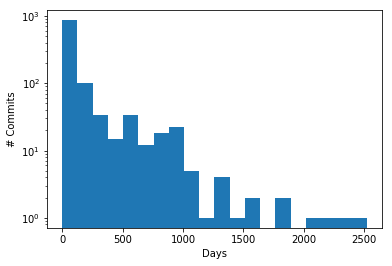

In [35]:
df_pos['days']=df_pos[df_pos['commit_tag_delay'] > 0]['commit_tag_delay']/(3600*24)

df1=df_pos[df_pos['commit_tag_delay'] > 0]['commit_tag_delay']/(3600*24)

 

df2=df1.to_frame()

 

le.save('FIXBELOWHANDREDDAYS', len(df2[(df2['commit_tag_delay']).round()<100]), 'Number of fix commits released in less than 100 days')

le.save('FIXBELOWONEDAYS', (len(df2[(df2['commit_tag_delay']).round() <1 ]) ), 'Number of fix commits released in less than 1 days')

le.save('FIXNOTRELEASED', len(df_pos[df_pos['days']==np.nan]), 'Number of fix commits not released')

 

d = {'Days': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,50,100,500,1000,2000 ],
     '# Commits': [len(df2[df2['commit_tag_delay'].round()<1]),
        len(df2[df2['commit_tag_delay'].round()>=1])&len(df2[df2['commit_tag_delay'].round()<2]),
        len(df2[df2['commit_tag_delay'].round()>=2])&len(df2[df2['commit_tag_delay'].round()<3]),
        len(df2[df2['commit_tag_delay'].round()>=3])&len(df2[df2['commit_tag_delay'].round()<4]),
        len(df2[df2['commit_tag_delay'].round()>=4])&len(df2[df2['commit_tag_delay'].round()<5]),
        len(df2[df2['commit_tag_delay'].round()>=5])&len(df2[df2['commit_tag_delay'].round()<6]),
        len(df2[df2['commit_tag_delay'].round()>=6])&len(df2[df2['commit_tag_delay'].round()<7]),
        len(df2[df2['commit_tag_delay'].round()>=7])&len(df2[df2['commit_tag_delay'].round()<8]),
        len(df2[df2['commit_tag_delay'].round()>=8])&len(df2[df2['commit_tag_delay'].round()<9]),
        len(df2[df2['commit_tag_delay'].round()>=9])&len(df2[df2['commit_tag_delay'].round()<10]),
        len(df2[df2['commit_tag_delay'].round()>=10])&len(df2[df2['commit_tag_delay'].round()<11]),
        len(df2[df2['commit_tag_delay'].round()>=11])&len(df2[df2['commit_tag_delay'].round()<12]),
        len(df2[df2['commit_tag_delay'].round()>=12])&len(df2[df2['commit_tag_delay'].round()<13]),
        len(df2[df2['commit_tag_delay'].round()>=13])&len(df2[df2['commit_tag_delay'].round()<14]),
        len(df2[df2['commit_tag_delay'].round()>=14])&len(df2[df2['commit_tag_delay'].round()<15]),
        len(df2[df2['commit_tag_delay'].round()>=15])&len(df2[df2['commit_tag_delay'].round()<50]),
        len(df2[df2['commit_tag_delay'].round()>=50])&len(df2[df2['commit_tag_delay'].round()<100]),
        len(df2[df2['commit_tag_delay'].round()>=100])&len(df2[df2['commit_tag_delay'].round()<500]),
        len(df2[df2['commit_tag_delay'].round()>=500])&len(df2[df2['commit_tag_delay'].round()<1000]),
        len(df2[df2['commit_tag_delay'].round()>=1000])&len(df2[df2['commit_tag_delay'].round()<2000])
]}

df = pd.DataFrame(data=d)

   

with open('msr2019/tex/delays'+'.tex','w') as tf:

        tf.write(df.to_latex(columns=['Days','# Commits'],index=False, column_format='lc'))

   

 

plt.savefig('msr2019/img/commitTagDelay'+'.pdf', dpi=200, bbox_inches='tight')
matplotlib.pyplot.hist(df1.round(),bins=20,log=True,histtype='bar')
matplotlib.pyplot.xlabel("Days")
matplotlib.pyplot.ylabel("# Commits")

## Create deduplicated version of (pos) dataset

Deduplication is based on the equality of commit messages.

In [36]:
# count duplicates

dup_idx = df_pos.duplicated(subset='msg')
if(len(dup_idx.value_counts())>1):
    dup_commit_count = dup_idx.value_counts()[1]
print('There are {} duplicate commits out of {}'.format(dup_commit_count, len(df_pos.index)))

le.save('DUPLICATECOMMITSCOUNT', dup_commit_count, 'Number of duplicate commits')

There are 420 duplicate commits out of 1282
[DUPLICATECOMMITSCOUNT] Number of duplicate commits: 420


In [37]:
df_pos_dedup = df_pos.drop_duplicates(subset='msg')
df_pos[df_pos.duplicated(subset='msg')].vuln_id.nunique()
# df_pos_dedup.vuln_id.nunique()
df_pos[dup_idx].sort_values('msg')

,cls,commit_id,commit_tag_delay,commit_timestamp,diff,fix_tag,fix_tag_timestamp,in_nvd,msg,repo_url,vuln_id,days
763,pos,dc4c3317452f0bc2c5e1f6a08d3bd9f22488b450,126207,1472597786,diff --git a/java/org/apache/catalina/realm/Da...,TOMCAT_8_0_37,1472723993,False,Make timing attacks against the Realm impleme...,https://github.com/apache/tomcat80,CVE-2016-0762,1.460729
330,pos,d79c63d424fe6b225678416343b9ce106dec947c,75177,1472597763,diff --git a/java/org/apache/catalina/realm/Da...,TOMCAT_8_5_5,1472672940,False,Make timing attacks against the Realm impleme...,https://github.com/apache/tomcat85,CVE-2016-0762,0.870104
1263,pos,458e511ce2f2b47fd216f68c0e385fc06a5f1d2f,4188007,1380253020,diff --git a/jetty-util/src/main/java/org/ecli...,jetty-9.0.x,1384441027,False,418014 Handle NTFS canonical exceptions during...,https://github.com/eclipse/jetty.project,PT-2013-65,48.472303
515,pos,4df5647f6dfdc5fa7abb812afe9290d60b17c098,50530587,1424727893,diff --git a/jetty-http/src/main/java/org/ecli...,jetty-9.3.13.M0,1475258480,False,460642 - HttpParser error 400 can expose previ...,https://github.com/eclipse/jetty.project,CVE-2015-2080,584.844757
1264,pos,d2e49be3a8f21d862726c1f6bc9e1caa6ee8b58,4665600,1512567732,diff --git a/activemq-client/src/main/java/org...,activemq-5.15.3,1517233332,False,AMQ-6871 - By default only send generic platfo...,https://github.com/apache/activemq,CVE-2017-15709,54.000000
537,pos,8ff18c5e254bf43395f2e0d7e3a1092b33ec646,-1512567766,1512567766,diff --git a/activemq-client/src/main/java/org...,,0,False,AMQ-6871 - By default only send generic platfo...,https://github.com/apache/activemq,CVE-2017-15709,NaN
824,pos,4150f107e60cac4a7735fcf7cb4c1889a0cbab6,774010,1458075612,diff --git a/spring-amqp/src/main/java/org/spr...,v1.5.5.RELEASE,1458849622,False,AMQP-590: Java Deserialization White List\n,https://github.com/spring-projects/spring-amqp,AMQP-590,8.958449
832,pos,462dcb6f1f93d54923daffb9729c1c8519576c08,773273,1458075370,diff --git a/spring-amqp/src/main/java/org/spr...,v1.6.0.M2,1458848643,False,AMQP-590: Java Deserialization White List\n,https://github.com/spring-projects/spring-amqp,AMQP-590,8.949919
1145,pos,83fe9fdec2c86a57898d56c5e109debd9d5c07d,168717,1504711070,diff --git a/spring-amqp/src/main/java/org/spr...,v1.5.7.RELEASE,1504879787,False,AMQP-766: Deserialization in Message.toString()\n,https://github.com/spring-projects/spring-amqp,CVE-2017-8045,1.952743
1102,pos,6e9e00bb5bf0aa88444146db3c2eae138cc7b0a,168550,1504710986,diff --git a/spring-amqp/src/main/java/org/spr...,v1.6.11.RELEASE,1504879536,False,AMQP-766: Deserialization in Message.toString()\n,https://github.com/spring-projects/spring-amqp,CVE-2017-8045,1.950810


In [38]:
le.save('DATASETSIZEPOS', len(df_pos.index), 'Number of \'pos\' commits in the dataset (this includes duplicates!)' )
le.save('DATASETSIZEPOSDEDUP', len(df_pos_dedup), 'Number of pos commits, **de-duplicated**')
# le.print()

[DATASETSIZEPOS] Number of 'pos' commits in the dataset (this includes duplicates!): 1282
[DATASETSIZEPOSDEDUP] Number of pos commits, **de-duplicated**: 862


## Expand dataset with 'negative' instances

In [ ]:
# import pandas as pd
# from acacia.git import *
# # from acacia.dataset import *
# from tqdm import tqdm

import random
RND_SEED=17534532

def expand_dataset(repos_set, df_pos):
    neg_instances = []
    SEC_REGEXP = '(denial.of.service|XXE|remote.code.execution|open.redirect|osvdb|secur.+|vuln.+|exploit.+|malicious.*|attack.*|dos|directory.traversal|injection|cve-\d+-\d+|xss|nvd|cross.site|csrf|rce|clickjack|session.fixation|advisory|insecur.+|cross.origin|unauthori[z|s].+)'

    for repo in tqdm(repos_set):
        count = len(df_pos.loc[df_pos['repo_url'] == repo])
        commits = get_random_commits(int(count * RATIO_POS_NEG), repo, GIT_REPO_FOLDER)
        for c in commits:
            try:
                new_instance = {}
                commit_msg = extract_commit_msg(c, repo, GIT_REPO_FOLDER)
                commit_diff = extract_commit_diff(c, repo, GIT_REPO_FOLDER) 
                if re.match(SEC_REGEXP, commit_msg.decode("utf-8")):
                    print('Found match of SEC_REGEXP in NEG instance')
                    print(commit_msg)

                new_instance = {
                    'msg' : commit_msg.decode("latin-1") ,
                    'diff': commit_diff.decode("latin-1") ,
                    'cls': 'neg',
                    'commit_id': c,
                    'repo_url': repo ,
                    'vuln_id' : '',
                    'in_nvd': False,
                    'fix_tag': '',
                    'fix_tag_timestamp': 0,
                    'commit_timestamp' : 0,
                    'commit_tag_delay': 0
                }
                neg_instances.append(new_instance)
            except Exception as e:
                print('There was an exception with this commit, skipping: %s:%s' % (repo,c) )
                print(e)
    return pd.DataFrame(neg_instances)

random.seed(RND_SEED)
df_neg = expand_dataset(repos_set,df_pos_dedup)



 64%|██████▍   | 155/243 [25:06<14:15,  9.72s/it]


 69%|██████▊   | 167/243 [27:34<12:33,  9.91s/it]

Failed to obtain patch for commit: a80c656c36e275e009788cb9eb7155b32c87e89d in dir: /tmp/git-cache-3/google-play-android-publisher-plugin
There was an exception with this commit, skipping: https://github.com/jenkinsci/google-play-android-publisher-plugin:a80c656c36e275e009788cb9eb7155b32c87e89d
'NoneType' object has no attribute 'decode'



 95%|█████████▌| 232/243 [51:38<02:26, 13.36s/it]

In [ ]:
df_neg = pd.DataFrame()
df_all = pd.concat([df_pos_dedup, df_neg], ignore_index = True)
overall_size = len(df_all.index)
print('The dataset contains '+ str(overall_size) + ' commits')

## Persist dataset

### Pickle

In [ ]:
df_all.to_pickle(DATASET_NAME + '_all.pd')
df_pos.to_pickle(DATASET_NAME + '_pos.pd')
df_pos_dedup.to_pickle(DATASET_NAME + '_pos_dedup.pd')

### CSV

In [ ]:
df_all[['repo_url','commit_id','cls']].to_csv(DATASET_NAME + '.csv')
df_pos_dedup[['repo_url','commit_id','cls']].to_csv(DATASET_NAME + '_pos_dedup.csv')
df_pos[['repo_url','commit_id','cls']].to_csv(DATASET_NAME + '_pos.csv')

# Analysis

In [ ]:
df_pos = pd.read_pickle(DATASET_NAME + '_pos.pd')
df_pos_dedup = pd.read_pickle(DATASET_NAME + '_pos_dedup.pd')

In [ ]:
 def diff(first, second):
        second = set(second)
        return [item for item in first if item not in second]

le.save('VULNLOSSDEDUP',
            len(diff(set(df_pos['vuln_id'].values),set(df_pos_dedup['vuln_id'].values))),
            'Number of vulnerabilities removed by the deduplication as they have the same fix commits than other vulnerabilities ')


In [ ]:
def print_counts(df, suffix=''):
    print("Dataset size:           {}".format(len(df.index)))
    print("Instances of class POS: {}".format(len(df[df['cls'] == POS_CLS ])))
    print("Instances of class NEG: {}".format(len(df[df['cls'] == NEG_CLS ])))

    le.save('COMMITCOUNT' + suffix,
            len(df[df['cls'] == POS_CLS ]),
            'Number of commits ' + suffix)
    
    le.save('VULNCOUNT'+suffix,
            df[df['cls'] == POS_CLS ].vuln_id.nunique(),
            'Unique vulnerabilities (after mapping vulns) ' + suffix)

    le.save('REPOCOUNT'+suffix,
            df[df['cls'] == POS_CLS ].repo_url.nunique(),
            'Number of unique repositories (after removing internal, dead, svn). ' + suffix)
    
    df.head()

print_counts(df_pos)
print('-----------------------------------------------')
print_counts(df_pos_dedup,'DEDUP')

print('-----------------------------------------------')
le.print()


### Number of Commits per CVE

In [ ]:
def printVulnXCommit(df,suffix=''):
    df2 = df.loc[df['cls']==POS_CLS,['commit_id','vuln_id']]
    df_vulnOnly = df2[['vuln_id']]
    df_vulnOnly['commits'] = df_vulnOnly.groupby('vuln_id')['vuln_id'].transform('count')
    df_vulnOnly=df_vulnOnly.drop_duplicates(subset=None, keep='first', inplace=False).sort_values(by='commits',ascending=False)
    #print(df_vulnOnly.sort_values(by='commits',ascending=False).head(20))
    print("Number of vuln with 1 commit: {}".format(len(df_vulnOnly[df_vulnOnly['commits']==1])))


    with open('msr2019/tex/commitXvuln'+suffix+'.tex','w') as tf:
        tf.write(df_vulnOnly.to_latex(columns=['vuln_id','commits'],index=False, column_format='lc'))
        
    # Create figure
    f, ax1 = plt.subplots(figsize=(5,3), dpi=200)

    df_vulnOnly.groupby('commits').count().plot(ax=ax1, kind='bar',logy=True )

    labels = df_vulnOnly.groupby('commits').count()
    print(labels['vuln_id'].tolist())
    #for i, v in enumerate(labels['vuln_id'].tolist()):
    #    ax1.text(v , i + .25, str(v), color='blue', fontweight='bold')
    
    #ax1.legend(loc=(0.65,0.05))
    ax1.legend().set_visible(False)

    f.subplots_adjust(hspace=0.1)
    # plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    ax1.grid(False)
    # ax1.set_title('msg', x=0.92, y=0.05)
    #ax1.set_title('# Vulnerabilities', x=0.52, y=0.85)
    plt.ylabel('# Vulnerabilities')
    plt.xlabel('# Commits')

    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    plt.savefig('msr2019/img/commitXvuln'+suffix+'.pdf', dpi=200, bbox_inches='tight')

printVulnXCommit(df_pos)
print('-----------------------------------------------')
printVulnXCommit(df_pos_dedup,'DEDUP')
        

### Number of vulnerabilities per repository

In [ ]:
def printvulnXrepo(df,suffix=''):
    df1=df.loc[df['cls']==POS_CLS,['repo_url','vuln_id']]

    #df1.groupby('repo_url').vuln_id.nunique()
    df1['distinct_vuln']=df1.groupby('repo_url')['vuln_id'].transform('nunique')
    df1.sort_values(by=['repo_url','vuln_id'])



    df1=df1[['repo_url','distinct_vuln']].drop_duplicates(subset=None, keep='first', inplace=False).sort_values(by='distinct_vuln',ascending=False)
    #df1.plot()
    #df1.groupby('distinct_vuln').count().plot(kind='bar')

    with open('msr2019/tex/vulnXrepo'+suffix+'.tex','w') as tf:
        tf.write(df1.to_latex(columns=['repo_url','distinct_vuln'],index=False, column_format='lc'))
        # Create figure
    f, ax1 = plt.subplots(figsize=(5,3), dpi=200)
    #print(df1.groupby('distinct_vuln').count())
    df1.groupby('distinct_vuln').count().plot(ax=ax1, kind='bar',logy=True )

    #ax1.legend(loc=(0.65,0.05))
    ax1.legend().set_visible(False)

    f.subplots_adjust(hspace=0.1)
    #plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    ax1.grid(False)
    # ax1.set_title('msg', x=0.92, y=0.05)
    #ax1.set_title('# Repo', x=0.52, y=0.85)
    plt.ylabel('#Repositories')
    plt.xlabel('#Vulnerabilities')

    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

    plt.savefig('msr2019/img/repoXNumVuln'+suffix+'.pdf', dpi=200, bbox_inches='tight')

printvulnXrepo(df_pos)
printvulnXrepo(df_pos_dedup,'DEDUP')


### Vulnerabilities per year

In [ ]:
def getYear(vuln_id):
    LOOKUP_TABLE_YEAR = {
        "413684" : "2013",
        "SONARQUBE-001" : "2018",
        "NIFI-4436" : "2017",
        "HADOOP-14246" : "2017",
        "HDFS-10276" : "2016",
        "ND4J-001" : "2018",
        "APACHE-COMMONS-001" : "2018",
        "HADOOP-13105" : "2016",
        "HADOOP-12001" : "2015",
        "HADOOP-15212" : "2018",
        "APACHE-AXIS2-5683" : "2015",
        "S2-028" : "2017",
        "PLEXUS-ARCHIVER-87" : "2018",
        "HADOOP-12751" : "2016",
        "JAVAMELODY-252" : "2015",
        "PT-2013-65" : "2013",
        "SPR-7779" : "2010",
        "HTTPCLIENT-1803" : "2017",
        "PRIMEFACES-1194" : "2016",
        "JAVAMELODY-631" : "2017",
        "ZEPPELIN-2769" : "2017",
        "APACHE-AXIS2-5846" : "2017",
        "AMQ-5751" : "2015",
        "AMQP-590": "2016",
        "2012-05-05" : "2012",
        "HUDSON-483532" : "2015",
        "GEODE-4270" : "2018",
        "S2-043" : "2016",
        "JETTY-1042" : "2009",
        "COLLECTIONS-580": '2015',
        "PDFBOX-3341":"2016"
    }
    z = re.search(r'(?<=CVE-)\d{4}',vuln_id)
    if(z is not None):
        year = z.group(0)
    else:
        year = LOOKUP_TABLE_YEAR[vuln_id]
    return year

def checkNVD(vuln_id):
    url = 'https://nvd.nist.gov/vuln/detail/'+vuln_id
#     print('Checking the NVD for ' + url)
    r = requests.get('https://nvd.nist.gov/vuln/detail/'+vuln_id)
    if r.status_code!=200 :
        return False
    if 'CVE ID Not Found' in r.text:
        return False
    if 'Vuln ID, expected format: CVE-'  in r.text:
        return False
    return True
        

In [ ]:
def printVulnXYear(df,suffix=''):
    df_vuln=df.loc[df['cls']==POS_CLS,['vuln_id']].drop_duplicates(subset=None, keep='first', inplace=False)

    print("Number of distinct vuln : {}".format(len(df_vuln)))

    df_vuln['year'] = df_vuln['vuln_id'].apply(lambda x: getYear(x))

    # Create figure
    f, ax1 = plt.subplots(figsize=(5,4), dpi=200)

    df_vuln.groupby('year').count().plot(kind='bar',ax=ax1)

    #ax1.legend(loc=(0.65,0.05))
    ax1.legend().set_visible(False)

    f.subplots_adjust(hspace=0.1)
    #plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    ax1.grid(False)
    # ax1.set_title('msg', x=0.92, y=0.05)
    #ax1.set_title('# Repo', x=0.52, y=0.85)
    plt.ylabel('#Vulnerabilities')

    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

    plt.savefig('msr2019/img/vulnXYear'+suffix+'.pdf', dpi=200, bbox_inches='tight')
    
printVulnXYear(df_pos)
printVulnXYear(df_pos_dedup,'DEDUP')

In [ ]:
def populateInNvd(df):
    count=0
    for i, row in df.iterrows():
        #print('https://nvd.nist.gov/vuln/detail/'+x)
        count += 1
        print('.', end = '')
        if not count % 50:
            print(' ' + str(count) + '\n')
        check_outcome = checkNVD(df.at[i,'vuln_id'])
        df.at[i,'in_nvd'] = check_outcome
    print('\n')
        
populateInNvd(df_pos)
populateInNvd(df_pos_dedup)

In [ ]:
len(df_pos_dedup)

In [ ]:
def countNVDStats(df,suffix=''):
    vulns_all_count = df.vuln_id.nunique()
    le.save('ALLVULNSCOUNT' +suffix,
            vulns_all_count,
            "Number of distinct vulnerabilities in the dataset " + suffix)

    vulns_nvd_count = df[df['in_nvd'] == 1.0 ].vuln_id.nunique()
    le.save('ALLVULNSINNVD'+suffix,
        vulns_nvd_count,
        'Number of vulnerabilities found in the NVD '  + suffix)

    cves_no_nvd_count = vulns_all_count - vulns_nvd_count
    le.save('CVENONVD'+suffix,
        cves_no_nvd_count,
        'Number of vulnerabilities that have a CVE but are not found in the NVD '  + suffix)

    cves_count = len(df[df['vuln_id'].str.contains('CVE-')]['vuln_id'].unique())
    le.save('VULNSNOCVE'+suffix,
        vulns_all_count - cves_count,
        'Number of vulnerabilities that do not have a CVE name '  + suffix)
    
countNVDStats(df_pos)
countNVDStats(df_pos_dedup,'DEDUP')

### Export stats to LaTeX

In [ ]:
le.to_file('msr2019/tex/data_from_notebook.tex')